# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

# Цели исследования и план работы

- **Цели исследования:**<br> 
Научиться определять рыночную стоимость объектов недвижимости, проанализировав их параметры.
  1. Создать потрет объявления;
  2. Создать портрет среднего объекта;
  3. Найти зависимости параметров объектов с их стоимостью.<br><br>
  
- **План работы:**
  1. Знакомство с предоставленнными данными;
  2. Предобработка данных;
  3. Рассчёт дополнительных параметров;
  4. Исследовательский анализ.
  5. Вывод. <br><br>
  
- **Предварительный комментарий:**
<br>В процессе подачи тест-объявления о продаже на сайте <a href="https://realty.ya.ru/management-new/add/" target="_blank">Яндекс.Недвижимости</a> было выявлено, что для подачи объявления необходимы:
  - регистрация аккаунта;
  - адрес, по которому система определяет нас. пункт и другие параметры;
  - 4 фотографии объекта;
  - остальные параметры не обязательны к заполнению и могут быть не указаны.

### Откройте файл с данными и изучите общую информацию. 

In [4]:
# Установка библиотеки GeoPy для вычисления расстояний - https://geopy.readthedocs.io/en/stable/#module-geopy.distance
!pip install geopy

### Импорт библиотек, которые будем использовать
# pandas для работы с датафреймами
import pandas as pd
## matplotlib и seaborn для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns
# Библиотека numpy для рассчетов
import numpy as np
# библиотека requests для формирования запроса к HTTP-геокодеру Яндекс.Карт
import requests
## geopy для вычисления расстояний
from geopy import distance

# Открываем файл и записываем его в перенную data
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

In [2]:
# Установим отображение всех столбцов при выводе датафрейма
pd.set_option('display.max_columns', None)

# Установим стиль отображения заголовков таблиц
styles = [dict(selector='caption',
              props=[('text-align', 'center'),
                     ('font-size', '120%'),
                     ('color', 'black'),
                     ('font-weight', 'bold')])]

#### Ознакомление с датафреймом:

In [3]:
# Введем переменную - счетчик строк, для учета изменений
shape_counter = list(data.shape)

# Отобразим первые 20 строк таблицы
display(data.head(20))
f'Количество строк - {data.shape[0]}, кол-во столбцов - {data.shape[1]}.'

total_images  last_price  total_area first_day_exposition  rooms  \
0             20  13000000.0      108.00  2019-03-07T00:00:00      3   
1              7   3350000.0       40.40  2018-12-04T00:00:00      1   
2             10   5196000.0       56.00  2015-08-20T00:00:00      2   
3              0  64900000.0      159.00  2015-07-24T00:00:00      3   
4              2  10000000.0      100.00  2018-06-19T00:00:00      2   
5             10   2890000.0       30.40  2018-09-10T00:00:00      1   
6              6   3700000.0       37.30  2017-11-02T00:00:00      1   
7              5   7915000.0       71.60  2019-04-18T00:00:00      2   
8             20   2900000.0       33.16  2018-05-23T00:00:00      1   
9             18   5400000.0       61.00  2017-02-26T00:00:00      3   
10             5   5050000.0       39.60  2017-11-16T00:00:00      1   
11             9   3300000.0       44.00  2018-08-27T00:00:00      2   
12            10   3890000.0       54.00  2016-06-30T00:00:00      2   
13            20   3550000.0       42.80  2017-07-01T00:00:00      2   
14             1   4400000.0       36.00  2016-06-23T00:00:00      1   
15            16   4650000.0       39.00  2017-11-18T00:00:00      1   
16            11   6700000.0       82.00  2017-11-23T00:00:00      3   
17             6   4180000.0       36.00  2016-09-09T00:00:00      1   
18             8   3250000.0       31.00  2017-01-27T00:00:00      1   
19            16  14200000.0      121.00  2019-01-09T00:00:00      3   

    ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0             2.70          16.0        51.00      8          NaN   False   
1              NaN          11.0        18.60      1          NaN   False   
2              NaN           5.0        34.30      4          NaN   False   
3              NaN          14.0          NaN      9          NaN   False   
4             3.03          14.0        32.00     13          NaN   False   
5              NaN          12.0        14.40      5          NaN   False   
6              NaN          26.0        10.60      6          NaN   False   
7              NaN          24.0          NaN     22          NaN   False   
8              NaN          27.0        15.43     26          NaN   False   
9             2.50           9.0        43.60      7          NaN   False   
10            2.67          12.0        20.30      3          NaN   False   
11             NaN           5.0        31.00      4        False   False   
12             NaN           5.0        30.00      5          NaN   False   
13            2.56           5.0        27.00      5          NaN   False   
14             NaN           6.0        17.00      1          NaN   False   
15             NaN          14.0        20.50      5          NaN   False   
16            3.05           5.0        55.60      1          NaN   False   
17             NaN          17.0        16.50      7          NaN   False   
18            2.50           5.0        19.40      2          NaN   False   
19            2.75          16.0        76.00      8          NaN   False   

    open_plan  kitchen_area  balcony              locality_name  \
0       False         25.00      NaN            Санкт-Петербург   
1       False         11.00      2.0             посёлок Шушары   
2       False          8.30      0.0            Санкт-Петербург   
3       False           NaN      0.0            Санкт-Петербург   
4       False         41.00      NaN            Санкт-Петербург   
5       False          9.10      NaN  городской посёлок Янино-1   
6       False         14.40      1.0          посёлок Парголово   
7       False         18.90      2.0            Санкт-Петербург   
8       False          8.81      NaN             посёлок Мурино   
9       False          6.50      2.0            Санкт-Петербург   
10      False          8.50      NaN            Санкт-Петербург   
11      False          6.00      1.0                  Ломоносов   
12

'Количество строк - 23699, кол-во столбцов - 22.'

In [4]:
data.describe()

total_images    last_price    total_area         rooms  ceiling_height  \
count  23699.000000  2.369900e+04  23699.000000  23699.000000    14504.000000   
mean       9.858475  6.541549e+06     60.348651      2.070636        2.771499   
std        5.682529  1.088701e+07     35.654083      1.078405        1.261056   
min        0.000000  1.219000e+04     12.000000      0.000000        1.000000   
25%        6.000000  3.400000e+06     40.000000      1.000000        2.520000   
50%        9.000000  4.650000e+06     52.000000      2.000000        2.650000   
75%       14.000000  6.800000e+06     69.900000      3.000000        2.800000   
max       50.000000  7.630000e+08    900.000000     19.000000      100.000000   

       floors_total   living_area         floor  kitchen_area       balcony  \
count  23613.000000  21796.000000  23699.000000  21421.000000  12180.000000   
mean      10.673824     34.457852      5.892358     10.569807      1.150082   
std        6.597173     22.030445      4.885249      5.905438      1.071300   
min        1.000000      2.000000      1.000000      1.300000      0.000000   
25%        5.000000     18.600000      2.000000      7.000000      0.000000   
50%        9.000000     30.000000      4.000000      9.100000      1.000000   
75%       16.000000     42.300000      8.000000     12.000000      2.000000   
max       60.000000    409.700000     33.000000    112.000000      5.000000   

       airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
count      18157.000000         18180.000000      18181.000000    8079.000000   
mean       28793.672193         14191.277833          0.611408     490.804555   
std        12630.880622          8608.386210          0.802074     342.317995   
min            0.000000           181.000000          0.000000       1.000000   
25%        18585.000000          9238.000000          0.000000     288.000000   
50%        26726.000000         13098.500000          0.000000     455.000000   
75%        37273.000000         16293.000000          1.000000     612.000000   
max        84869.000000         65968.000000          3.000000    3190.000000   

       ponds_around3000  ponds_nearest  days_exposition  
count      18181.000000    9110.000000     20518.000000  
mean           0.770255     517.980900       180.888634  
std            0.938346     277.720643       219.727988  
min            0.000000      13.000000         1.000000  
25%            0.000000     294.000000        45.000000  
50%            1.000000     502.000000        95.000000  
75%            1.000000     729.000000       232.000000  
max            3.000000    1344.000000      1580.000000

In [5]:
data.describe(include=["object", "bool"])

first_day_exposition is_apartment studio open_plan    locality_name
count                 23699         2775  23699     23699            23650
unique                 1491            2      2         2              364
top     2018-02-01T00:00:00        False  False     False  Санкт-Петербург
freq                    368         2725  23550     23632            15721

#### Информация о типах данных в датафрейме:

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

#### **Общая гистограмма для всех числовых столбцов.**


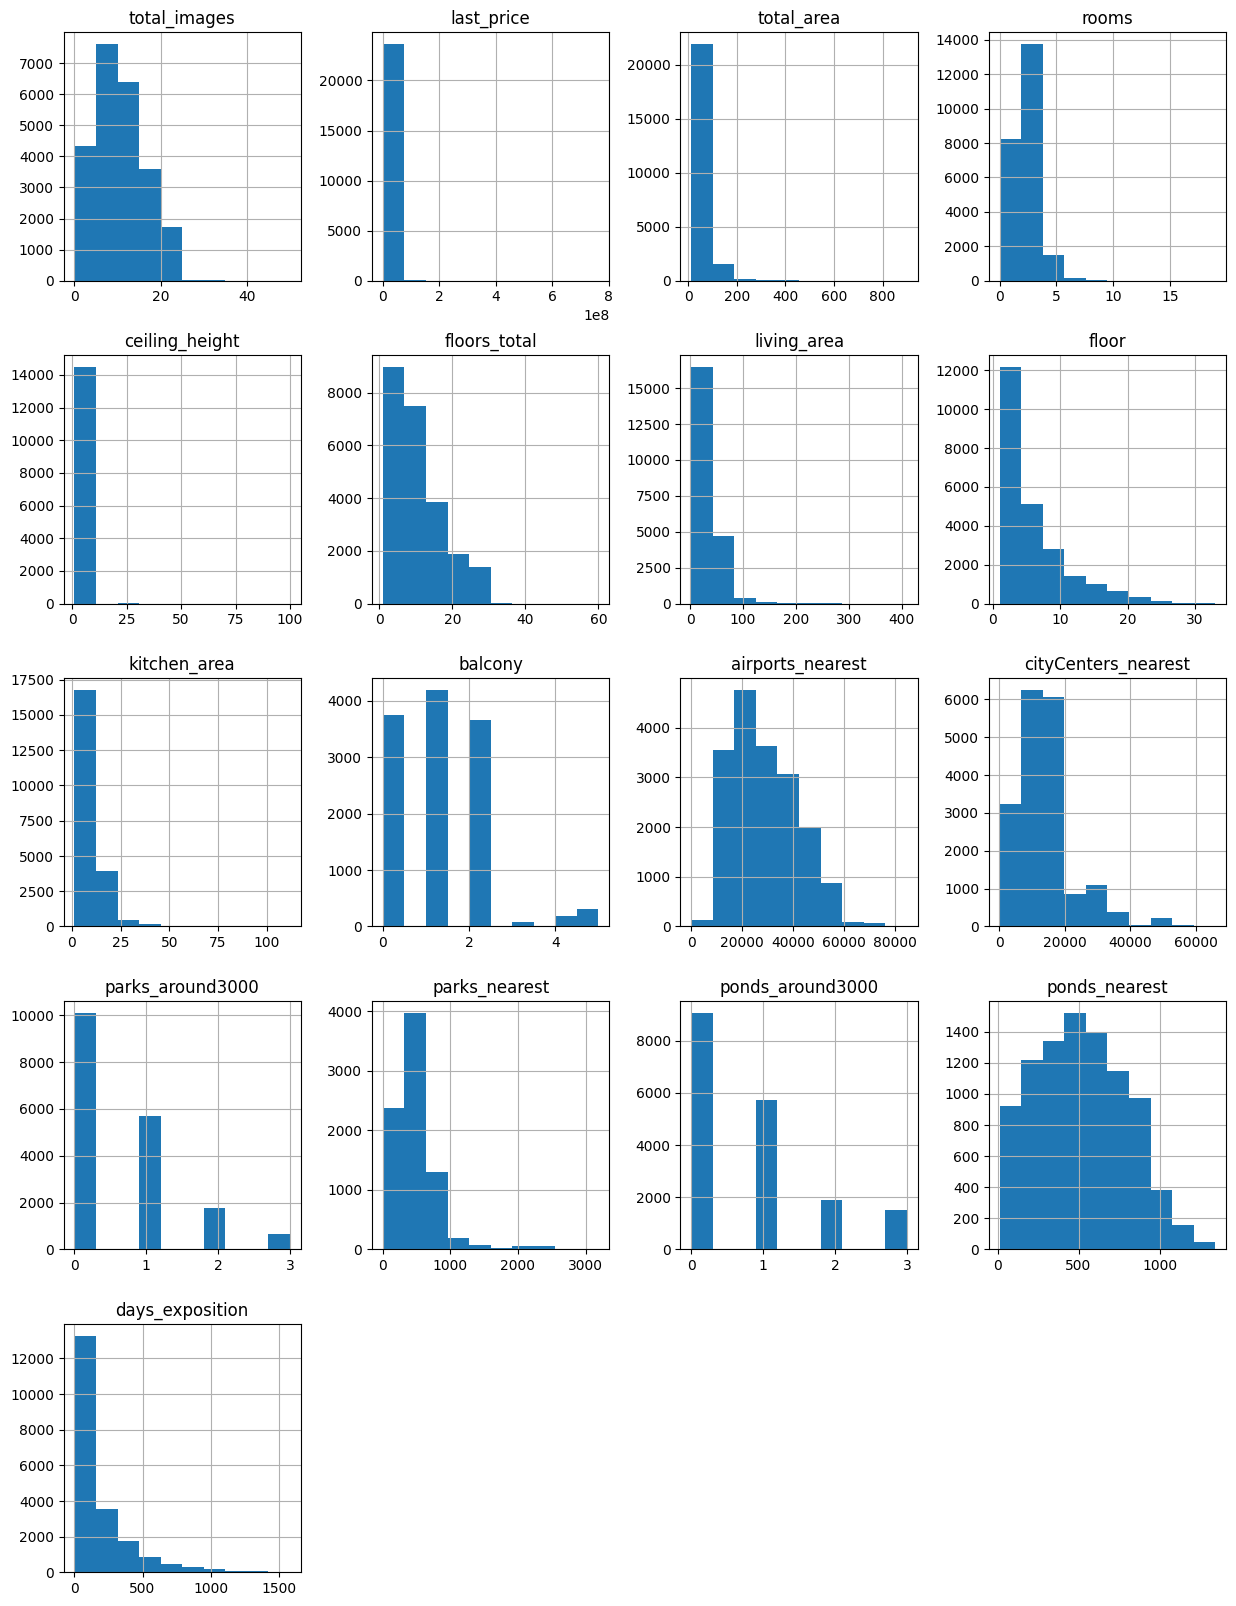

In [7]:
data.hist(figsize=(15, 20));

#### Описание столбцов для справки:
- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- `balcony` — число балконов
- `ceiling_height` — высота потолков (м)
- `cityCenters_nearest` — расстояние до центра города (м)
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
- `first_day_exposition` — дата публикации
- `floor` — этаж
- `floors_total` — всего этажей в доме
- `is_apartment` — апартаменты
- `kitchen_area` — площадь кухни в квадратных метрах (м²)
- `last_price` — цена на момент снятия с публикации
- `living_area` — жилая площадь в квадратных метрах (м²)
- `locality_name` — название населённого пункта
- `open_plan` — свободная планировка (булев тип)
- `parks_around3000` — число парков в радиусе 3 км
- `parks_nearest` — расстояние до ближайшего парка (м)
- `ponds_around3000` — число водоёмов в радиусе 3 км
- `ponds_nearest` — расстояние до ближайшего водоёма (м)
- `rooms` — число комнат
- `studio` — квартира-студия (булев тип)
- `total_area` — общая площадь квартиры в квадратных метрах (м²)
- `total_images` — число фотографий квартиры в объявлении

#### Проверка данных на явные дубликаты.

In [8]:
data.duplicated().sum()

0

#### Предварительные выводы по составу датафрейма:
- Файл содержит данные по 23699 объектам недвижимости, каждый из которых описывается 22 характеристиками (17 количественных, 4 категориальных и 1 временная).<br>

- Особенности данных:
  - в столбцах присутствуют аномальные или нехарактерные для рынка значения:
    - `total_area` до 800 м<sup>2</sup>;
    - `rooms` до 15;
    - `ceiling_height` до 100м;
    - `living_area` до 400 м<sup>2</sup>;
    - `kitchen_area` до 100 м<sup>2</sup>;
    - `days_exposition` до 1500 дней;
  - большое кол-во пропусков;
  - неверные типы данных, например,
    - `is_apartment` - `object`, должен быть `bool`;
    - `parks_around`, `ponds_around`, `days_exposition`, - `float64`, должны быть `int64`;
  - некорректные названия столбцов.

### **Предобработка данных**

#### **Анализ пропусков.**

##### Пропуски по столбцам.

In [9]:
# Выводим долю пропущенных записей от общего кол-ва записей по столбцам в процентах и 
# кол-во пропущенных записей по столбцам:
data_missing_before = pd.DataFrame({'Доля пропусков по столбцу': 
                                   (round(data.isna().sum() / len(data), 4).map('{:.2%}'.format)), 
                                   'Кол-во пропусков по столбцу': data.isna().sum()})
data_missing_before.sort_values(by='Кол-во пропусков по столбцу', ascending=False)

Доля пропусков по столбцу  Кол-во пропусков по столбцу
is_apartment                            88.29%                        20924
parks_nearest                           65.91%                        15620
ponds_nearest                           61.56%                        14589
balcony                                 48.61%                        11519
ceiling_height                          38.80%                         9195
airports_nearest                        23.38%                         5542
cityCenters_nearest                     23.29%                         5519
ponds_around3000                        23.28%                         5518
parks_around3000                        23.28%                         5518
days_exposition                         13.42%                         3181
kitchen_area                             9.61%                         2278
living_area                              8.03%                         1903
floors_total                             0.36%                           86
locality_name                            0.21%                           49
total_images                             0.00%                            0
last_price                               0.00%                            0
studio                                   0.00%                            0
floor                                    0.00%                            0
rooms                                    0.00%                            0
first_day_exposition                     0.00%                            0
total_area                               0.00%                            0
open_plan                                0.00%                            0

##### Пропуски в столбце - `rooms` 
("кол-во комнат")

In [10]:
display('Процент значений 0 от общего кол-ва записей: '
        f'{round(data.query("rooms == 0")["rooms"].count() / len(data["rooms"]), 4):.2%}')

'Процент значений 0 от общего кол-ва записей: 0.83%'

###### Гипотезы:
**Причины появления `0`:**
- необязательность указания кол-ва комнат при подаче объявления;
- ошибки в заполнении;
- отсутствие комнат в плане помещения и указание продавцами 0 либо 1 комнаты в качестве маркера типа планировки объекта;
<br>

Объекты с `0` в кол-ве комнат должны полностью входить в типы планировки - "студия" или "открытая". Проверим записи с неуказанным кол-вом комнат на полное вхождение либо в объекты-студии либо в объекты с открытиой планировкой.

###### Анализ:

In [11]:
rooms_delta = data.query('studio == True or open_plan == True')['rooms'].count() -\
              data.query('rooms == 0')['rooms'].count()

display('Кол-во объектов без указания кол-ва комнат входящих в типы планировки - "студия" или "открытая": '
        f'{rooms_delta}')

'Кол-во объектов без указания кол-ва комнат входящих в типы планировки - "студия" или "открытая": 19'

###### Выводы:
Объекты с `0` в кол-ве комнат полностью входят в типы планировки - "студия" или "открытая" и остаётся 19 объектов с такими планировками, в которых комнат более 0. Для объектов-студий это аномальные значения. Изменим их в [соответствующем разделе](#fn6).

##### Пропуски в столбце - `ceiling_height` 
("высота потолков")

In [12]:
display('Процент пропусков от общего кол-ва записей:'
        f'{round(data["ceiling_height"].isna().sum() / len(data["ceiling_height"]), 4):.2%}')

'Процент пропусков от общего кол-ва записей:38.80%'

###### Гипотезы:
**Причины появления пропусков:**
- желание продавцов скрыть непривлекательные параметры до последнего, тем самым привлечь максимальное кол-во потенциальных покупателей;
- предположение продавца, что высоты потолков в типовых домах известны покупателям (пример: высота потолков в "хрущевках" ~ 2.5м);
- необязательность указания этажа при подаче объявления;
- ошибки в заполнении / передаче данных.

**Заполнение пропусков:**<br>
- Значения высот потолков можно было бы заменить на средние или медианные в [типовых домах массовой застройки__*__](#fn1), если такие дома составляют большу́ю часть датафрейма. <br>
- Значения высот потолков в нетиповых домах могут быть крайне не характерны для остальных данных. Оставим их без изменений.

###### Анализ:
Для оценки целесообразности замены пропущенных значений для типовых домов:
1. проверим распределение пропущенных значений по этажности домов: если пропусков по типовым этажностям достаточно много, замена пропусков будет эффективной;
2. проверим распределение заполненных значений по каждой из типовых этажностей: если в заполненных значениях большой процент типовых высот, замена пропусков типовыми значениями не исказит распределение.
<br><br><br>
__*__<span id="fn1"> Справка по типовым домам массовой застройки (источник: <a href="https://www.bn.ru/sprav_dom.phtml" target="_blank">"Типы и серии домов Петербурга" - bn.ru</a>):
- 5 этажей, высота потолков 2.5м
- 9 этажей, высота потолков 2.5м / 2.64м
- 10 этажей, высота потолков 2.5м / 2.64м
- 12 этажей, высота потолков 2.5м / 2.64м
- 16 этажей, выотса потолков 2.5м / 2.64м / 2.7м </span><br>

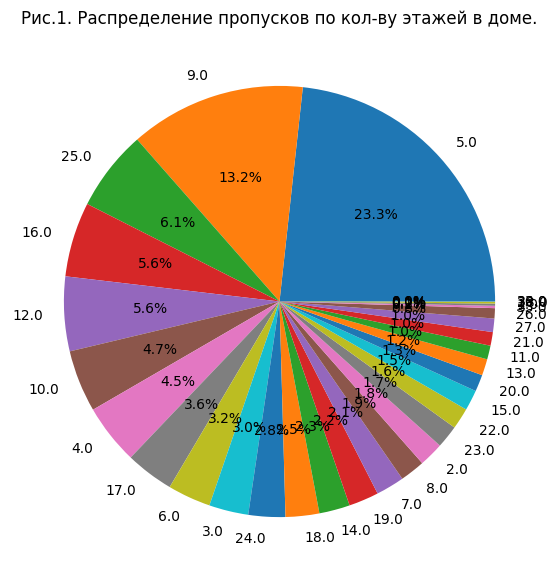

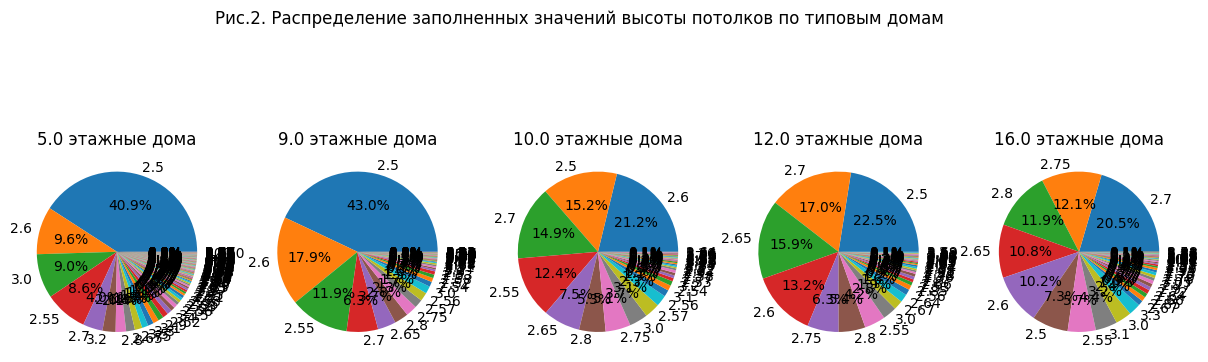

Средняя высота потолков  Медианная высота потолков  \
Этажей в доме                                                       
5.0                           2.793191                       2.55   
9.0                           2.599093                       2.55   
10.0                          2.685200                       2.60   
12.0                          2.640258                       2.65   
16.0                          2.747503                       2.70   

                       Типовые высоты  
Этажей в доме                          
5.0                               2.5  
9.0                      2.5 или 2.64  
10.0                     2.5 или 2.64  
12.0                     2.5 или 2.64  
16.0           2.5 или 2.64м или 2.7м

In [13]:
# Отобразим процент пропусков по кол-ву этажей в доме
(data.query('ceiling_height.isna()')['floors_total'].value_counts()
 .plot(kind='pie',
       figsize=(7, 7),
       autopct='%1.1f%%', 
       title='Рис.1. Распределение пропусков по кол-ву этажей в доме.', 
       label='')
)
plt.show()

# Смотрим распределение заполненных значений высот потолков в типовых домах
# Список кол-ва этажей в типовых домах
mass_floors = [5.0, 9.0, 10.0, 12.0, 16.0]
i = 0
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle('Рис.2. Распределение заполненных значений высоты потолков по типовым домам');
for floor_per_ceiling in mass_floors:
    heights = data.query('floors_total == @floor_per_ceiling')['ceiling_height'].value_counts()
    ax[i].pie(heights, autopct='%1.1f%%', labels=heights.index)
    ax[i].set_title(f'{floor_per_ceiling} этажные дома')   
    i += 1
plt.show()

# Выведем среднюю и медианную высоты по этажности
data_floors_pivoted = data.query('floors_total in @mass_floors').pivot_table(index='floors_total',
                                                                             values='ceiling_height',
                                                                             aggfunc=['mean', 'median'])
# Создаем столбец с типовыми высотами
reference_ceiling = {'Типовые высоты': ['2.5', 
                                        '2.5 или 2.64',
                                        '2.5 или 2.64',
                                        '2.5 или 2.64',
                                        '2.5 или 2.64м или 2.7м']}
reference_data = pd.DataFrame(data=reference_ceiling, index=mass_floors)

# Заменяем названия столбцов для наглядности
data_floors_pivoted.columns = ['Средняя высота потолков', 'Медианная высота потолков']
data_floors_pivoted.index.rename('Этажей в доме', inplace=True)

#Объединяем столбцы с высотами
data_floors_pivoted.join(reference_data)

###### Выводы:
1. Рис.1 показывает, что замена пропусков будет эффективной, т.к. доля пропусков в домах с кол-вом этажей, соответствующим типовым, больше 40% от общего кол-ва пропусков высот потолков:
  - 23% в 5 этажных;
  - 13% в 9 этажных;
  - 6% в 12 этажных.<br>
2. Проанализировав Рис. 2, можно сказать, что почти половина заполненных значений высот потолков для каждой этажности соответствует типовой, что означает наличие большого кол-ва типовых домов в данных.
3. Медианные высоты потолков по соответствующим этажностям находятся в пределах характерных типовых значений, что позволяет заменить пропуски без искажения данных.<br>
**Итог:** Заменим пропуски высот потолков в типовых домах с 5, 9, 10, 12, 16 этажами на соответствующие медианные значения и проверим результат.

In [14]:
display('Пропусков высот потолков по типовым этажностям до замены:'
        f'{data.query("floors_total in @mass_floors")["ceiling_height"].isna().sum()}')

# Замена пропусков высот потолков в типовых домах с 5, 9, 10, 12, 16 этажами
for floor_to_replace in mass_floors:
    data.loc[(data['floors_total'] == floor_to_replace) &\
             (data['ceiling_height'].isna()), 'ceiling_height'] = \
    data.loc[(data['floors_total'] == floor_to_replace), 'ceiling_height'].median()
    
# Проверка наличия пропусков высот потолков в типовых домах
display('Пропусков высот потолков по типовым этажностям после замены:'
f'{data.query("floors_total in @mass_floors")["ceiling_height"].isna().sum()}')

'Пропусков высот потолков по типовым этажностям до замены:4770'

'Пропусков высот потолков по типовым этажностям после замены:0'

##### Пропуски в столбце - `floors_total`
 "кол-во этажей"

In [15]:
display('Процент пропусков от общего кол-ва записей:'
        f'{round(data["floors_total"].isna().sum() / len(data["floors_total"]), 4):.2%}')
data.query('floors_total.isna()')

'Процент пропусков от общего кол-ва записей:0.36%'

total_images  last_price  total_area first_day_exposition  rooms  \
186              12  11640000.0        65.2  2018-10-02T00:00:00      2   
237               4   2438033.0        28.1  2016-11-23T00:00:00      1   
457               4   9788348.0        70.8  2015-08-01T00:00:00      2   
671               4   6051191.0        93.6  2017-04-06T00:00:00      3   
1757              5   3600000.0        39.0  2017-04-22T00:00:00      1   
...             ...         ...         ...                  ...    ...   
22542             5   8500000.0        63.5  2017-05-24T00:00:00      2   
22656             4   4574160.0        64.5  2017-04-02T00:00:00      2   
22808             0  14569263.0       110.4  2016-11-20T00:00:00      3   
23590             0  21187872.0       123.3  2017-04-25T00:00:00      3   
23658             6   3063600.0        43.8  2016-11-28T00:00:00      1   

       ceiling_height  floors_total  living_area  floor is_apartment  studio  \
186               NaN           NaN        30.80      4          NaN   False   
237               NaN           NaN        20.75      1          NaN   False   
457               NaN           NaN        38.40     12          NaN   False   
671               NaN           NaN        47.10      8          NaN   False   
1757              NaN           NaN          NaN      9          NaN   False   
...               ...           ...          ...    ...          ...     ...   
22542             2.8           NaN          NaN      3          NaN   False   
22656             NaN           NaN        31.70     20          NaN   False   
22808             NaN           NaN        45.38      6          NaN   False   
23590             NaN           NaN        50.40     18          NaN   False   
23658             2.7           NaN        14.00      8          NaN   False   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
186        False         12.00      NaN  Санкт-Петербург           39197.0   
237        False           NaN      0.0  Санкт-Петербург           22041.0   
457        False         10.63      0.0  Санкт-Петербург           37364.0   
671        False         16.80      0.0  Санкт-Петербург           22041.0   
1757       False           NaN      0.0  Санкт-Петербург           22735.0   
...          ...           ...      ...              ...               ...   
22542      False           NaN      NaN  Санкт-Петербург           51340.0   
22656      False         14.40      0.0  Санкт-Петербург           22041.0   
22808      False         23.42      0.0  Санкт-Петербург           19095.0   
23590      False         23.60      0.0  Санкт-Петербург           19095.0   
23658      False         15.50      2.0  Санкт-Петербург            8426.0   

       cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
186                12373.0               1.0          123.0               0.0   
237                17369.0               0.0            NaN               1.0   
457                 8322.0               2.0          309.0               2.0   
671                17369.0               0.0            NaN               1.0   
1757               11618.0               1.0          835.0               1.0   
...                    ...               ...            ...               ...   
22542              15363.0               0.0            NaN               1.0   
22656              17369.0               0.0            NaN               1.0   
22808               4529.0               0.0            NaN               0.0   
23590               4529.0               0.0            NaN               0.0   
23658              12082.0               2.0           24.0               1.0   

       ponds_nearest  days_exposition  
186              NaN             49.0  
237            374.0            251.0  
457            706.0            727.0  
671            374.0            123.0  
1757           652.0             77

**Причины появления пропусков:**
- необязательность указания этажа при подаче объявления;
- ошибки в заполнении / передаче данных.

**Заполнение пропусков:**<br>
- Так как доля пропущенных значений невысока (0.35%) и предположить или вычислить значения проблематично, оставим пропуски без зизменений и учтем при анализе.

##### Пропуски в столбцах - `living_area` и `kitchen area`
("жилая площадь" и "площадь кухни")

In [16]:
# Выведем процент и кол-во пропусков жилой площади для оценки
display('Процент пропусков жилой площади:'
        f'{round(data["living_area"].isna().sum() / len(data["living_area"]), 4):.2%}.'
        'Кол-во пропусков жилой площади:'
        f'{data["living_area"].isna().sum()}.')

# Выведем процент и кол-во пропусков площади кухни для оценки
display('Процент пропусков площади кухни:'
        f'{round(data["kitchen_area"].isna().sum() / len(data["kitchen_area"]), 4):.2%}.'
        'Кол-во пропусков площади кухни:'
        f'{data["kitchen_area"].isna().sum()}.')

# Вычислим процент пропусков площадей в студиях и кв. с открытой планировкой
ratio_kitchen_missing = data.query("studio == True or open_plan == True and ~(kitchen_area.isna())")

# Выведем процент пропусков площадей в студиях и кв. с открытой планировкой
display(f'Процент пропусков площади в студиях и квартирах со свободной планировкой от общего числа записей в столбце:\
{round(ratio_kitchen_missing["kitchen_area"].isna().sum() / len(data["kitchen_area"]), 4):.2%}.')

'Процент пропусков жилой площади:8.03%.Кол-во пропусков жилой площади:1903.'

'Процент пропусков площади кухни:9.61%.Кол-во пропусков площади кухни:2278.'

'Процент пропусков площади в студиях и квартирах со свободной планировкой от общего числа записей в столбце:0.63%.'

###### Гипотезы:
**Причины появления пропусков:**
- предположение продавца, что 
 - жилая площадь не так важна как общая;
 - не так отражает заявленную цену;
 - общей площади достаточно для оценки привлекательности квартиры;
- необязательность указания жилой площади и площади кухни при подаче объявления;
- ошибки в заполнении / передаче данных;
- возможно, жилая площадь и площадь кухни не указана в квартирах-студиях (столбец `studio`) или квартирах со свободной планировкой (столбец `open_plan`).

**Заполнение пропусков:**<br>
- площадь кухни может быть расчитана как разница общей и жилой или нежилой площадей, не включая балконы и лоджии, но т.к. данные о нежилой площади (подсобные помещения, гардеробные, коридоры, ванные комнаты) не включены в датасет, рассчитать значения не представляется возможным;
- также будет неверным заполнение значений медианными или средними по категориям, т.к. планировки могут разительно отличаться;
- гипотеза о пропусках в значениях жилой площади и площади кухни в квартирах-студиях или квартирах со свободной планировкой требует проверки.

###### Анализ
Проверим гипотезу о пропусках значениях жилой площади от обратного: если в данных есть квартиры-студии с заполненными значениями общей и жилой площадей, говорить о том, что все пропуски жилой площади относятся к квартирам-студиям нельзя. Для проверки выведем два среза датафрейма с условиями:
- квартира - студия или  с открытой планировкой;
- и указаны
 - и общая и жилая площади;
 - указана площадь кухни.

In [17]:
# Проверим есть ли строки с заполненными значениями общих и жилых площадей для квартир-студий
display('Кол-во записей для квартир-студий с заполненными значениями общих и жилых площадей: '
        f'{len(data.query("~(living_area.isna()) and studio == True and ~(total_area.isna())"))}')

# Проверим есть ли строки с заполненными значениями общих и жилых площадей для квартир с открытой планировкой
display('Кол-во записей для квартир с открытой планировкой с заполненными значениями общих и жилых площадей: '
        f'{len(data.query("~(living_area.isna()) and open_plan == True and ~(total_area.isna())"))}')


# Проверим, есть ли заполненные значения площадей кухни для квартир-студий 
display('Кол-во заполненных значений площадей кухонь в квартирах-студиях: '
        f'{len(data.query("studio == True and ~(kitchen_area.isna())"))}')

# Проверим, есть ли заполненные значения площадей кухни для квартир с открытой планировкой
display(f'Кол-во заполненных значений площадей кухонь в квартирах с открытой планировкой: '
        f'{len(data.query("open_plan == True and ~(kitchen_area.isna())"))}')

'Кол-во записей для квартир-студий с заполненными значениями общих и жилых площадей: 139'

'Кол-во записей для квартир с открытой планировкой с заполненными значениями общих и жилых площадей: 62'

'Кол-во заполненных значений площадей кухонь в квартирах-студиях: 0'

'Кол-во заполненных значений площадей кухонь в квартирах с открытой планировкой: 0'

###### Выводы:
1. Т.к. в данных есть квартиры с указанными общей и жилой площадями как для квартир-студий так и для квартир с открытой планировкой, гипотеза о пропусках для данных категориях не подтвердилась. Замена пропусков другими способами будет некорректной, а удаление записей может привести к искажению данных, поэтому оставими значения пустыми.
2. Для данных по площадям кухонь гипотеза подтвердилась: во всех даных по квартирам-студиям и квартирам с общей планировкой нет площадей кухонь, что позволяет заменять пропущенные значения в этих строках. Но, так как таких пропусков очень мало по сравнению с общим кол-вом записей в столбце `kitchen_area` (0.63%), заменять только их - нецелесообразно, а для замены всех оставшихся, - данных недостаточно.
**Общий вывод** Оставим пропуски в столбцах "жилая площадь" `living_area` и "площадь кухни" `kitchen area` без изменений.

##### Пропуски в столбце - `is_apartment`
("апартаменты")

In [18]:
display('Процент пропусков в столбце "Апартаменты":'
        f'{round(data["is_apartment"].isna().sum() / len(data["is_apartment"]), 4):.2%}')

'Процент пропусков в столбце "Апартаменты":88.29%'

**Причины появления пропусков:**
- необязательность указания вида недвижимости при подаче объявления;
- возможно, часть объявлений приходится на период, в котором нельзя было выбрать "статус" объекта;
- ошибки в заполнении / передаче данных.

**Заполнение пропусков:**<br>
- Вероятно, среди пропусков есть и небольшое кол-во неуказанных апартаментов, но, так как точно определить значения пропусков невозможно и параметр не участвует в исследовании, заменим пропуски `NaN` на `False` и в документации укажем, что `'False' = 'Unknown'`, для тех случаев, когда нужно будет проанализировать записи со значениями `'is_apartment' = 'True'`. Также, в [соответствующем разделе](#fn4) изменим тип на `bool`.

In [19]:
data['is_apartment'] = data['is_apartment'].fillna(False)
display(f'Кол-во пропусков после замены: {data["is_apartment"].isna().sum()}')
f'Уникальные значения в столбце после замены: {data["is_apartment"].unique()}'

'Кол-во пропусков после замены: 0'

'Уникальные значения в столбце после замены: [False  True]'

##### Пропуски в столбце - `balcony`
("кол-во балконов")

In [20]:
display('Процент пропусков от общего кол-ва записей:'
        f'{round(data["balcony"].isna().sum() / len(data["balcony"]), 4):.2%}')

'Процент пропусков от общего кол-ва записей:48.61%'

**Причины появления пропусков:**
- отсутвие балкона;
- необязательность указания наличия и кол-ва балконов при подаче объявления;
- ошибки в заполнении / передаче данных.

**Заполнение пропусков:**<br>
- Скорее всего, большое кол-во пропусков относится к квартирам без балконов, поэтому заменим пропуски на `0`.

In [21]:
# Заменим значения пропусков на 0.
data['balcony'].fillna(0, inplace=True)
# Проверим кол-во пропусков после замены.
f'Пропусков после замены: {data["balcony"].isna().sum()}'

'Пропусков после замены: 0'

##### Пропуски в столбцах - `locality_name`
("название населенного пункта")

In [22]:
display('Процент пропусков от общего кол-ва записей:'
        f'{round(data["locality_name"].isna().sum() / len(data["locality_name"]), 4):.2%}')
display(f'Кол-во пропусков: {data["locality_name"].isna().sum()}')

'Процент пропусков от общего кол-ва записей:0.21%'

'Кол-во пропусков: 49'

**Причины появления пропусков:**
- ошибки в заполнении / передаче данных

**Заполнение пропусков:**<br>
- Удалим записи с пропусками в названии нас. пунктов, т.к. пропусков ничтожно мало, параметр важен для исследования и выяснить причину и заполнить их не представляется возможным.

In [23]:
# Удаляем строки с пропусками в столбце названия нас. пункта
data = data.dropna(subset=['locality_name'])

# Проверяем кол-во удаленных строк  в таблице и перезаписываем счетчик shape_counter
display(f'Кол-во удаленных строк в таблице: {shape_counter[0] - data.shape[0]}')
shape_counter[0] -= (shape_counter[0] - data.shape[0])

# Проверяем кол-во пропусков после удаления
f'Кол-во пропусков после удаления: {data["locality_name"].isna().sum()}'

'Кол-во удаленных строк в таблице: 49'

'Кол-во пропусков после удаления: 0'

##### Пропуски в столбцах - `airport_nearest` и `cityCenters_nearest`:
("ближайший аэропорт" и "расстояние до центра города")

In [24]:
display(f'Кол-во пропусков по "Аэропортам": {data["airports_nearest"].isna().sum()}')
display(f'Кол-во пропусков по "Расстояниям до центра": {data["cityCenters_nearest"].isna().sum()}')

# Проверка соответствия кол-ва пропусков в столбцах airport_nearest и cityCenters_nearest 
# заполненным названиям нас. пунктов, кроме Санкт-Петербурга
display('Кол-во пропусков в расстояниях, для которых указаны нас. пункты:',
         data.query('~(locality_name.isna()) and \
                     locality_name != "Санкт-Петербург" and \
                     airports_nearest.isna() and \
                     cityCenters_nearest.isna()')['locality_name'].count())

'Кол-во пропусков по "Аэропортам": 5534'

'Кол-во пропусков по "Расстояниям до центра": 5511'

'Кол-во пропусков в расстояниях, для которых указаны нас. пункты:'

5449

###### Гипотезы:

**Причины появления пропусков**
- ошибки в заполнении адреса / передаче данных;
- возможно, система не заполняла значения превышающие некоторый порог, в т.ч., нас. пункты, названия которых распространены в стране.

**Заполнение пропусков:**<br>
- Отдаленность от центра Санкт-Петербурга объектов, находящихся в городе, вычислить невозможно, т.к. в предалах города отдаление может быть любым от `0` до максимально удаленнной административной границы в пределах КАД ~ 32км. (<a href="https://ru.wikipedia.org/wiki/География_Санкт-Петербурга" target="_blank">источник - Википедия</a>).
<span id="fn3"> Удалим эти 62 записи.
- Существенная часть пропусков соответствует названию нас. пункта, что позволяет вычислить приближенную удаленность центров известных относительно малых нас. пунктов от центров аэропорта и Санкт-Петербурга, которые указаны в остальных, заполненных ячейках. Получим координаты центров нас. пунктов c помощью библиотеки `requests` через API Яндекс.Карт вызвав HTTP-Геокодер. Рассчитаем расстояния с помощью библиотеки `GeoPy`.<br><br>
<font color='red'>**Прошу не запускать [ячейку](#fn3) ниже с получением координат нас. пунктов более <u>2</u> раз в день, т.к. <u>1</u> запуск ячейки = 343 запроса, а бесплатная версия API Яндекс.Карт не позволяет совершать более 1000 вызовов HTTP-Геокодера в день <a href="https://yandex.ru/dev/maps/commercial/doc/concepts/about-enterprise.html?from=commercial&utm_campaign=undefined&utm_medium=undefined&utm_source=undefined." target="_blank">(пункт 7 правил)</a>.**</font>
    
<span id=fn3>

In [25]:
# ОГРАНИЧЕНИЕ ПО ЗАПУСКУ ЯЧЕЙКИ - 2 РАЗА В ДЕНЬ
# Время исполнения кода в ячейке - 36.1с


# Переменные для ключа доступа и ссылки на http-геокодер
my_api_key = '74900adf-1e2c-4bfd-873a-83b8169b3064'
yandex_maps_api_url = "https://geocode-maps.yandex.ru/1.x"

# Функция для получения координат из API Яндекс.Карт
def get_coords(locality):
    response = requests.get(yandex_maps_api_url, params={
        'geocode': 'Ленинградская область,' + locality,
        'apikey': my_api_key,
        'format': "json",
    })
    response.raise_for_status()
    lon, lat = response.json()['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos'].split()
    coords = (lat, lon)
    return coords

#Занесем названия нас. пунтктов, удаленности для которых не указаны в список для ускорения расчетов
locality_name_list = data.query('~(locality_name.isna()) and \
                      locality_name != "Санкт-Петербург" and \
                      airports_nearest.isna() and \
                      cityCenters_nearest.isna()')['locality_name'].unique().tolist()

# Создадим буфер-список для координат
locality_distances_list = []

#  Заполним список нас. пунктов координатами
for name in locality_name_list:
    locality_distances_list.append([name, (get_coords(name))])

# Создадим промежуточный датафрейм со списками нас. пунктов и их координат
locality_distances = pd.DataFrame(data=locality_distances_list, columns=['locality_name', 'locality_coord'])

###### Анализ

In [26]:
# Добавим в промежуточный датафрейм колонки с координатами аэропорта "Пулково" и центра Санкт-Петербурга
locality_distances['airport_coord'] = [(59.799774, 30.273036)] * len(locality_distances)
locality_distances['city_center_coord'] = [(59.938955, 30.315644)] * len(locality_distances)

# Рассчитаем и добавим в промежуточный датафрейм расстояния до аэеропорта и центра Санкт-Петербурга
for i in locality_distances.index:
    locality_distances.loc[i, 'airport_distance'] = \
    round(distance.distance(locality_distances.loc[i, 'locality_coord'], \
                            locality_distances.loc[i, 'airport_coord']).m, 0)
    locality_distances.loc[i, 'city_center_distance'] = \
    round(distance.distance(locality_distances.loc[i, 'locality_coord'], \
                            locality_distances.loc[i, 'city_center_coord']).m, 0)
    
# Проверка вычисленных расстояний на пропуски и аномальные значения
display('Проверка вычисленных расстояний на пропуски и аномальные значения:')
display('Кол-во пропусков в вычисленных расстояниях до аэропорта:'
        f'{locality_distances["airport_distance"].isna().sum()}')
display('Кол-во пропусков в вычисленных расстояниях до центра:'
        f'{locality_distances["city_center_distance"].isna().sum()}')
display('Аномалии в вычисленных расстояниях до аэропорта:'
        f'{(locality_distances["airport_distance"] > 300000).sum()}')
display('Аномалии в вычисленных расстояних до центра:'
        f'{(locality_distances["city_center_distance"] > 300000).sum()}')
display('Строка с аномальным значением:',
        locality_distances[locality_distances['airport_distance'] > 300000])

'Проверка вычисленных расстояний на пропуски и аномальные значения:'

'Кол-во пропусков в вычисленных расстояниях до аэропорта:0'

'Кол-во пропусков в вычисленных расстояниях до центра:0'

'Аномалии в вычисленных расстояниях до аэропорта:1'

'Аномалии в вычисленных расстояних до центра:1'

'Строка с аномальным значением:'

locality_name          locality_coord  \
256  посёлок городского типа Вознесенье  (61.010332, 35.482466)   

              airport_coord       city_center_coord  airport_distance  \
256  (59.799774, 30.273036)  (59.938955, 30.315644)          317110.0   

     city_center_distance  
256              308117.0

- Кол-во невычисленных расстояний  для нас. пунктов с известными названиями - 0.
- Одна строка с аномальным расстоянием от нас. пункта до аэропорта и центра Санкт-Петербурга соответствует расстоянию на карте, ошибки нет.

In [27]:
# Запоминаем распределение значений до замены
airports_before = data['airports_nearest'].describe()
cityCenters_before = data['cityCenters_nearest'].describe()

# Соеденяем два датафрейма
data = data.merge(locality_distances[['locality_name', 'airport_distance', 
                                      'city_center_distance']], on='locality_name', how='left')

# Заменяем пропуски в airports_nearest значениями airport_distance
data['airports_nearest'] = data.groupby('locality_name')['airports_nearest']\
                               .fillna(data['airport_distance'])
# Заменяем пропуски в cityCenters_nearest значениями city_center_distance
data['cityCenters_nearest'] = data.groupby('locality_name')['cityCenters_nearest']\
                                  .fillna(data['city_center_distance'])

# Выводим распределения до и после замены для оценки изменений
pd.DataFrame(data={('Распределение до замены', 'Расстояние до аэропорта') : airports_before,
                   ('Распределение до замены', 'Расстояние до центра') : cityCenters_before,
                   ('Распределение после замены', 'Расстояние до аэропорта') : 
                   data['airports_nearest'].describe(),
                   ('Распределение после замены', 'Расстояние до центра') : 
                   data['cityCenters_nearest'].describe()}
            )

Распределение до замены                      Распределение после замены  \
      Расстояние до аэропорта Расстояние до центра    Расстояние до аэропорта   
count            18116.000000         18139.000000               23565.000000   
mean             28803.225878         14197.860742               35287.843794   
std              12637.314144          8606.830295               27796.289958   
min                  0.000000           181.000000                   0.000000   
25%              18575.750000          9241.000000               19816.000000   
50%              26756.500000         13105.000000               29511.000000   
75%              37294.000000         16293.000000               39858.000000   
max              84869.000000         65968.000000              317110.000000   

                            
      Расстояние до центра  
count         23588.000000  
mean          23415.041419  
std           29724.063317  
min             181.000000  
25%           10918.000000  
50%           14272.000000  
75%           21469.000000  
max          308117.000000

In [28]:
# # Уадаляем остатки пропусков
data = data.dropna(subset=['airports_nearest'])
data = data.dropna(subset=['cityCenters_nearest'])

# Выводим кол-во пропусков после замены и удаления остатков
display('Кол-во пропусков в расстояниях до аэропорта после замены:'
        f'{data["airports_nearest"].isna().sum()}')
display('Кол-во пропусков в расстояниях до центра после замены:'
        f'{data["cityCenters_nearest"].isna().sum()}')
display('~' * 60)

# Удаляем временные столбцы
data = data.drop(columns=['airport_distance', 'city_center_distance'])
data.head(10)

display(f'Кол-во удаленных строк в таблице: {shape_counter[0] - data.shape[0]}')
shape_counter[0] -= (shape_counter[0] - data.shape[0])

'Кол-во пропусков в расстояниях до аэропорта после замены:0'

'Кол-во пропусков в расстояниях до центра после замены:0'

'~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'

'Кол-во удаленных строк в таблице: 86'

###### Выводы.
- Судя по сравнению распределений значений до и после замены пропуски ожидаемо незначительно подняли средние значения.
- Пропуски в столбцах `airports_nearest` и `cityCenter_nearest` были успешно заменены на вычисленные по данным Яндекс.Карт значения расстояний от присутствующих в изучаемом датафрейме нас. пунктов до аэеропорта "Пулково" и центра Санкт-Петербурга. Незначительные остатки пропусков были удалены.

##### Пропуски в столбцах - `parks_around3000` и `ponds_around3000`
("число парков в радиусе 3 км." и "число прудов в радиусе 3 км.", соответственно).

**Причины появления пропусков:**
- отсутствие парков или прудов в радиусе 3км.

**Заполнение пропусков:**<br>
- Так как в столбце указаны кол-ва, а пропуски означают отсутствие, заменим все пропуски на `0`.

In [29]:
# Замена пропусков на 0
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

# Проверка отсутствия пропусков
display(f'Пропусков в "Парках" после замены: {data["parks_around3000"].isna().sum()}')
display(f'Пропусков в "Водоёмах" после замены: {data["ponds_around3000"].isna().sum()}')

'Пропусков в "Парках" после замены: 0'

'Пропусков в "Водоёмах" после замены: 0'

##### Пропуски в столбцах -  `parks_nearest` и `ponds_nearest`
("расстояние до ближайшего парка" и "расстояние до ближайшего водоёма", соответственно).

In [30]:
display('Процент пропусков по "Паркам":'
        f'{round(data["parks_nearest"].isna().sum() / len(data["parks_nearest"]), 4):.2%}')
display('Процент пропусков по "Водоёмам":'
        f'{round(data["ponds_nearest"].isna().sum() / len(data["ponds_nearest"]), 4):.2%}')

'Процент пропусков по "Паркам":65.87%'

'Процент пропусков по "Водоёмам":61.48%'

In [31]:
data[data["ponds_nearest"] == 0]

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []

###### Гипотеза:
**Причины появления пропусков:**
- система [не заполняла__*__](#fn2) значения при отсутствии парков или водоёмов в радиусе 3км
- системе не удалось автоматически определить местонахождение объекта

**Заполнение пропусков:**<br>
- Оставим пропуски без изменений, т.к столбец уже несёт всю необходимую информацию и заполнять их проблематично. <br><br>

Проверим гипотезу о пропуске значений по критерию удаленности на более чем 3км, сравнив пропуски в соответствующих столбцах наличия и расстояния до парков и водоёмов.</span><br>
Так же, проверим предположение о пропуске значений, местонахождение для которых не было найдено.

###### Анализ:

In [32]:
# Проверка соответствия кол-ва пропусков расстояния до ближ. водоёма кол-ву пропусков
# числа водоёмов в радиусе 3км.
display('Несоответствий пропусков в двух столбцах "Водоёмы":'
        f'{data.loc[data["ponds_around3000"] == 0, "ponds_around3000"].count() - data["ponds_nearest"].isna().sum()}')

# Проверка соответствия кол-ва пропусков расстояния до ближ. парка кол-ву пропусков
# числа парков в радиусе 3км.
display('Несоответствий пропусков в двух столбцах "Парки":'
        f'{data.loc[data["parks_around3000"] == 0, "parks_around3000"].count() - data["parks_nearest"].isna().sum()}')
display('~' * 60)

# Проверка расстояний до парков с незаполненным числом парков
display('Расстояния до парков с незаполненным числом парков:',
        data.query('parks_around3000 == 0 and ~(parks_nearest.isna())')['parks_nearest'])
display('~' * 60)

# Проверка определения системой адреса объекта
data.query('locality_name.isna() and parks_nearest.isna() and ponds_nearest.isna()')

'Несоответствий пропусков в двух столбцах "Водоёмы":0'

'Несоответствий пропусков в двух столбцах "Парки":4'

'~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'

'Расстояния до парков с незаполненным числом парков:'

1589     3064.0
10941    3190.0
19173    3013.0
19395    3190.0
Name: parks_nearest, dtype: float64

'~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []

###### Выводы:
__*__<span id="fn2"> Первая гипотеза почти подтвердилась: система заполнила расстояния до четырех парков, оказавшиеся чуть больше (макс. - 190м) критерия удаленности на 3км. Оставим эти значения без изменений, т.к. они не исказят результатов исследований.<br><br>
Вторая гипотеза опровергнута: некоторым пропускам в названии населенных пунктов, числе прудов и парков, соответствуют заполненные значения расстояния до аэропортов и центров города, что скорее всего означает, что система нашла нас. пункт и данные по нему, но не определила название нас. пункта, которое, возможно было неверно заполнено или не существует или не существует в базе.

##### Пропуски в столбце - `days_exposition`
("время показа объявления в днях")

In [33]:
display('Процент пропусков от общего кол-ва записей:'
        f'{round(data["days_exposition"].isna().sum() / len(data["days_exposition"]), 4):.2%}')

'Процент пропусков от общего кол-ва записей:13.33%'

In [34]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], 
                                              format='%Y-%m-%dT%H:%M:%S')

In [35]:
display(data.query('days_exposition.isna()')['first_day_exposition'].dt.year.value_counts())

2019    1770
2018     947
2017     269
2015      70
2016      67
2014      18
Name: first_day_exposition, dtype: int64

**Причины появления пропусков:**
- обьекты не были проданы за весь рассматриваемый период;
- объекты были проданы, но объявления не были сняты,
- для 2019 г. можно предположить, что пропуски - это объявления опубликованные непосредственно перед сохранением базы, т.е. не прошёл даже 1 день с момента публикации.<br>
- ещё одна возможная причина пропусков: снятие объявления в течение дня публикации. `NaN` может появлятся в этих случаях, т.к. время не записывается.

**Заполнение пропусков:**<br>
- Оставим пропуски без изменений для последующего анализа времени продажи объектов.<br><br>

##### **Пропуски - итог:**

In [36]:
# Выводим долю пропущенных записей от общего кол-ва записей по столбцам в процентах и 
# кол-во пропущенных записей по столбцам:
data_missing_after = pd.DataFrame({'Доля пропусков по столбцу после замены': 
                                   (round(data.isna().sum() / len(data), 4).map('{:.2%}'.format)), 
                                   'Кол-во пропусков по столбцу после замены': data.isna().sum()})

data_missing_total = data_missing_before.join(data_missing_after, how='left')
data_missing_total.sort_values(by='Кол-во пропусков по столбцу', ascending=False)

Доля пропусков по столбцу  Кол-во пропусков по столбцу  \
is_apartment                            88.29%                        20924   
parks_nearest                           65.91%                        15620   
ponds_nearest                           61.56%                        14589   
balcony                                 48.61%                        11519   
ceiling_height                          38.80%                         9195   
airports_nearest                        23.38%                         5542   
cityCenters_nearest                     23.29%                         5519   
ponds_around3000                        23.28%                         5518   
parks_around3000                        23.28%                         5518   
days_exposition                         13.42%                         3181   
kitchen_area                             9.61%                         2278   
living_area                              8.03%                         1903   
floors_total                             0.36%                           86   
locality_name                            0.21%                           49   
total_images                             0.00%                            0   
last_price                               0.00%                            0   
studio                                   0.00%                            0   
floor                                    0.00%                            0   
rooms                                    0.00%                            0   
first_day_exposition                     0.00%                            0   
total_area                               0.00%                            0   
open_plan                                0.00%                            0   

                     Доля пропусков по столбцу после замены  \
is_apartment                                          0.00%   
parks_nearest                                        65.87%   
ponds_nearest                                        61.48%   
balcony                                               0.00%   
ceiling_height                                       18.62%   
airports_nearest                                      0.00%   
cityCenters_nearest                                   0.00%   
ponds_around3000                                      0.00%   
parks_around3000                                      0.00%   
days_exposition                                      13.33%   
kitchen_area                                          9.55%   
living_area                                           7.98%   
floors_total                                          0.36%   
locality_name                                         0.00%   
total_images                                          0.00%   
last_price                                            0.00%   
studio                                                0.00%   
floor                                                 0.00%   
rooms                                                 0.00%   
first_day_exposition                                  0.00%   
total_area                                            0.00%   
open_plan                                             0.00%   

                      Кол-во пропусков по столбцу после замены  
is_apartment                                                 0  
parks_nearest                                            15521  
ponds_nearest                                            14487  
balcony                                                      0  
ceiling_height                                            4387  
airports_nearest                                             0  
cityCenters_nearest                                          0  
ponds_around3000                                             0  
parks_around3000                                             0  
days_exposition                                           3141  
kitchen_area                          

#### Преобразование типов данных и переименование столбцов

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23564 entries, 0 to 23649
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23564 non-null  int64         
 1   last_price            23564 non-null  float64       
 2   total_area            23564 non-null  float64       
 3   first_day_exposition  23564 non-null  datetime64[ns]
 4   rooms                 23564 non-null  int64         
 5   ceiling_height        19177 non-null  float64       
 6   floors_total          23480 non-null  float64       
 7   living_area           21684 non-null  float64       
 8   floor                 23564 non-null  int64         
 9   is_apartment          23564 non-null  bool          
 10  studio                23564 non-null  bool          
 11  open_plan             23564 non-null  bool          
 12  kitchen_area          21313 non-null  float64       
 13  balcony         

In [38]:
data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0           2019-03-07      3   
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
3             0  64900000.0       159.0           2015-07-24      3   
4             2  10000000.0       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
0            2.70          16.0         51.0      8         False   False   
1             NaN          11.0         18.6      1         False   False   
2            2.55           5.0         34.3      4         False   False   
3             NaN          14.0          NaN      9         False   False   
4            3.03          14.0         32.0     13         False   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          25.0      0.0  Санкт-Петербург           18863.0   
1      False          11.0      2.0   посёлок Шушары           12817.0   
2      False           8.3      0.0  Санкт-Петербург           21741.0   
3      False           NaN      0.0  Санкт-Петербург           28098.0   
4      False          41.0      0.0  Санкт-Петербург           31856.0   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0              16028.0               1.0          482.0               2.0   
1              18603.0               0.0            NaN               0.0   
2              13933.0               1.0           90.0               2.0   
3               6800.0               2.0           84.0               3.0   
4               8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0

##### Переименование столбцов
Переименуем некорректно названные столбцы, в частности, `cityCenters_nearest` и `airports_nearest`, название которых не точно соответствует данным в столбце:
   - указаны расстояния до центра Санкт-Петербурга, а не до центров нас. пунктов;
   - указаны расстояния до аэропорта Пулково.

In [39]:
# Переименование столбцов
data = data.rename(columns={'cityCenters_nearest': 'city_center_nearest', 
                            'airports_nearest': 'airport_nearest',
                            'parks_around3000': 'parks_around_3000', 
                            'ponds_around3000': 'ponds_around_3000'})
# Проверка переименования
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airport_nearest', 'city_center_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

##### ***Преобразование типов***
Преобразуем типы данных и формат в столбцах:
- из `float64` в `int64`:
  - `last_price`, т.к. копейки не представляют интереса для исследования и, скорее всего, не указаны;
  - `balcony`, `parks_around_3000`, `ponds_around_3000`, так как кол-ва этажей, парков и прудов могут быть только целыми;
  - `days_exposition`, т.к. в столбце указаны целые дни;<br><br>
- `first_day_exposition` из `object` в более читаемый `datetime` с которым можно будет проводить вычисления;<br><br>
- `is_apartment` из `object` в `bool`, т.к. это категорийная переменная и для упрощения анализа объектов, являющихся апартаментами (`is_apartment == True`), в будущем;
<br><br>
- из `float64` в `Int64`:
  - `floors_total`, т.к. этажность не может быть дробной и в столбце есть пропуски `NaN`;
  - `airports_nearest`, `city_center_nearest`, `parks_nearest`, `ponds_nearest`, т.к. сантиметры не играют роли, столбцы участвуют в расчетах и в столбцах есть пропуски `NaN`;
  - `days_exposition`, т.к. дни не имеют дробной части и в столбце есть пропуски `NaN`.

###### Проверка и изменение типа `float64` на `int64`

In [40]:
# Столбцы для проверки и изменения типа
columns_to_int1 = ['last_price', 'balcony', 
                   'ponds_around_3000', 'parks_around_3000']

# Введем переменные хранящие кол-во дробных значений в столбцах, новый тип столбцов и счетчик колонок
number_of_decimals1 = []
columns_int1 = []
i = 0

# Дополнительная проверка на NaN, дробные значения и пропуски, и изменение типа столбцов с float64 на int64
for column in columns_to_int1:
    number_of_decimals1.append((data[column] == data[column].astype(int)).sum() -\
                                data[column].count())
    if number_of_decimals1[i] == 0:
        data[column] = data[column].astype(int)  
        columns_int1.append(data[column].dtype)
        i += 1
    else:
        print(f'В столбце {column} есть пропуски или дробные значения')

# Вывод результирующей таблицы
table_columns_to_int1 = pd.DataFrame(index=columns_to_int1,
                                     data={'Кол-во дробных значений в столбцах' : number_of_decimals1, 
                                           'Новый тип данных' : columns_int1})
table_columns_to_int1

Кол-во дробных значений в столбцах Новый тип данных
last_price                                          0            int32
balcony                                             0            int32
ponds_around_3000                                   0            int32
parks_around_3000                                   0            int32

###### Проверка и перевод `first_day_exposition` в тип `datetime`

In [41]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], 
                                              format='%Y-%m-%dT%H:%M:%S')
display(f'Новый тип столбца first_day_exposition: {data["first_day_exposition"].dtype}')
data.head(2)

'Новый тип столбца first_day_exposition: datetime64[ns]'

total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   

   ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
0             2.7          16.0         51.0      8         False   False   
1             NaN          11.0         18.6      1         False   False   

   open_plan  kitchen_area  balcony    locality_name  airport_nearest  \
0      False          25.0        0  Санкт-Петербург          18863.0   
1      False          11.0        2   посёлок Шушары          12817.0   

   city_center_nearest  parks_around_3000  parks_nearest  ponds_around_3000  \
0              16028.0                  1          482.0                  2   
1              18603.0                  0            NaN                  0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0

###### Проверка и изменение типа с `float64` на `Int64` (`I` - прописная)

In [42]:
# Список доп. столбцов к изменению типов на Int64, список для сбора кол-ва дробных значений 
# и финальный список столбцов
columns_to_int2 = ['city_center_nearest', 'airport_nearest',
                   'parks_nearest', 'ponds_nearest', 'days_exposition']
number_of_decimals2 = []
columns_int2 = []

# Округлим значения в столбцах city_center_nearest, airports_nearest и parks_nearest до целых 
# и изменим тип столбца с float64 на Int64
for column in columns_to_int2:
    data[column] = round(data[column], 0).astype('Int64')
    columns_int2.append(data[column].dtype)
    number_of_decimals2.append(0)

# Дополнительная проверка на дробные значения и изменение типа столбца floors_total с float64 на Int64
number_of_decimals2 = (data['floors_total'] == 
                       data['floors_total'].astype('Int64')).sum() - data['floors_total'].count()
if number_of_decimals2 == 0:
    data['floors_total'] = data['floors_total'].astype('Int64') 

columns_int2.append(data['floors_total'].dtype)
columns_to_int2.append('floors_total')


# Вывод результирующей таблицы
table_columns_to_int2 = pd.DataFrame(index=columns_to_int2, 
                                     data={'Кол-во дробных значений в столбцах' : number_of_decimals2, 
                                           'Новый тип данных' : columns_int2}
                                    )
table_columns_to_int2

Кол-во дробных значений в столбцах Новый тип данных
city_center_nearest                                   0            Int64
airport_nearest                                       0            Int64
parks_nearest                                         0            Int64
ponds_nearest                                         0            Int64
days_exposition                                       0            Int64
floors_total                                          0            Int64

###### Проверка и изменение `is_apartment`
<span id="fn4">

In [43]:
data['is_apartment'] = data['is_apartment'].astype(bool)
f'Новый тип данных: {data["is_apartment"].dtype}'

'Новый тип данных: bool'

##### ***Преобразование типов - итог:***

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23564 entries, 0 to 23649
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23564 non-null  int64         
 1   last_price            23564 non-null  int32         
 2   total_area            23564 non-null  float64       
 3   first_day_exposition  23564 non-null  datetime64[ns]
 4   rooms                 23564 non-null  int64         
 5   ceiling_height        19177 non-null  float64       
 6   floors_total          23480 non-null  Int64         
 7   living_area           21684 non-null  float64       
 8   floor                 23564 non-null  int64         
 9   is_apartment          23564 non-null  bool          
 10  studio                23564 non-null  bool          
 11  open_plan             23564 non-null  bool          
 12  kitchen_area          21313 non-null  float64       
 13  balcony         

#### **Анализ дубликатов**

##### Проверка на неявные дубликаты
Проверка `locality_name` на неявные дубликаты

In [45]:
# Посмотрим уникальные значения столбца locality_name
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

<details>
  <summary style="cursor: pointer; text-decoration: underline">Пройдем по самым распространенным типам нас. пунктов и проверим на неявные дубликаты.*</summary>
  <p>
    (difflib не помогла а Расстояние Левенштейна пока не поддалось, так что сделаем вручную.)
  </p>
</details>

In [46]:
for name in data['locality_name'].unique():
    if ('поселок' in name) or ('посёлок' in name):
        print(name)

посёлок Шушары
городской посёлок Янино-1
посёлок Парголово
посёлок Мурино
поселок городского типа Красный Бор
поселок Мурино
посёлок Металлострой
посёлок городского типа Лебяжье
посёлок городского типа Сиверский
поселок Молодцово
поселок городского типа Кузьмоловский
посёлок Аннино
поселок городского типа Ефимовский
посёлок Плодовое
поселок Торковичи
поселок Первомайское
посёлок Понтонный
посёлок Новый Свет
поселок Новый Свет
поселок Романовка
посёлок Бугры
поселок Бугры
поселок городского типа Рощино
поселок Оредеж
посёлок городского типа Красный Бор
посёлок Молодёжное
посёлок Победа
поселок городского типа Синявино
посёлок городского типа Кузьмоловский
посёлок Стрельна
посёлок Александровская
поселок Терволово
поселок городского типа Советский
посёлок Петровское
посёлок городского типа Токсово
поселок Сельцо
посёлок городского типа Вырица
посёлок Тельмана
поселок Севастьяново
городской поселок Большая Ижора
городской посёлок Павлово
посёлок Новогорелово
городской посёлок Лесогорский


In [47]:
for name in data['locality_name'].unique():
    if 'станции' in name:
        print(name)

поселок станции Корнево
поселок станции Вещево
поселок станции Приветнинское
посёлок при железнодорожной станции Вещево
посёлок станции Громово
посёлок при железнодорожной станции Приветнинское
посёлок станции Свирь
поселок станции Лужайка


In [48]:
for name in data['locality_name'].unique():
    if 'деревня' in name:
        print(name)

деревня Кудрово
деревня Фёдоровское
деревня Новое Девяткино
деревня Пикколово
деревня Куттузи
деревня Заклинье
деревня Старая
деревня Лесколово
деревня Оржицы
деревня Кальтино
деревня Нурма
деревня Лопухинка
деревня Кипень
деревня Келози
деревня Вартемяги
деревня Агалатово
деревня Лаголово
деревня Белогорка
деревня Большие Колпаны
деревня Горбунки
деревня Батово
деревня Заневка
деревня Иссад
деревня Мистолово
деревня Разметелево
деревня Пеники
деревня Пудомяги
деревня Низино
деревня Бегуницы
деревня Колтуши
деревня Гостилицы
деревня Малое Карлино
деревня Аро
деревня Малое Верево
деревня Извара
деревня Калитино
деревня Чудской Бор
деревня Мины
деревня Коркино
деревня Рабитицы
деревня Кузьмолово
деревня Малые Колпаны
деревня Меньково
деревня Старые Бегуницы
деревня Гарболово
деревня Юкки
деревня Мануйлово
деревня Пчева
деревня Кривко
деревня Парицы
деревня Лампово
деревня Шпаньково
деревня Лаврики
деревня Старосиверская
деревня Старое Хинколово
деревня Хапо-Ое
деревня Яльгелево
деревня С

In [49]:
# Проверим типы товариществ на дубликаты
for name in data['locality_name'].unique():
    if 'товарищество' in name:
        print(name)

садовое товарищество Новая Ропша
садовое товарищество Рахья
садоводческое некоммерческое товарищество Лесная Поляна
садовое товарищество Садко
садовое товарищество Приладожский


##### **Анализ дубликатов - итог:**
- Во всех названиях заменим в слове поселок `е` на `ё`.
- Объединим и заменим на "посёлок"
 - посёлок
 - городской посёлок
 - посёлок городского типа
- Объединим и заменим на "посёлок станции"
 - посёлок станции
 - посёлок при железнодорожной станции
- Коттеджный посёлок - отдельная форма организации. Оставляем без изменений.
- Садовое Некоммерческое Товарищество - отдельная форма организации. Оставляем без изменений.

In [50]:
# Введем функцию замены "разновидностей посёлков" на "посёлок"
def change_prefix(name):
    name = name.replace('поселок', 'посёлок')
    name = name.replace('посёлок городского типа', 'посёлок')
    name = name.replace('городской посёлок', 'посёлок')
    name = name.replace('посёлок при железнодорожной станции', 'посёлок станции')
    return name

# Заменим значения и выведем обновленный список
data['locality_name'] = data['locality_name'].apply(change_prefix)
display('Уникальные значения после замены:',
        data['locality_name'].unique())

'Уникальные значения после замены:'

array(['Санкт-Петербург', 'посёлок Шушары', 'посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'посёлок Красный Бор', 'Гатчина', 'деревня Фёдоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'посёлок Металлострой', 'посёлок Лебяжье', 'посёлок Сиверский',
       'посёлок Молодцово', 'посёлок Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'посёлок Ефимовский', 'посёлок Плодовое', 'деревня Заклинье',
       'посёлок Торковичи', 'посёлок Первомайское', 'Красное Село',
       'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское', 'Зелено

#### **Проверка на аномальные значения**
<span id=fn6>

In [51]:
data.describe()

total_images    last_price    total_area         rooms  ceiling_height  \
count  23564.000000  2.356400e+04  23564.000000  23564.000000    19177.000000   
mean       9.857876  6.504665e+06     60.198513      2.069004        2.723687   
std        5.682197  1.082739e+07     35.245562      1.077008        1.099637   
min        0.000000  1.219000e+04     12.000000      0.000000        1.000000   
25%        6.000000  3.400000e+06     40.000000      1.000000        2.550000   
50%        9.000000  4.600003e+06     52.000000      2.000000        2.600000   
75%       14.000000  6.750000e+06     69.600000      3.000000        2.750000   
max       50.000000  7.630000e+08    900.000000     19.000000      100.000000   

       floors_total   living_area         floor  kitchen_area       balcony  \
count  23480.000000  21684.000000  23564.000000  21313.000000  23564.000000   
mean      10.673893     34.388336      5.892378     10.552949      0.591580   
std        6.594063     21.801109      4.884722      5.878513      0.959197   
min        1.000000      2.000000      1.000000      1.300000      0.000000   
25%        5.000000     18.600000      2.000000      7.000000      0.000000   
50%        9.000000     30.000000      4.000000      9.100000      0.000000   
75%       16.000000     42.300000      8.000000     12.000000      1.000000   
max       60.000000    409.700000     33.000000    112.000000      5.000000   

       airport_nearest  city_center_nearest  parks_around_3000  parks_nearest  \
count     23564.000000         23564.000000       23564.000000    8043.000000   
mean      35288.682397         23428.088695           0.469445     490.913092   
std       27796.581672         29736.145134           0.748607     342.750669   
min           0.000000           181.000000           0.000000       1.000000   
25%       19817.500000         10932.000000           0.000000     288.000000   
50%       29511.000000         14274.500000           0.000000     454.000000   
75%       39861.500000         21469.000000           1.000000     612.000000   
max      317110.000000        308117.000000           3.000000    3190.000000   

       ponds_around_3000  ponds_nearest  days_exposition  
count       23564.000000    9077.000000     20423.000000  
mean            0.591623     518.235761       180.745728  
std             0.883610     277.880961       219.725905  
min             0.000000      13.000000         1.000000  
25%             0.000000     294.000000        45.000000  
50%             0.000000     503.000000        95.000000  
75%             1.000000     730.000000       231.000000  
max             3.000000    1344.000000      1580.000000

Столбцы для проверки:
- `last_price` - мин. цена 12190, скорее всего, указаны тысячи рублей;
- `total_area` - макс. площади необходимо проверить;
- `rooms` - изменить на `0` значения кол-ва комнат в объектах-студиях;
- `ceiling_height` - мин., макс значения необходимо поверить, обработать значения 1м. и 100м.;
- `living_area` - мин. значения необходимо проверить;
- `kitchen_area` - мин. значения необходимо проверить;
- `days_exposition`- мин., макс и выбивающиеся значения необходимо проверить, сделаем это во время проведения исследовательского анализа.

##### Проверка `last_price`
Из распределения данных по ценам видно, что минимальная цена в датасете аномальна и составляет 12190р. Проверим все значения менее 100000, чтобы отсечь аномалии.

In [52]:
# Выведем строки со значениями более 100000
data.loc[data['last_price'] < 100000]

total_images  last_price  total_area first_day_exposition  rooms  \
8778             7       12190       109.0           2019-03-20      2   

      ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
8778            2.75            25         32.0     25         False   False   

      open_plan  kitchen_area  balcony    locality_name  airport_nearest  \
8778      False          40.5        0  Санкт-Петербург            36421   

      city_center_nearest  parks_around_3000  parks_nearest  \
8778                 9176                  1            805   

      ponds_around_3000  ponds_nearest  days_exposition  
8778                  0           <NA>                8

Сверим с этой ценой среднюю цену в тысячах рублей на квартиры с похожим метражом
90-110м<sup>2</sup>:

In [53]:
display('Средняя цена объектов с похожим метражем в тысячах рублей: '
f'{round(data.query("90 < total_area < 110")["last_price"].mean() / 1000, 0)}')

'Средняя цена объектов с похожим метражем в тысячах рублей: 11658.0'

Т.к. средняя цена объектов с похожим метражём в тысячах рублей соответствует аномальному значению умноженному на 1000, скорее всего, была совершена ошибка при вводе или передаче информации. Приведем аномальное значение в соответствие формату столбца умножив на 1000. 

In [54]:
# Умножаем аномальное значение на 1000
data.loc[data['last_price'] < 100000, 'last_price'] = data.loc[data['last_price'] < 100000, 
                                                               'last_price'] * 1000

# Проверяем результат замены
display('Кол-во объектов с ценой менее 100000: '
        f'{data.loc[data["last_price"] < 100000, "last_price"].count()}')

'Кол-во объектов с ценой менее 100000: 0'

##### Проверка `total_area`
Выведем зависимость общих площадей от цен и проверим есть ли квартиры с аномально высокими ценами при малых площадях.

'Коэффициент корреляции: 0.65'

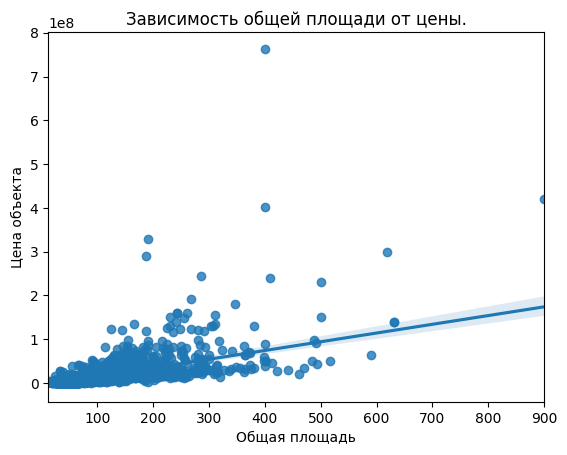

In [55]:
# Выведем коэффициент корреляции и график зависимости общих площадей от цен 
display(f"Коэффициент корреляции: {round(data['total_area'].corr(data['last_price']), 2)}")

sns.regplot(x='total_area', y='last_price', data=data)
plt.title('Зависимость общей площади от цены.')
plt.xlabel('Общая площадь')
plt.ylabel('Цена объекта');

В целом, площадь растет с возрастанием цены, а редкие выбивающиеся значения не аномальны, относятся к элитному жилью и встречаются на рынке. Оставим без изменений.

##### Проверка `rooms`
- Для объектов-студий кол-во комнат более 0 - аномальные значения. Выведем их и заменим на 0.
- Проверим записи с кол-вом комнат более 10 на аномальность.

In [56]:
# Выводим записи объектов-студий в которых кол-во комнат более 0
data.query('(studio == True) and rooms > 0')[['rooms', 'studio']]

# Выведем записи с кол-вом комнат более 10
data.query('rooms > 10')

total_images  last_price  total_area first_day_exposition  rooms  \
648               3    17500000       183.7           2018-07-01     11   
866               5    25000000       363.0           2017-12-23     14   
5349             20    65000000       590.0           2019-02-14     15   
9672              8    33000000       194.1           2017-02-07     11   
14473             6    32250000       374.6           2018-06-09     19   
18815             6    28500000       270.0           2015-03-02     16   
19505             8   420000000       900.0           2017-12-06     12   
20789             6    28659000       245.4           2016-03-31     14   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
648              3.40             7        138.8      7         False   False   
866              3.16             5        222.0      4         False   False   
5349             3.50             6        409.0      3         False   False   
9672             3.43             5        129.0      2         False   False   
14473            2.55             5        264.5      2         False   False   
18815            3.00             4        180.0      4         False   False   
19505            2.80            25        409.7     25         False   False   
20789             NaN             4        168.3      2         False   False   

       open_plan  kitchen_area  balcony    locality_name  airport_nearest  \
648        False          13.3        0  Санкт-Петербург            23606   
866        False          16.6        0  Санкт-Петербург            38076   
5349       False         100.0        0  Санкт-Петербург            24447   
9672       False          11.9        0  Санкт-Петербург            21469   
14473      False          27.6        0  Санкт-Петербург            19497   
18815      False          13.0        1  Санкт-Петербург            23575   
19505      False         112.0        0  Санкт-Петербург            30706   
20789      False          25.9        0  Санкт-Петербург            21104   

       city_center_nearest  parks_around_3000  parks_nearest  \
648                   3148                  0           <NA>   
866                   7950                  0           <NA>   
5349                  4666                  1            767   
9672                  1015                  1            686   
14473                 3574                  0           <NA>   
18815                 4142                  1            516   
19505                 7877                  0           <NA>   
20789                 2054                  3            541   

       ponds_around_3000  ponds_nearest  days_exposition  
648                    0           <NA>             <NA>  
866                    2            435              418  
5349                   0           <NA>               14  
9672                   2             66              813  
14473                  2            548              114  
18815                  0           <NA>             1365  
19505                  2            318              106  
20789                  2            118               95

In [57]:
# Заменяем значения кол-ва комнат более 0 в объектах-студиях на 0
data.loc[(data['rooms'] == 1) & (data['studio'] == True), 'rooms'] = 0
# Проверяем результат
display('Записей объектов-студий в которых кол-во комнат более 0 после замены: '
        f'{data.query("(studio == True) and rooms > 0")["rooms"].count()}')

'Записей объектов-студий в которых кол-во комнат более 0 после замены: 0'

- Значения кол-ва комнат для объектов-студий заменены на 0.
- Записи с кол-вом комнат более 10 относятся к элитному жилью и не аномальны. Оставим без изменений.

##### Проверка `ceiling_height`
Выведем диаграмму размаха для выбора проверочных срезов, исключив заранее известное аномальное значение 100:

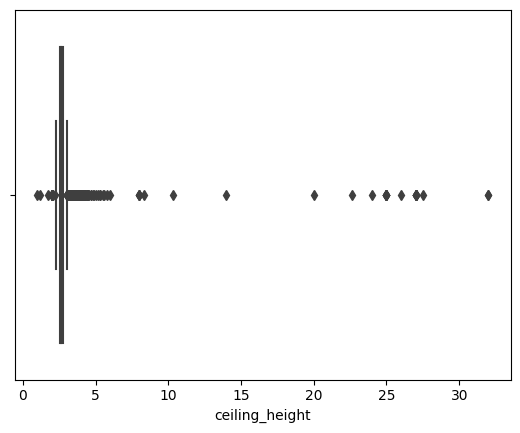

In [58]:
sns.boxplot(x='ceiling_height', data=data.query('ceiling_height < 100'));

Даже не проводя группировку, можно увидеть, что присутствуют значения менее 2м. и более 8м.. Проверим их.

###### Проверка минимальных значений:
- При проверке будем исходить из того, что минимальная высота потолка в жилых помещениях не может быть мене 2.1м в коридорах и 2.5 в комнатах (<a href="https://47.mchs.gov.ru/deyatelnost/stranicy-s-glavnoy/zakonodatelstvo/normativno-pravovye-dokumenty-po-pozharnoy-bezopasnosti/snip-31-01-2003-zdaniya-zhilye-mnogokvartirnye" target=_blanc>СНиП - многоквартирные</a>, <a href="https://47.mchs.gov.ru/deyatelnost/stranicy-s-glavnoy/zakonodatelstvo/normativno-pravovye-dokumenty-po-pozharnoy-bezopasnosti/snip-31-02-2001-doma-zhilye-odnokvartirnye" target=_blanc>СНиП - одноквартирные</a>) и указаны могут любые из них. 
<br><br>
- Также могут быть указаны высоты потолков менее 2м, так как в данных могут быть объекты с подвесными потолками и устаревшие дома не приведенные в соответствие с нормами.

In [59]:
data.query('ceiling_height < 2')

total_images  last_price  total_area first_day_exposition  rooms  \
5702              5     1500000        42.8           2017-08-14      2   
16904             5     4100000        40.0           2017-10-17      1   
22544            16     6000000        55.0           2018-10-31      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
5702             1.20             2         27.5      1         False   False   
16904            1.75            37         17.4      5         False   False   
22544            1.00            12         32.4      7         False   False   

       open_plan  kitchen_area  balcony    locality_name  airport_nearest  \
5702       False          5.20        0      посёлок Мга            44554   
16904      False          8.34        0  Санкт-Петербург            18732   
22544      False         10.00        0  Санкт-Петербург            33053   

       city_center_nearest  parks_around_3000  parks_nearest  \
5702                 46449                  0           <NA>   
16904                20444                  0           <NA>   
22544                14217                  2            293   

       ponds_around_3000  ponds_nearest  days_exposition  
5702                   0           <NA>              248  
16904                  3             80               71  
22544                  2            289               13

**Вывод:**
Удалим 3 объекта с аномальными высотами потолков, т.к. можно только предположить, что при заполнении объявления или в процессе передачи данных были совершены ошибки.

In [60]:
# Удалим 3 записи с аномальными значениями
data = data.drop(data[data['ceiling_height'] < 2].index)

# Проверим кол-во удаленных записей и кол-во значений высот потолков менее 2 после замены
display('Кол-во записей с высотой потолка менее 2м. :'
        f'{data.query("ceiling_height < 2")["ceiling_height"].count()}')
display(f'Кол-во удаленных строк: {shape_counter[0] - data.shape[0]}')
shape_counter[0] -= (shape_counter[0] - data.shape[0]);

'Кол-во записей с высотой потолка менее 2м. :0'

'Кол-во удаленных строк: 3'

###### Проверка максимальных значений:
Проанализируем отдельно записи с высотами потолков: 
1. от 8м;
2. от 9м до 20м;
3. 20м и более.

In [61]:
 display('1. Срез. Записи с высотами потолков от 8м:',
         data.query("ceiling_height >= 8"))

'1. Срез. Записи с высотами потолков от 8м:'

total_images  last_price  total_area first_day_exposition  rooms  \
355              17     3600000        55.2           2018-07-12      2   
3144             14     2900000        75.0           2018-11-12      3   
3470              3     1400000        30.0           2018-03-16      1   
4636              0     4300000        45.0           2018-02-01      2   
4868              7     3000000        25.0           2017-09-27      0   
5068              0     3850000        30.5           2018-10-03      1   
5238              0     2500000        54.0           2017-10-13      2   
5660              4     4400000        50.0           2017-08-08      2   
5797             17     8150000        80.0           2019-01-09      2   
5853             20     5650000        45.0           2018-08-15      1   
6236              6     3300000        44.4           2019-03-25      2   
9363              5     3950000        42.0           2017-03-26      3   
10755             8     3800000        58.0           2017-10-13      2   
11266             0     1950000        37.0           2019-03-20      1   
14357             9     1700000        35.0           2015-12-04      1   
15036            19     5600000        56.4           2018-05-11      2   
15717            14     5600000        67.0           2016-11-11      3   
17412             0     5350000        54.0           2015-06-16      2   
17466            15     6700000        92.9           2019-02-19      3   
17825             1     3900000        56.0           2017-12-22      3   
18512             6     3750000        43.0           2019-03-18      2   
20440            11     8000000        45.0           2017-07-18      1   
20469            12     5950000        60.0           2018-02-19      2   
21334            19     4900000        42.0           2017-04-18      1   
21780            20     2450000        44.0           2019-02-12      2   
22264            20     5300000        45.0           2017-09-30      1   
22291            19     9999000        92.4           2019-04-05      2   
22822             0    15000000        25.0           2018-07-25      1   
22890            14     4000000        98.0           2018-03-15      4   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
355              25.0             5         32.0      2         False   False   
3144             32.0             3         53.0      2         False   False   
3470              8.0             5         15.3      2         False   False   
4636             25.0             9         30.0      2         False   False   
4868             27.0            25         17.0     17         False   False   
5068             24.0             5         19.5      1          True   False   
5238             27.0             5         30.0      3         False   False   
5660             26.0             9         21.3      3         False   False   
5797             27.0            36         41.0     13         False   False   
5853              8.3            16         19.3     14         False   False   
6236             25.0             5         31.3      5         False   False   
9363             25.0             5         30.0      2         False   False   
10755            27.0            10         30.1      3         False   False   
11266            25.0             5         17.0      4         False   False   
14357            25.0             5         20.0      2         False   False   
15036            14.0            14         32.4      5         False   False   
15717             8.0            16         41.0      1         False   False   
17412             8.0             5         29.0      2         False   False   
17466            20.0            17         53.2     14         False   False   
17825            27.0             5         33.0      4         False   False   
18512            25.0             5         29.0      3

In [62]:
display('2. Срез. Записи с высотами потолков от 9м до 20м:')
data.query('9 < ceiling_height < 20')

'2. Срез. Записи с высотами потолков от 9м до 20м:'

total_images  last_price  total_area first_day_exposition  rooms  \
15036            19     5600000        56.4           2018-05-11      2   
22264            20     5300000        45.0           2017-09-30      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
15036            14.0            14         32.4      5         False   False   
22264            10.3            16         15.5     15         False   False   

       open_plan  kitchen_area  balcony    locality_name  airport_nearest  \
15036      False           9.1        2  Санкт-Петербург            14814   
22264      False           NaN        0  Санкт-Петербург            36353   

       city_center_nearest  parks_around_3000  parks_nearest  \
15036                13610                  0           <NA>   
22264                11936                  2            440   

       ponds_around_3000  ponds_nearest  days_exposition  
15036                  0           <NA>              315  
22264                  2            450              136

In [63]:
display('3. Срез. Записи с высотами потолков 20м и более:')
data.query('ceiling_height >= 20')

'3. Срез. Записи с высотами потолков 20м и более:'

total_images  last_price  total_area first_day_exposition  rooms  \
355              17     3600000        55.2           2018-07-12      2   
3144             14     2900000        75.0           2018-11-12      3   
4636              0     4300000        45.0           2018-02-01      2   
4868              7     3000000        25.0           2017-09-27      0   
5068              0     3850000        30.5           2018-10-03      1   
5238              0     2500000        54.0           2017-10-13      2   
5660              4     4400000        50.0           2017-08-08      2   
5797             17     8150000        80.0           2019-01-09      2   
6236              6     3300000        44.4           2019-03-25      2   
9363              5     3950000        42.0           2017-03-26      3   
10755             8     3800000        58.0           2017-10-13      2   
11266             0     1950000        37.0           2019-03-20      1   
14357             9     1700000        35.0           2015-12-04      1   
17466            15     6700000        92.9           2019-02-19      3   
17825             1     3900000        56.0           2017-12-22      3   
18512             6     3750000        43.0           2019-03-18      2   
20440            11     8000000        45.0           2017-07-18      1   
20469            12     5950000        60.0           2018-02-19      2   
21334            19     4900000        42.0           2017-04-18      1   
21780            20     2450000        44.0           2019-02-12      2   
22291            19     9999000        92.4           2019-04-05      2   
22822             0    15000000        25.0           2018-07-25      1   
22890            14     4000000        98.0           2018-03-15      4   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
355              25.0             5         32.0      2         False   False   
3144             32.0             3         53.0      2         False   False   
4636             25.0             9         30.0      2         False   False   
4868             27.0            25         17.0     17         False   False   
5068             24.0             5         19.5      1          True   False   
5238             27.0             5         30.0      3         False   False   
5660             26.0             9         21.3      3         False   False   
5797             27.0            36         41.0     13         False   False   
6236             25.0             5         31.3      5         False   False   
9363             25.0             5         30.0      2         False   False   
10755            27.0            10         30.1      3         False   False   
11266            25.0             5         17.0      4         False   False   
14357            25.0             5         20.0      2         False   False   
17466            20.0            17         53.2     14         False   False   
17825            27.0             5         33.0      4         False   False   
18512            25.0             5         29.0      3         False   False   
20440            27.0             4         22.0      2         False   False   
20469            22.6            14         35.0     11         False   False   
21334            27.5            24         37.7     19         False   False   
21780            27.0             2         38.0      2         False   False   
22291            32.0             6         55.5      5         False   False   
22822           100.0             5         14.0      5          True   False   
22890            27.0             2         73.0      2          True   False   

       open_plan  kitchen_area  balcony          locality_name  \
355        False           NaN        2                Гатчина   
3144       False           8.0        0                 Волхов   
4636       False           7.0        1        Санкт-Петербург 

1. Срез. Записи с высотами потолков от 8м:
 - удалим 3 записи с необъяснимыми значениями; 
1. Срез. Записи с высотами потолков от 9м до 20м:
 - **значение высоты потолка 14м.:**   указана высота дома, [типовой "пятиэтажки"](#fn1). <br>*Заменим значение на стандартную высоту потолков в таких домах - 2.5м.;*<br>
 - **значение высоты потолка 10.3м.:**   возможно, по ошибке указана площадь комнаты. <br>*Заменим значение на медианное для [этажности](#fn1) - 2.7м.;*<br><br>
2. Срез. Записи с высотами потолков 20м и более:
 - **все значения высот потолков, кроме 100м**, указаны в неверном формате. Возможно, ошибка ввода. <br>*Переведем их в формат столбца, разделив на 10.*;<br>
 - **значение высоты потолка 100м.:**   <br>*заменим значение на [стандартное](#fn1) для таких домов - 2.5м.*;<br><br>
- Для анализа успешности замены, построим графики распределения средних и мединнах высот по этажностям.

'Кол-во двузначных значений высот потолков после замены: 0'

'~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'

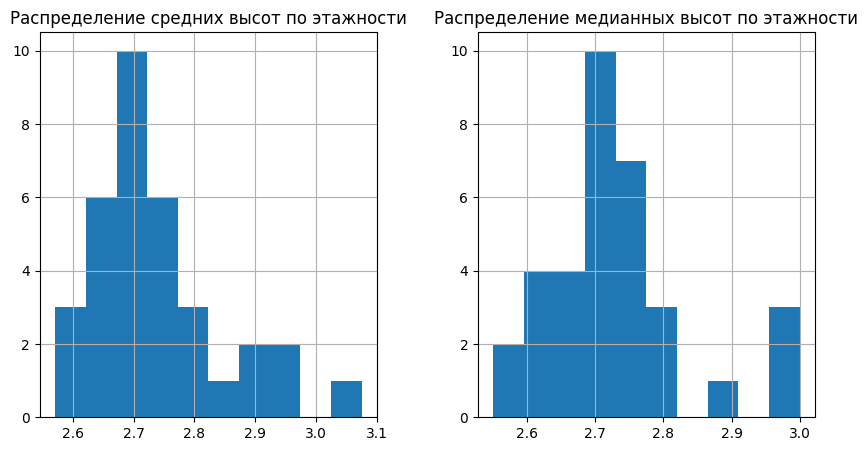

In [64]:
# Удалим значения в первом срезе
data = data.drop(data[data['ceiling_height'] >= 8].index)

# Заменим значения из первого срезе
data.loc[data['ceiling_height'] == 14, 'ceiling_height'] = 2.5
data.loc[data['ceiling_height'] == 10.3, 'ceiling_height'] = 2.7

# Заменим значения из второго среза
data.loc[data['ceiling_height'] == 100, 'ceiling_height'] = 2.5
data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] = data.loc[data['ceiling_height'] >= 20,
                                                                    'ceiling_height'].apply(lambda x: x / 10)

# Проверим кол-во двузначных значений высот потолков после замены
display('Кол-во двузначных значений высот потолков после замены: '
        f'{data.query("ceiling_height > 9")["ceiling_height"].count()}')
display('~' * 60)

# Проверка распределения высот после замен
ceiling_by_floor = data.pivot_table(index='floors_total', 
                                    values='ceiling_height', 
                                    aggfunc=['mean', 'median'])
ceiling_by_floor.columns = ['Распределение средних высот по этажности',
                            'Распределение медианных высот по этажности']

ceiling_by_floor.hist(figsize=(10, 5));

###### Выводы:
- Строки со значениями высот потолков 
 - *менее 2м. - удалены,*
 - *более 9м. - заменены.*
- Распределения средних и медианных высот потолков по этажностям приближены к нормальным.

Аномальные значения успешно обработаны.

##### Проверка `living_area` и `kitchen_area`
Построим две диаграммы размаха кол-в значений до 20м<sup>2</sup> для жилых площадей и до 10м<sup>2</sup> для площадей кухонь, чтобы определить проверочные срезы.

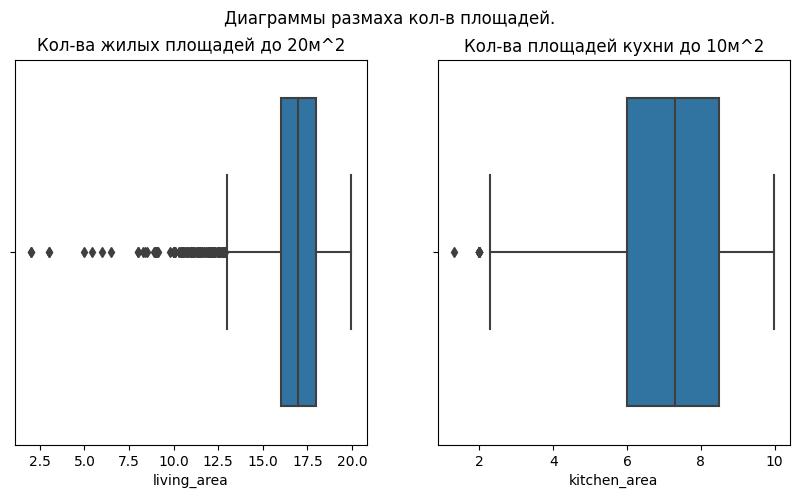

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Диаграммы размаха кол-в площадей.');
sns.boxplot(x='living_area', 
            data=data.query('living_area < 20'), ax=axes[0])
axes[0].set_title('Кол-ва жилых площадей до 20м^2')
sns.boxplot(x='kitchen_area', 
            data=data.query('kitchen_area < 10'), ax=axes[1])
axes[1].set_title('Кол-ва площадей кухни до 10м^2')
plt.show()

Судя по диаграмме в столбцах присутствуют значения вне <a href="https://47.mchs.gov.ru/deyatelnost/stranicy-s-glavnoy/zakonodatelstvo/normativno-pravovye-dokumenty-po-pozharnoy-bezopasnosti/snip-31-01-2003-zdaniya-zhilye-mnogokvartirnye" target=_blanc>минимальных установленных нормативов</a> в 8м<sup>2</sup> для жилой площади и 5м<sup>2</sup> для площади кухни. Учитывая, что в "Хрущевках" мин. площадь кухни составляет 4.5 м<sup>2</sup>, проверим эти параметры сделав срезы:
- **Срез 1:** жилые площади менее 8м<sup>2</sup>;<br> 
- **Срез 2:** площади кухонь менее 4.5м<sup>2</sup>.

In [66]:
# Выведем записи с жилыми площадями по критерию
display('Срез 1: Жилые площади менее 8м^2.')
data.query('living_area < 8')[['living_area', 'kitchen_area',
                                'total_area', 'studio',         
                                'open_plan', 'is_apartment',
                                'last_price']]

'Срез 1: Жилые площади менее 8м^2.'

living_area  kitchen_area  total_area  studio  open_plan  is_apartment  \
3238           3.0          11.0        41.0   False      False         False   
13892          2.0           9.0        52.0   False      False         False   
16404          6.0          17.0        31.0   False      False         False   
17551          5.0           NaN        22.0    True      False         False   
19216          6.5          18.0        33.0   False      False         False   
21714          2.0           NaN        23.0    True      False         False   
21898          5.4           9.8        77.6   False      False         False   
23525          3.0          16.0       139.0   False      False         False   

       last_price  
3238      4440000  
13892     6350000  
16404     3799000  
17551     2680000  
19216     4050000  
21714     2330000  
21898     6100000  
23525    64990000

###### Срез 1. Жилые площади менее 8м<sup>2</sup>:
- В объектах-студиях из-за особенностей планировки в качестве жилой может указываться площадь спальни или спального места. Такие записи оставим без изменнений.
- Единственное значение (индекс: **3242**) домножим на 10: общая площадь составляет полную сумму площадей кухни и жилой площади, умноженной на 10. Возможно, была допущена ошибка при вводе.
- Запись с площадями общей 139м<sup>2</sup> и жилой 3м<sup>2</sup> удалим, как аномальную.<br><br>
- Для остальных значений <u>проверим гипотезу</u>:
>*при вводе или передаче некоторых значений площади кухни и жилой площади<br> были допущены однотипные ошибки и значения были перепутаны местами.*

 Выведем сводную таблицу для значений жилой площади превышающих площадь кухни в 2 и более раз.

In [67]:
### Не перезапускать ячейку без перезапуска ядра ###

# Умножаем ячейку с ошибкой в вводе на 10 и выводим ее
data.loc[3242, 'living_area'] *= 10
display('Обновленная запись с ошибкой в вводе: ',
        data.loc[[3242], ['living_area', 'kitchen_area', 'total_area']])
display('~' * 60)

# Удаляем аномальную запись
data = data.drop(23574)

# Выводим и обновляем счетчик строк
display(f'Кол-во удаленных записей: {shape_counter[0] - data.shape[0]}')
shape_counter[0] -= shape_counter[0] - data.shape[0]
display('~' * 60)

# Выводим сводную таблицу значений площади кухни, превышающую жилую площадь в 2 и более раз.
display('Таблица значений площади кухни превыщающих жилую площадь в 2 и более раз:')
(data
 .query('(kitchen_area / living_area) > 2')[['living_area', 'kitchen_area',
                                             'total_area','open_plan', 'is_apartment', 
                                             'last_price']]
 .sort_values(by='living_area', ascending='False')
)

'Обновленная запись с ошибкой в вводе: '

living_area  kitchen_area  total_area
3242        301.0           6.8        51.2

'~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'

'Кол-во удаленных записей: 30'

'~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'

'Таблица значений площади кухни превыщающих жилую площадь в 2 и более раз:'

living_area  kitchen_area  total_area  open_plan  is_apartment  \
13892          2.0           9.0        52.0      False         False   
23525          3.0          16.0       139.0      False         False   
3238           3.0          11.0        41.0      False         False   
16404          6.0          17.0        31.0      False         False   
19216          6.5          18.0        33.0      False         False   
23160          8.0          22.0        37.0      False         False   
20954          8.0          31.0        50.6      False         False   
2307           8.4          41.0        62.4      False         False   
680            9.0          23.0        43.0      False         False   
1325           9.0          32.0        52.0      False         False   
22207          9.0          19.0        37.4      False         False   
21863          9.8          26.0        46.3      False         False   
10421         10.0          22.0        43.0      False         False   
19433         10.0          22.3        43.6      False         False   
16007         10.5          30.0        60.2      False         False   
2152          11.4          27.4        56.3      False         False   
15714         12.0          25.0        50.0      False         False   
511           13.0          50.0        69.0      False         False   
4069          13.3          30.5        56.6      False         False   
6933          16.4          43.4       100.7      False         False   
21289         24.3          49.4        93.4      False         False   
16767         40.0          93.0       146.0      False         False   

       last_price  
13892     6350000  
23525    64990000  
3238      4440000  
16404     3799000  
19216     4050000  
23160     4800000  
20954     8900000  
2307      4200000  
680       7200000  
1325      8100000  
22207     3340000  
21863     5300000  
10421     5900000  
19433     2450000  
16007    12900000  
2152     10800000  
15714     4800000  
511       5950000  
4069     12750000  
6933     14400000  
21289    16000000  
16767    65850000

- Еще одно значение (индекс: **13915**) можно умножить на 10: общая площадь соответствует сумме площадей кухни и жилой площади, умноженной на 10. Возможно, была допущена ошибка при вводе.<br>
- Для остальных записей <u>гипотеза подтвердилась:</u> *площади кухни и жилая, если поменять их местами, характерны для соответственных общих площадей.* Поменяем местами площадь кухни и жилую площадь, для всех случаев, когда площадь кухни превышает жилую площадь в 2 и более раз.

In [68]:
### Не перезапускать ячейку без перезапуска ядра ###

# Умножаем ячейку на 10
data.loc[13915, 'living_area'] *= 10
display('Обновленная запись с ошибкой в вводе: ',
        data.loc[[13915], ['living_area', 'kitchen_area', 'total_area']])
display('~' * 60)

# Поменяем местами площадь кухни и жилую площадь, для всех случаев, когда площадь кухни
# превышает жилую площадь в 2 и более раз.
data[['kitchen_area', 'living_area']] = (data[['kitchen_area', 'living_area']]
                                         .where((data['kitchen_area'] / 
                                                 data['living_area'] > 2) == False, 
                                                data[['living_area', 'kitchen_area']].values)
                                        )

# Выведем кол-во записей по критерию шипотезы
display('Кол-во записей по критерию гипотезы после изменений: '
f'{data.query("(kitchen_area / living_area) > 2")["living_area"].count()}')

'Обновленная запись с ошибкой в вводе: '

living_area  kitchen_area  total_area
13915        310.0          14.0        65.0

'~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'

'Кол-во записей по критерию гипотезы после изменений: 0'

###### Срез 2. Площади кухонь менее 4.5м<sup>2</sup>:
- Проверим, есть ли среди объектов студии, объекты с открытыми планировками или апартаменты. 
- Если отметок об этих типах  жилья не найдется, отметим все записи из результирующего среза как апартаменты, так как в жилых помещениях таких площадей кухонь быть не может, а для апартаментов это не редкость.

In [69]:
# Подсчет студий
display(f'Студий: {data.query("kitchen_area < 4.5")["studio"].sum()}')

# Подсчет объектов с открытой планировкой
display(f'С открытой планировкой: {data.query("kitchen_area < 4.5")["open_plan"].sum()}')

# Подсчет апартаментов
display(f'Апартаменты: {data.query("kitchen_area < 4.5")["is_apartment"].sum()}')

'Студий: 0'

'С открытой планировкой: 0'

'Апартаменты: 0'

In [70]:
display(f'Кол-во записей до замены типа на "апартаменты": {data.query("kitchen_area < 5")["is_apartment"].count()}')
# Отмечаем все записи с площадями кухнонь менее 4.5м^2 как апартаменты
data.loc[data['kitchen_area'] < 5, 'is_apartment'] = True

# Проверяем замену
display('Кол-объектов, отмеченных как апартаменты:' 
        f'{data.query("kitchen_area < 5")["is_apartment"].sum()}')

'Кол-во записей до замены типа на "апартаменты": 108'

'Кол-объектов, отмеченных как апартаменты:108'

##### **Проверка на аномальные значения - итог:**
Столбцы для проверки:
- `last_price` - мин. цена обработана;
- `total_area` - макс. площади не требуют изменений;
- `rooms` - изменены на 0 значения кол-ва комнат в объектах-студиях;
- `ceiling_height` - мин., макс и  1м. и 100м. значени обработаны;
- `living_area` - мин. значения обработаны;
- `kitchen_area` - мин. значения обработаны, перемещены значения превышающие жилую площадь вдвое.

### **Посчитайте и добавьте в таблицу новые столбцы**
- цена одного квадратного метра;
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «первый», «последний», «другой»);
- расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [71]:
# Создаем столбец с ценой одного квадратного метра округленной до целых
data['meter_price'] = round(data['last_price'] / data['total_area'], 0)

# Создаем столбец с днём недели публикации объявления
data['week_day_exposition'] = data['first_day_exposition'].dt.weekday

# Создаем столбец с месяцем публикации объявления
data['month_exposition'] = data['first_day_exposition'].dt.month

# Создаем столбец с годом публикации объявления
data['year_exposition'] = data['first_day_exposition'].dt.year

# Вводим функцию для разделения этажей объектов по группам с учетом 
# пропусков в столбце floors_total
def cat_floors(row):
    try:
        if row['floor'] == row['floors_total']:
            return 'последний'
        elif row['floor'] == 1:
            return 'первый'
        else:
            return 'другой'
    except:
        return 'другой'

# Создаем столбец с категорией этажа квартиры
data['floor_type'] = data.apply(cat_floors, axis=1)

# Создаем столбец с расстоянием до центра города в километрах
data['city_center_nearest_km'] = data['city_center_nearest'] / 1000
data['city_center_nearest_km'] = round(data['city_center_nearest_km'].astype(int), 0)

# Выводим первые 5 строк для проверки рез-тата
data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
0            2.70            16         51.0      8         False   False   
1             NaN            11         18.6      1         False   False   
2            2.55             5         34.3      4         False   False   
3             NaN            14          NaN      9         False   False   
4            3.03            14         32.0     13         False   False   

   open_plan  kitchen_area  balcony    locality_name  airport_nearest  \
0      False          25.0        0  Санкт-Петербург            18863   
1      False          11.0        2   посёлок Шушары            12817   
2      False           8.3        0  Санкт-Петербург            21741   
3      False           NaN        0  Санкт-Петербург            28098   
4      False          41.0        0  Санкт-Петербург            31856   

   city_center_nearest  parks_around_3000  parks_nearest  ponds_around_3000  \
0                16028                  1            482                  2   
1                18603                  0           <NA>                  0   
2                13933                  1             90                  2   
3                 6800                  2             84                  3   
4                 8098                  2            112                  1   

   ponds_nearest  days_exposition  meter_price  week_day_exposition  \
0            755             <NA>     120370.0                    3   
1           <NA>               81      82921.0                    1   
2            574              558      92786.0                    3   
3            234              424     408176.0                    4   
4             48              121     100000.0                    1   

   month_exposition  year_exposition floor_type  city_center_nearest_km  
0                 3             2019     другой                      16  
1                12             2018     первый                      18  
2                 8             2015     другой                      13  
3                 7             2015     другой                       6  
4                 6             2018     другой                       8

### **Проведите исследовательский анализ данных**

**Изучаемые параметры:**
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.

#### Предварительный анализ взаимосвязей изучаемых параметров.:

Для предварительного анализа зависимостей, выведем матрицу диаграм рассеяния* для всех рассматриваемых параметров, без учёта пропусков, столбцов где их больше всего (расстояний) и категориальных данных.
<br><br>**Выведем матрицу для параметров:**
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- общее количество этажей в доме.


> \*Примечание: *для датасетов большего размера, оценить взаимосвязи можно, визуализировав таблицу корреляции с помощью функции seaborn.heatmap(), или других методов.*

'Процент рассматриваемых данных от общего кол-ва: 73.00%'

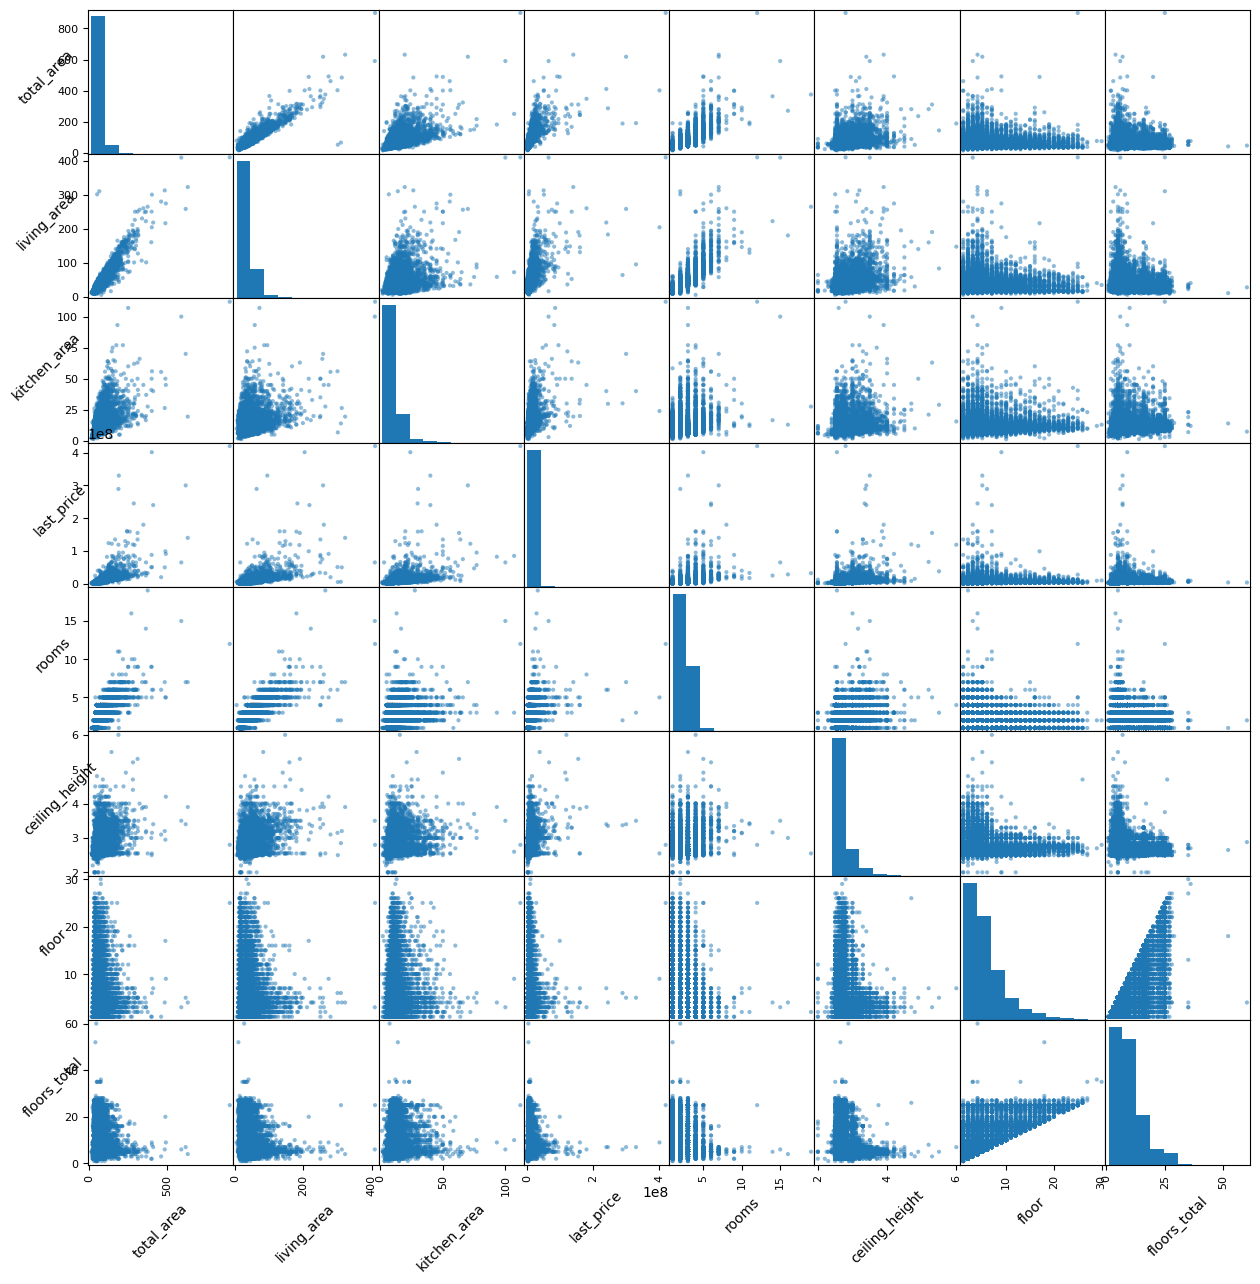

In [72]:
#Время выполнения ячейки 9.54с

# Список параметров для построения матрицы
columns_to_matrix = ['total_area', 'living_area',
                     'kitchen_area', 'last_price',
                     'rooms', 'ceiling_height', 
                     'floor', 'floors_total']

# Для предварительной оценки, используем только записи с заполненными ячейками
data_preliminary = data[columns_to_matrix].dropna()

# Выведем процент рассматриваевых джанных
display('Процент рассматриваемых данных от общего кол-ва: '
        f'{round(len(data_preliminary) / len(data), 2):.2%}')

# Построим матрицу
axes = pd.plotting.scatter_matrix(data_preliminary[columns_to_matrix], figsize=(15, 15))
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(45)
# plt.show()

**Предварительный вывод:**
- Анализируя матрицу рассеяния, можно сказать, что:
 - в данных присутствуют элитные объекты, т.е. выбросы, которые мы видим в матрице.
 - общая площадь ожидаемо прямо связана и растет вместе с жилой, площадью кухни, кол-вом комнат, а также высотой потолков, этажём и этажностью до определенных значений последних трёх величин;
 - цена объекта, за исключением выбросов, прямо связана и растет с его площадями, высотой потолка, кол-вом комнат, а также, этажём и этажностью, до определенных значений последних двух величин;
 - этаж объекта ожидаемо растет с увеличением этажности.<br><br>

**План анализа:**
- Учитывая присутствие некоторого ко-ва выбросов рассмотрим все параметры по следующей схеме:
 - разделим нас. пункты на Санкт-Петербург и города Ленинградской области и создадим соответствующий столбец-классификатор;
 - введем функцию поиска предельных нормальных значений, "усов" диаграмм размаха, для нахождения оптимальных диапазонов для анализа;
 - введем функцию для вывода гистограмм, графиков размаха, графика изменений значений по годам и статистики в цифрах для каждого параметра по всем данным и по диапазонам нормальных значений для всех данных и для Санкт-Петербурга и Лен. области отдельно.<br><br>
- Анализировать параметры будем по 
  - графикам общего рапределения параметра в данных;
  - уточненным графикам распределения, построенным в пределах нормальных значений с описанием данных, не вошедших в уточненное распределение.

In [73]:
# Словарь названий столбцов на русском
names_rus = {'total_area' : 'Общая площадь.',
             'living_area' : 'Жилая площадь.',
             'kitchen_area' : 'Площадь Кухни.',
             'last_price' : 'Цена.',
             'last_price_mil' : 'Цена в млн.р.',
             'rooms' : 'Количество комнат.',
             'ceiling_height' : 'Высота потолков.',
             'floor' : 'Этаж.',
             'floor_type' : 'Тип этажа.',
             'floors_total' : 'Этажность',
             'city_center_nearest' : 'Расстояние до центра города.',
             'airports_nearest' : 'Расстояние до аэропорта.',
             'parks_nearest' : 'Расстояние до парка.',
             'week_day_exposition' : 'День публикации объявления.',
             'month_exposition' : 'Месяц публикации объявления.',
             'days_exposition' : 'Длительность публикации объявления.',
             'year_exposition' : 'Год публикации объявления.'}

# Разделим нас. пункты на Санкт-Петербург и Лен. Область.
data['locality_type'] = data['locality_name'].where(data['locality_name'] == 
                                                    'Санкт-Петербург', 'Лен. Область')

### Функции:

# Введем функцию нахождения мин. макс. нормальных значений, - усов диаграммы размаха
def get_whiskers(column):
    distr = column.describe()
    distr_iqr = distr[6] - distr[4]
    whisker_upp = distr[6] + 1.5 * distr_iqr
    whisker_low = distr[4] - 1.5 * distr_iqr
    if whisker_upp >= distr[7]:
        whisker_upp = distr[7]
    if whisker_low <= distr[3]:
        whisker_low = distr[3]
    return [round(whisker_low, 0), round(whisker_upp, 0)]


# Введем функцию для вывода гистограмм, графиков размаха, графика изменений по годам
# и статистики в цифрах для столбца
def get_stats(column):
    column_name = column.name
    
    # Запишем усы графиков в переменные
    lim_top_all = get_whiskers(data[column_name])[1]
    lim_top_piter = get_whiskers(data.query('locality_type == "Санкт-Петербург"')[column_name])[1]
    lim_top_oblast = get_whiskers(data.query('locality_type == "Лен. Область"')[column_name])[1]
    
    # Запишем в переменные в процентах кол-во значений в уточненном распределении от общего кол-ва значений
    values_left_all = '{:.0%}'.format(round(len(data.query('@column <= @lim_top_all')[column.name]) /
                                            len(data[column.name]), 4))
    values_left_piter = '{:.0%}'.format(round(len(data.query('@column <= @lim_top_piter')[column.name]) / 
                                            len(data[column.name]), 4))
    values_left_oblast = '{:.0%}'.format(round(len(data.query('@column <= @lim_top_oblast')[column.name]) / 
                                            len(data[column.name]), 4)) 
    
    # Графики по общему распределению параметров
    fig, axes = plt.subplots(2, 2, figsize=(15, 7))
    fig.suptitle(f'1. {names_rus[column.name]} Распр. по всем нас. пунктам за весь период.')
    
    sns.histplot(x=column.name, data=data, ax=axes[0, 0])
    axes[0, 0].set_title(f'1.1 {names_rus[column.name]}')
    sns.histplot(x=column.name, data=data.query('@column <= @lim_top_all'), 
                 bins=round(lim_top_all), ax=axes[0, 1])
    axes[0, 1].set_title(f'1.2 Распр. в пределах норм. значений. До {lim_top_all}. {values_left_all}')
    
    sns.boxplot(x=column.name, data=data, ax=axes[1, 0])
    sns.boxplot(x=column.name, data=data.query('@column <= @lim_top_all'), ax=axes[1, 1])
    
    # Уточненные графики по нас. пунктам, построенные в пределах нормальных значений общего распределения
    fig, axes = plt.subplots(2, 2, figsize=(15, 7))
    fig.suptitle(f'2. {names_rus[column.name]} Распр. по нас. пунктам за весь период.')
    
    sns.histplot(x=column.name, 
                 data=data.query('locality_type == "Санкт-Петербург" and @column <= @lim_top_piter'),
                 bins=round(lim_top_piter), ax=axes[0,0])
    axes[0,0].set_title(f'2.1. Санкт-Петербург. До {lim_top_piter}. {values_left_piter}')
    
    sns.histplot(x=column.name, 
                 data=data.query('locality_type == "Лен. Область" and @column <= @lim_top_oblast'), 
                 bins=round(lim_top_oblast), ax=axes[0,1])
    axes[0,1].set_title(f'2.2 Лен. Область. До {lim_top_oblast}. {values_left_oblast}')
    
    sns.boxplot(x=column.name, 
                data=data.query('locality_type == "Санкт-Петербург" and @column <= @lim_top_piter'), 
                ax=axes[1, 0])
    sns.boxplot(x=column.name, 
                data=data.query('locality_type == "Лен. Область" and @column <= @lim_top_oblast'), 
                ax=axes[1, 1])

    plt.show()
    
    # Таблица распределений в цифрах
    display(pd.DataFrame
            (data = 
             {f'1.1 Без ограничений.' : 
              (data[column.name].describe()), 
              f'1.2 До {lim_top_all}.' : 
              data.query('@column <= @lim_top_all')[column.name].describe(),
              f'2.1 Санкт-Петербург. До {lim_top_piter}': 
              data.query('locality_type == "Санкт-Петербург" and @column <= @lim_top_piter')[column.name].describe(),
              f'2.2 Лен. Область. До {lim_top_oblast}': 
              data.query('locality_type == "Лен. Область" and @column <= @lim_top_oblast')[column.name].describe()})
            .style.set_caption(f'{names_rus[column.name]} Распределение за весь период в цифрах.')
            .set_table_styles(styles)
           )
    
# Функция построения графика изменения параметра по всем данным по типу нас. пункта во времени
def get_graph_time(column):
    year_locality = data.pivot_table(index=['locality_type', 'year_exposition'], 
                                     values=column.name, aggfunc='mean')
    year_locality.columns = ['column_mean']
    year_locality = year_locality.reset_index()

    sns.relplot(data=year_locality, kind='line', x='year_exposition', 
                y='column_mean', hue='locality_type',
    height=4, facet_kws={'sharey': False, 'sharex': True})
    plt.title(f'3. {names_rus[column.name]} Изменение среднего по годам.')
    plt.xlabel('Годы')
    plt.ylabel(names_rus[column.name]);
    
    plt.show()

##### Общая площадь.

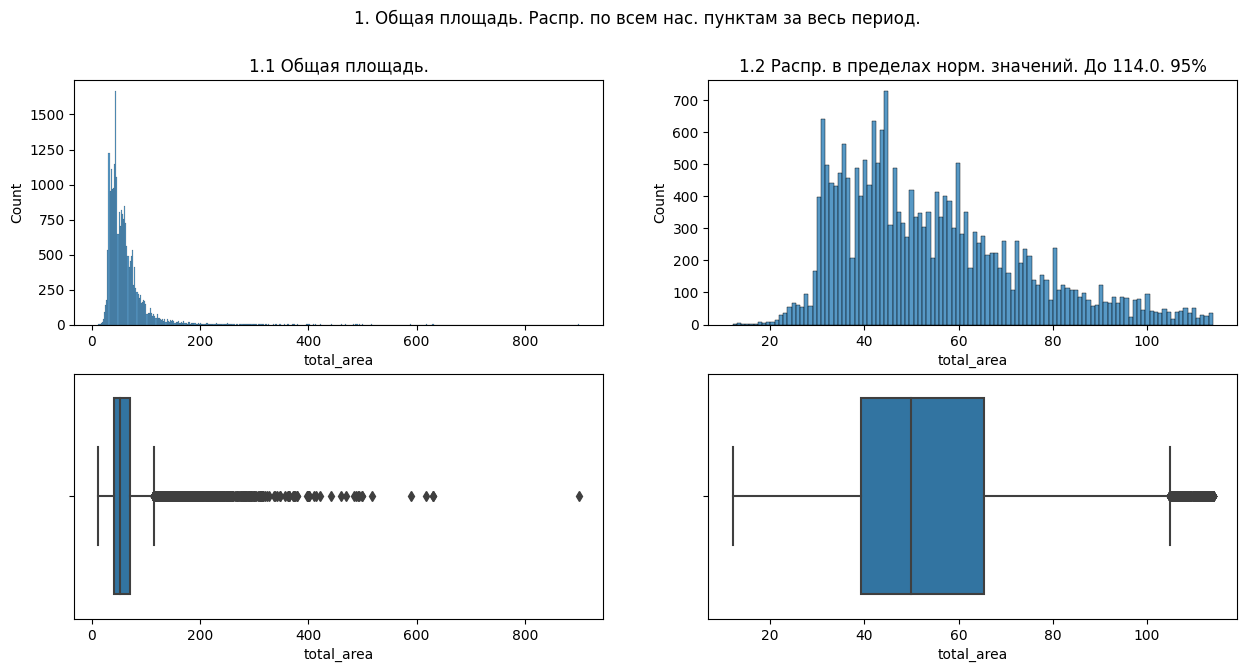

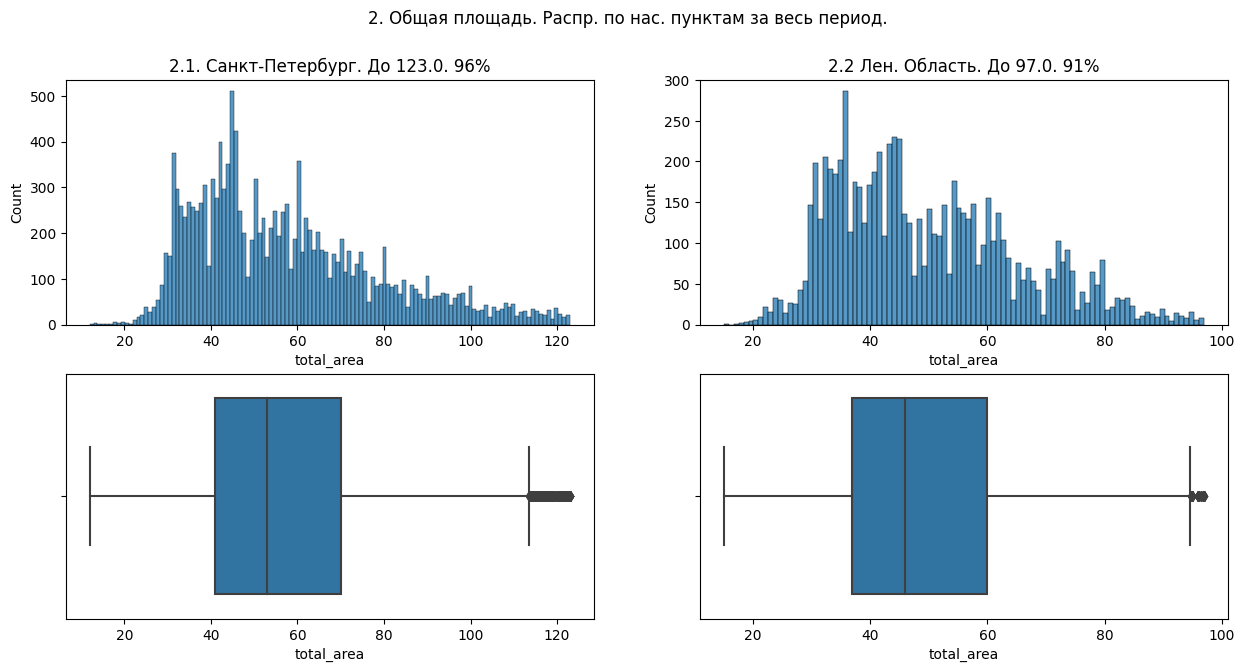

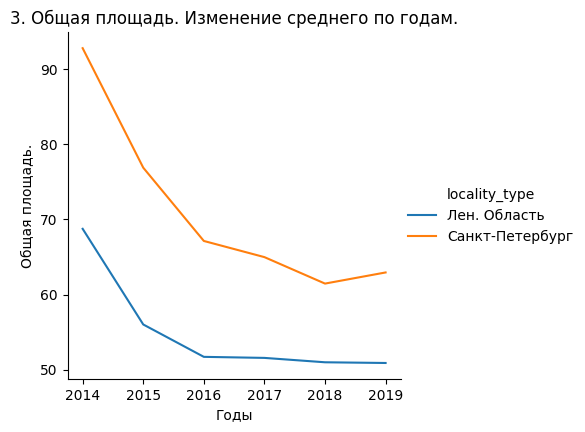

'~~~~~~~~~~~~~~~~~~~~'

'Кол-во объявлений по годам:'

year_exposition
2014     136
2015    1169
2016    2759
2017    8154
2018    8476
2019    2837
Name: total_area, dtype: int64

In [74]:
# Выведем графики и таблицы
get_stats(data['total_area'])

get_graph_time(data['total_area'])

display('~' * 20)

# Выведем кол-во объявлений по годам, для анализа графика распределения данных по времени
display('Кол-во объявлений по годам:', 
        data.groupby('year_exposition')['total_area'].count())

###### Выводы.
- **1.1 Общая площадь по всем данным за весь период:**<br>
  *(Распределение имеет тяжелый правый хвост, что говорит о небольшом кол-ве квартир с большой общей площадью и подтверждает необходимость уточнения.)*
  - Разброс площадей в данных - от 12 до 900 м<sup>2</sup>;<br>
    *На площадке Яндекс.Недвижимость представлен широкий спектр объектов от "микроквартир", набирающих популярность в последние годы, до штучных элитных объектов. И тех и других небольшое кол-во, но их присутствие позволяет говорить о хорошей репрезентативности данных.*<br>
  - Объектов с площадью более 114м<sup>2</sup> всего 5%;<br>
    *Квартиры с площадью более 114м<sup>2</sup> метров, скорее, редкость на площадке, а с площадью более 200м<sup>2</sup> единичны, что закономерно.*<br>
  - Основная часть объявлений приходится на площади от 12 до 114 м<sup>2</sup>.<br><br>
- **1.2 Распределение в пределах нормальных значений. Общая площадь до 114м<sup>2</sup>:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных. Имеет нормальное распределение Гаусса.)*
  - Квартиры с площадьюдо до 114м составляют 95% от всех объектов, среди них самый большой выбор, что соответствует логике:<br>
   _"микроквартиры" не так комфортны и, соответственно, востребованы, чтобы присутствовать в большых кол-вах, небольшие студии не подходят для семей, а элитное жильё редко_;<br>  
  - Пик в районе 30-33 м<sup>2</sup> соответствует типовым планировкам маленьких 32-33 метровых 2-ух комнатных и 30 метровых однокомнатных квартир советской постройки;
  - Пики в районе 40-45 м<sup>2</sup> - типовым 2-ух комнатным квартирам советского времени, или, по крайней мере, увеличиваются ими;
  - Пик на 60 м<sup>2</sup>, скорее всего, отображает общую распространенность такого метража в домах разных лет постройки в разных планировках.<br><br>
  
- **2.1 Распределение в пределах нормальных значений. Санкт-Петербург. До 123 м<sup>2</sup>:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных для Санкт-Петербурга. Близок к нормальному распределению Гаусса.)*
  - Разброс нормальных значений 12 - 123м <sup>2</sup>, - чуть больше чем в общих данных, что, скорее всего, означает, что в Санкт-Петербурге больше квартир большей площади, чем в Лен. области;
  - Квартиры с площадью до до 123 м<sup>2</sup> составляют 96% от всех объектов; <br>
  - Картина с пиками идентична гистограмме по общим данным;
  - Средняя квартира имеет медианную общую площадь - 53 м<sup>2</sup>.<br><br>
- **2.2 Распределение в пределах нормальных значений. Ленинградская область:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных для Лен. области. Близок к нормальному распределению Гаусса.)*
  - Разброс нормальных значений 15 - 97м <sup>2</sup>, - меньше чем в Санкт-Петербурге, что соответствует данным таблицы распределений о меньшей средней общей площади квартир в Лен. области;
  - Квартиры с площадью до 97 м<sup>2</sup> составляют 91% от всех объектов;<br>
  - Высокая плотность гистограммы от 30 до 80 м<sup>2</sup> и разряженность после 80 м<sup>2</sup>, в отличие от гистограммы по Санкт-Петербургу еще раз подтверждают гипотезу о меньшей средней площади в Лен. области по сравнению с городом;
  - Средняя квартира имеет медианную общую площадь - 46 м<sup>2</sup>.<br><br>
<span id="fn7">
- **3. Общая площадь. Изменение по годам.**<br>
  *(График построен по всем данным за весь период.)*<br> 
  График демонстрирует снижение медианной площади продаваемых квартир как в Санкт-Петербурге так и в Лен. области. <br>
  Такому поведению кривых можно предположить несколько причин:
  - Основной причиной, скорее вего, является переход сервиса Яндекс.Недвижимость от агрегации объявлений с других площадок к  самостоятельному показу объявлений (<a href="https://realty.rbc.ru/news/577d23ca9a7947a78ce91950" target=_blank>к концу 2014г. аудитория приблизилась к 2 млн. пользователей</a>);
  - Второй причиной стал финансовый кризис 2014 г., вызвавший сильное падение спроса на недвижимость, особенно на вторичном рынке, в совокупности с увеличением предложения на первичном, в частности, ипотечных квартир;<br>
  - Можно также предположить, что частично снижение площади становится результатом постепенного отторжения продавцами и рынком устаревшего малогабаритного жилья, объем которого на рынке растет:
    - покупатели, имеющие доступ к льготам преобретают ипотечное жилье в новостройках с большей площадью;
    - покупатели, уже живущие в малогабаритных квартирах, со временем улучшают условия;<br>
  (_Несмотря на то, что в Санкт-Петербурге проходит <a href="https://www.gov.spb.ru/helper/sod_fonda/jilie/formy-obespecheniya-zhilem/rzt/" target=_blank>реновация</a> типового жил. фонда 1958-1970 гг. и малоэтажных домов до 1968г., до её завершения и сноса всех устаревших домов, рынок будет насыщен малогабаритными квартирами._)<br><br>


- **Общая площадь - выводы:**
 - Общее распределение позволяет сказать, что 
   - основная часть объявлений приходится на площади от 12 до 114 м<sup>2</sup>;
   - медианная площадь квартиры в объявлении 52 м<sup>2</sup>;
   - большие и элитные квартиры с общей площадью от 114 м<sup>2</sup> составляют 5% от общего предложения.
 - Санкт-Петербург:
   - подавляющее большинство объектов имеют общую площадь от 12 до 123 м<sup>2</sup>;
   - средняя квартира имеет медианную общую площадь - 53 м<sup>2</sup>.
 - Лен. область:
   - подавляющее большинство объектов имеют общую площадь от 15 до 97 м<sup>2</sup>;
   - средняя квартира имеет медианную общую площадь - 46 м<sup>2</sup>.

##### Жилая площадь.

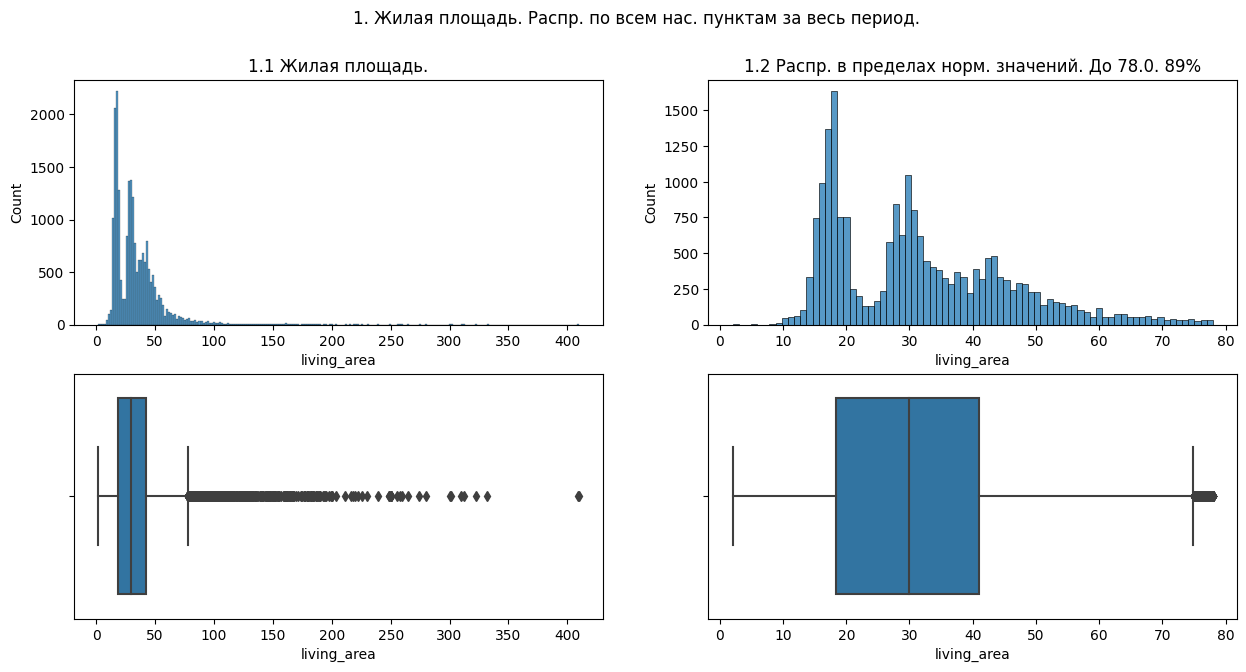

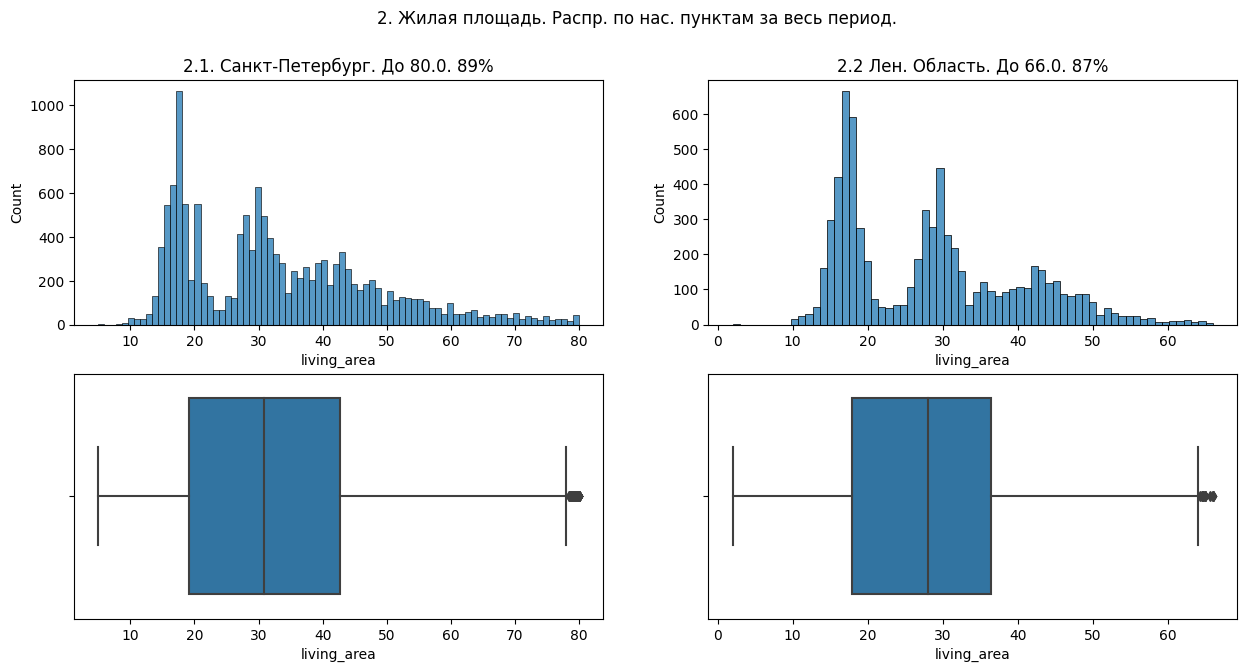

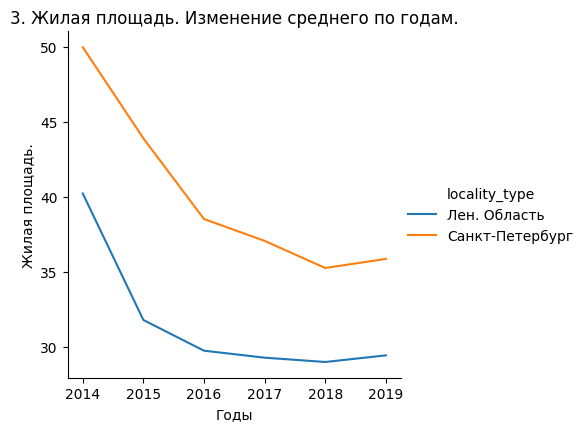

In [75]:
# Выведем графики и таблицу
get_stats(data['living_area'])
get_graph_time(data['living_area'])

###### Выводы.
- **1.1 Жилая площадь по всем данным за весь период:**<br>
  *(Распределение имеет тяжелый правый хвост, что говорит о небольшом кол-ве квартир с большой площадью и подтверждает необходимость уточнения.)*
  - Так как предварительно была выявлена корреляция между площадями квартиры, многие выводы повторяются.<br>  
  - Разброс площадей в данных - от 2 до 409.7 м<sup>2</sup>;<br>
  - Объектов с площадью более 78м<sup>2</sup> - 11%;<br>
    *Квартиры с жилой площадью более 78м<sup>2</sup> метров, скорее, редкость на площадке, а с жилой площадью более 100м<sup>2</sup> единичны, что закономерно и повторяет ситуацию с общей площадью.*<br>
  - Основная часть объявлений приходится на жилую площадь от 2 до 78 м<sup>2</sup>.<br><br>
- **1.2 Распределение в пределах нормальных значений. Жилая площадь до 78 м<sup>2</sup>:**<br>
  *(Графики построены в пределах нормальных значений (усов диаграммы размаха) общих данных. Имеет нормальное распределение Гаусса.)*
  - Квартиры с площадьюдо до 78 м<sup>2</sup> составляют 89% от всех объектов, среди них самый большой выбор; <br>  
  - Пик в районе 17 м<sup>2</sup> соответствует типовым планировкам маленьких 32-33 метровых 2-ух комнатных и 30 метровых однокомнатных квартир советской постройки;
  - Пики в районе 30 м<sup>2</sup> - типовым 2-ух комнатным квартирам советского времени, или, по крайней мере, увеличиваются ими;<br><br>
  
- **2.1 Распределение в пределах нормальных значений. Санкт-Петербург. До 80 м<sup>2</sup>:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных для Санкт-Петербурга. Близок к нормальному распределению Гаусса.)*
  - Разброс нормальных значений 5 - 80м <sup>2</sup>, - чуть больше чем в общих данных, что, скорее всего, означает, что в Санкт-Петербурге больше квартир большей площади, чем в Лен. области;
  - Квартиры с жилой площадью до до 80 м<sup>2</sup> составляют 89% от всех объектов; <br>
  - Картина с пиками идентична гистограмме по общим данным;
  - Средняя квартира имеет медианную жилую площадь - 31 м<sup>2</sup>.
 <br><br>
- **2.2 Распределение в пределах нормальных значений. Ленинградская область:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных для Лен. области. Близок к нормальному распределению Гаусса.)*
  - Разброс нормальных значений 2 - 66м <sup>2</sup>, - меньше чем в Санкт-Петербурге, что подверждает гипотезу о меньшей средней общей площади квартир в Лен. области;
  - Квартиры с площадью до 66 м<sup>2</sup> составляют 87% от всех объектов;<br>
  - Просматривается спад после 30 м<sup>2</sup> и малое кол-во квартир с жилой площадью более 50 м<sup>2</sup>;
  - Средняя квартира имеет медианную жилую площадь - 28 м<sup>2</sup>.<br><br>
  
- **3. Общая площадь. Изменение по годам.**<br>
  *(График построен по всем данным за весь период.)*
  График еще раз косвенно подверждает очевидную корреляцию между обшей и жилой площадями.<br>
  <br><br>


- **Жилая площадь - выводы:**
 - Общее распределение позволяет сказать, что 
   - основная часть объявлений приходится на площади от 2 до 78 м<sup>2</sup> 
   - медианная жилая площадь квартиры в объявлении 30 м<sup>2</sup>;
   - большие и элитные квартиры с жилой площадью от 78 м<sup>2</sup> составляют 11% от общего предложения.
 - Санкт-Петербург:
   - подавляющее большинство объектов имеют жилую площадь от 5 до 80 м<sup>2</sup>;
   - средняя квартира имеет медианную жилую площадь - 31 м<sup>2</sup>.
 - Лен. область:
   - подавляющее большинство объектов имеют жилую площадь от 2 до 66 м<sup>2</sup>;
   - средняя квартира имеет медианную площадь - 28 м<sup>2</sup>.

##### Площадь кухни.

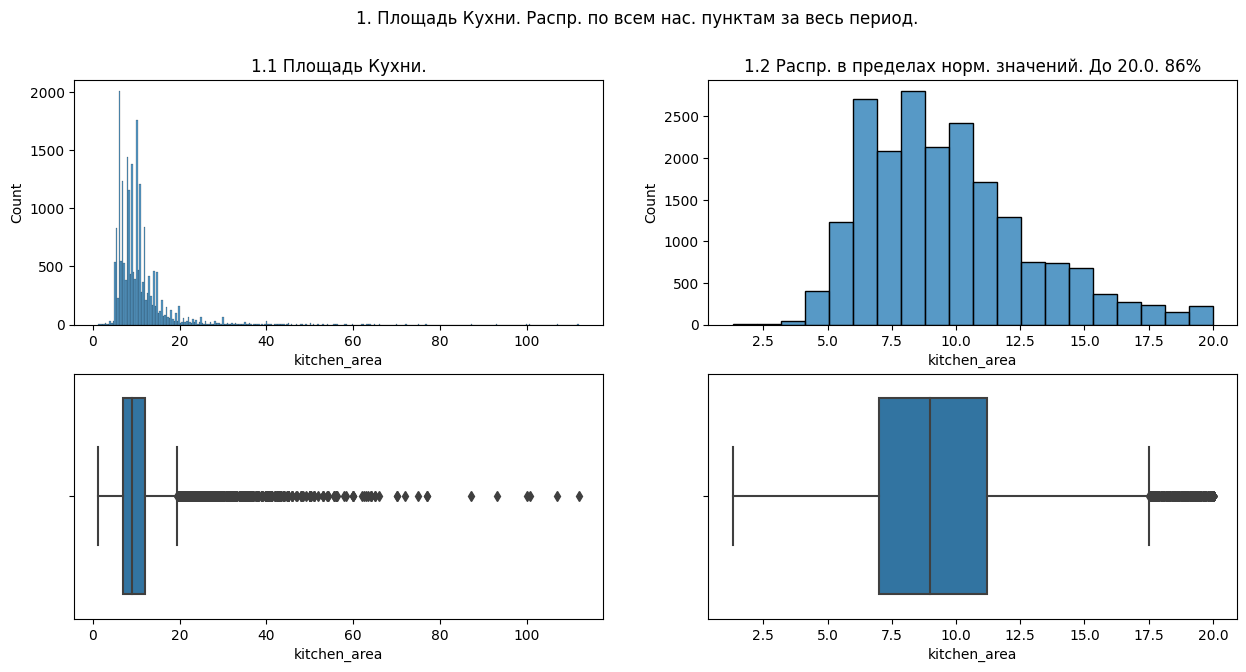

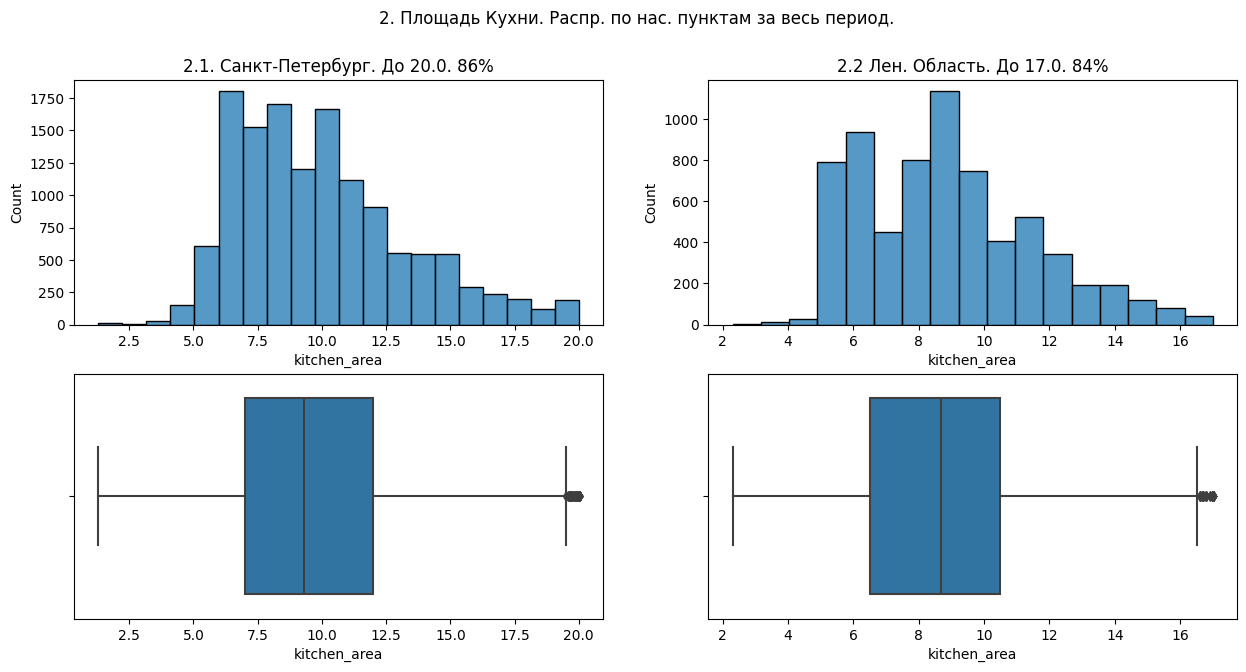

In [76]:
# Выведем графики и таблицу
get_stats(data['kitchen_area'])

###### Выводы.
- **1.1 Площадь кухни по всем данным за весь период:**<br>
  *(Распределение имеет тяжелый правый хвост, что говорит о небольшом кол-ве квартир с большой площадью кухни и подтверждает необходимость уточнения.)*
  - Так как предварительно была выявлена корреляция между характеристиками квартиры, многие выводы повторяются.<br>  
  - Разброс площадей в данных - от 1.3 до 112 м<sup>2</sup>;<br>
  - Объектов с площадью более 20м<sup>2</sup> всего 14%;<br>
  - Основная часть объявлений приходится на площадь кухни от 1.3 до 20 м<sup>2</sup>.<br><br>
- **1.2 Распределение в пределах нормальных значений. Площадь кухни до 20 м<sup>2</sup>:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных. Имеет нормальное распределение Гаусса.)*
  - Квартиры с площадьюдо кухни до 20 м<sup>2</sup> составляют 86% от всех объектов, среди них самый большой выбор; <br> 
  - Основное сосредоточение значений приходится на интервал от 4.5 до 12.5  м<sup>2</sup>, который соответствует площадям кухонь в типовых домах.<br><br>
  
- **2.1 Распределение в пределах нормальных значений. Санкт-Петербург. До 20 м<sup>2</sup>:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных для Санкт-Петербурга. Близок к нормальному распределению Гаусса.)*
  - Разброс нормальных значений 1.3 - 20м <sup>2</sup>. Нижний предел меньше, чем в области, что говорит о большем кол-ве студий и/или апартаментов с маленькими кухнями или "кухонными зонами" в Санкт-Петербурге;
  - Квартиры с площадью кухни до 20 м<sup>2</sup> составляют 86% от всех объектов; <br>
  - Средняя квартира имеет медианную площадь кухни - 9 м<sup>2</sup>.<br><br>
- **2.2 Распределение в пределах нормальных значений. Ленинградская область:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных для Лен. области. Близок к нормальному распределению Гаусса.)*
  - Разброс нормальных значений 2.3 - 17м <sup>2</sup>, - максимум меньше чем в Санкт-Петербурге, что еще раз подверждает гипотезу о меньшей средней площади квартир в Лен. области;
  - Квартиры с площадью кухонь до 17 м<sup>2</sup> составляют 84% от всех объектов;<br>
  - Просматривается спад после 12 м<sup>2</sup>;
  - Средняя квартира имеет медианную площадь кухни - 8.7 м<sup>2</sup>.<br><br>

- **Общая площадь - выводы:**
 - Общее распределение позволяет сказать, что 
   - основная часть объявлений приходится на площади от 1.3 до 20 м<sup>2</sup> 
   - медианная площадь кухни в объявлении 9.1 м<sup>2</sup>;
  - Санкт-Петербург:
   - подавляющее большинство объектов имеют площадь кухни от 1.3 до 20 м<sup>2</sup>;
   - средняя квартира имеет медианную площадь кухни - 9.3 м<sup>2</sup>.
 - Лен. область:
   - подавляющее большинство объектов имеют площадь кухни от 2.3 до 17 м<sup>2</sup>;
   - средняя квартира имеет медианную площадь кухни - 8.7 м<sup>2</sup>.

##### Цена объекта.
Для улучшения читаемости графиков, создадим столбец и переведём в него цены объектов в млн. р.

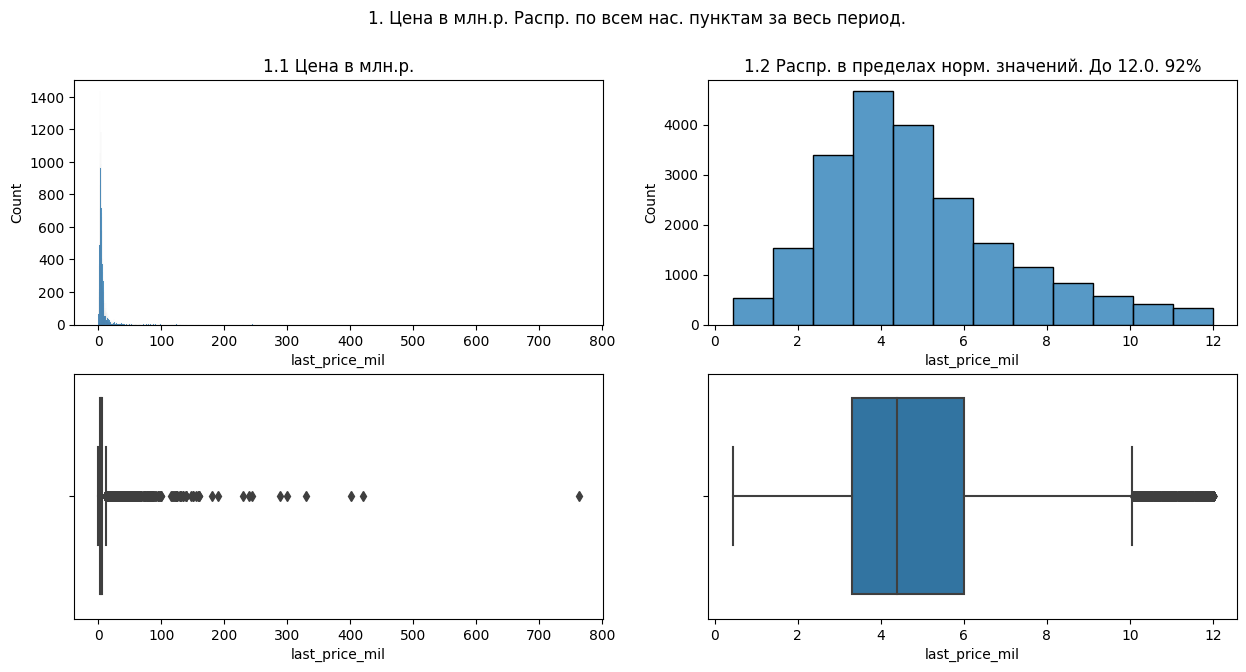

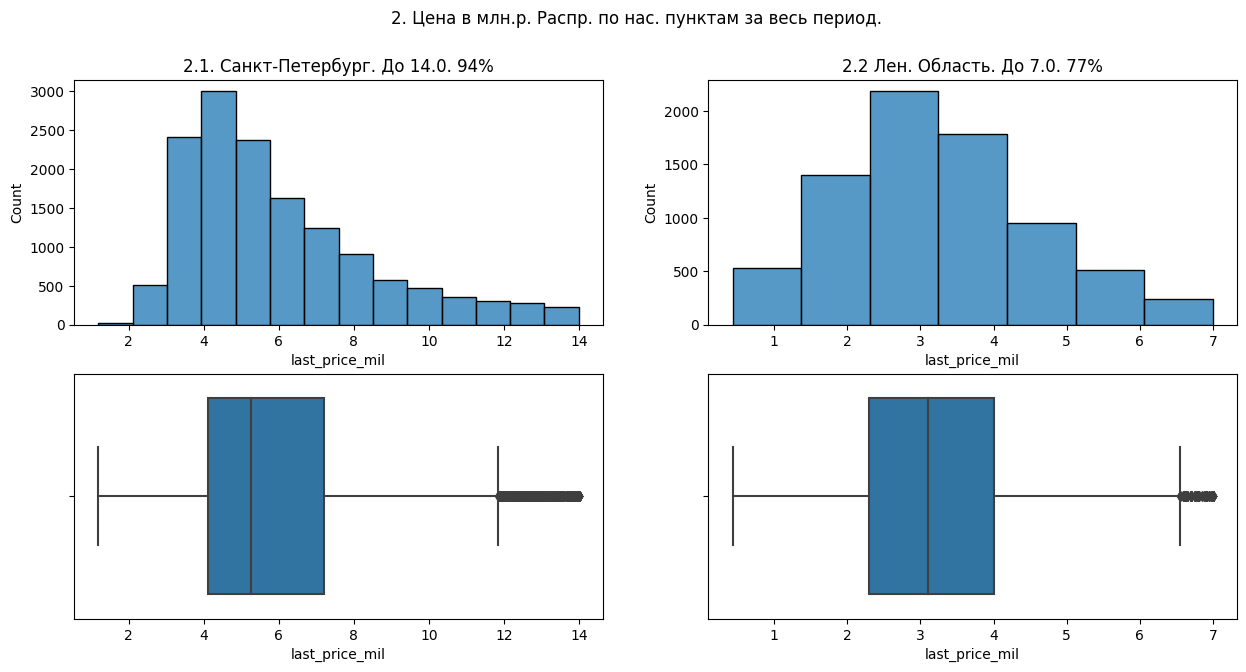

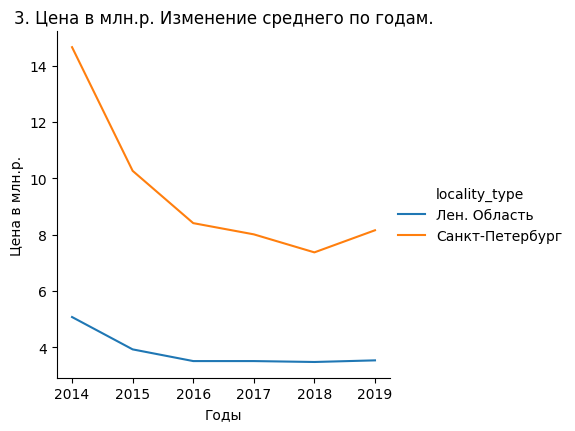

In [77]:
# Создадим новый столбец и поместим в него значения столбца 
# last_price в формате млн.р.
data['last_price_mil'] = data['last_price'] / 1000000

# Выведем графики и таблицу
get_stats(data['last_price_mil'])
get_graph_time(data['last_price_mil'])

###### Выводы.
- **1.1 Цена в млн.р. по всем данным за весь период:**<br>
  *(Данные на гистограмме практически не различимы из-за небольшого кол-ва дорогих объектов. Уточним выборку, описав и исключив такие объекты.)*
  - Разброс цен в данных - от 430 тыс.р. до 763 млн.р.;<br><br>


- **1.2 Распределение в пределах нормальных значений. До 12 млн.р.**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных. Имеет нормальное распределение Гаусса.)*
  - Графики демонстрируют, что объявления делятся на:
    - дорогие и элитные квартиры с ценами выше 12 млн.р., которых в выборке - 8%;
    - квартиры с ценами от 430тыс.р. до 12 млн.р. (92%), из которых представлены наиболее широко объекты с ценами 2 - 8 млн.р.,  что приближенно соответствует рыночной цене за м<sup>2</sup> для рассматриваемого временного интервала: <br>
>_В январе 2014, цена за м<sup>2</sup> <a href="https://www.bn.ru/analytics/" target=_blank>составляла</a> ~96000 и 91000 тыс.руб. на на вторичном и первичном рынках соответственно._
<br><br>  
- **2.1 Распределение в пределах нормальных значений.  Санкт-Петербург. До 14 млн. р.:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных для Санкт-Петербурга. Близок к нормальному распределению Гаусса.)*
  - Разброс нормальных значений 1.19 - 14 млн.р. (94%). Квартиры с ценой более 14 млн.р. , скорее, редкость на рынке, а с ценой более 30 млн.р. единичны.;
  - Медианная цена (5.25 млн.р.) более чем на 2 млн.р. превышает аналогичную в Лен. Области, а средняя (6 млн.р.) на более чем 2.5 млн.р., что говорит о большем кол-ве дорогих квартир в Санкт-Петербурге;
  
- **2.2 Распределение в пределах нормальных значений. Квартиры Ленинградской области:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных для Лен. области. Близок к нормальному распределению Гаусса.)*
  - Разброс нормальных значений 430 тыс.р. - 7 млн.р.;
  - Квартиры с ценами до 7 млн.р. составляют 77% от всех объектов, что говорит о меньшей однородности объектов в Лен. Области по сравнению с городом;
  - Медианная цена квартиры - 3.1 м<sup>2</sup>.<br><br>
  
- **3. Общая площадь. Изменение по годам.**<br>
  *(График построен по всем данным за весь период.)*
  Возможные причины снижения цен перечислены в разделе ["Общая площадь"](#fn7)
  <br><br>

- **Цены - выводы:**
  - Санкт-Петербург:
   - подавляющее большинство (92%) объектов имеют цены от 1.19 до 14 млн.р.;
   - средняя квартира имеет медианную цену - 5.25 млн.р.;
 - Лен. область:
   - большинство (77%) объектов имеют цены от 430 тыс.р. до 7 млн.р.;
   - распределение объектов менее однородно, чем в городе;
   - средняя квартира имеет медианную цену - 3.1 млн.р.

##### Кол-во комнат.

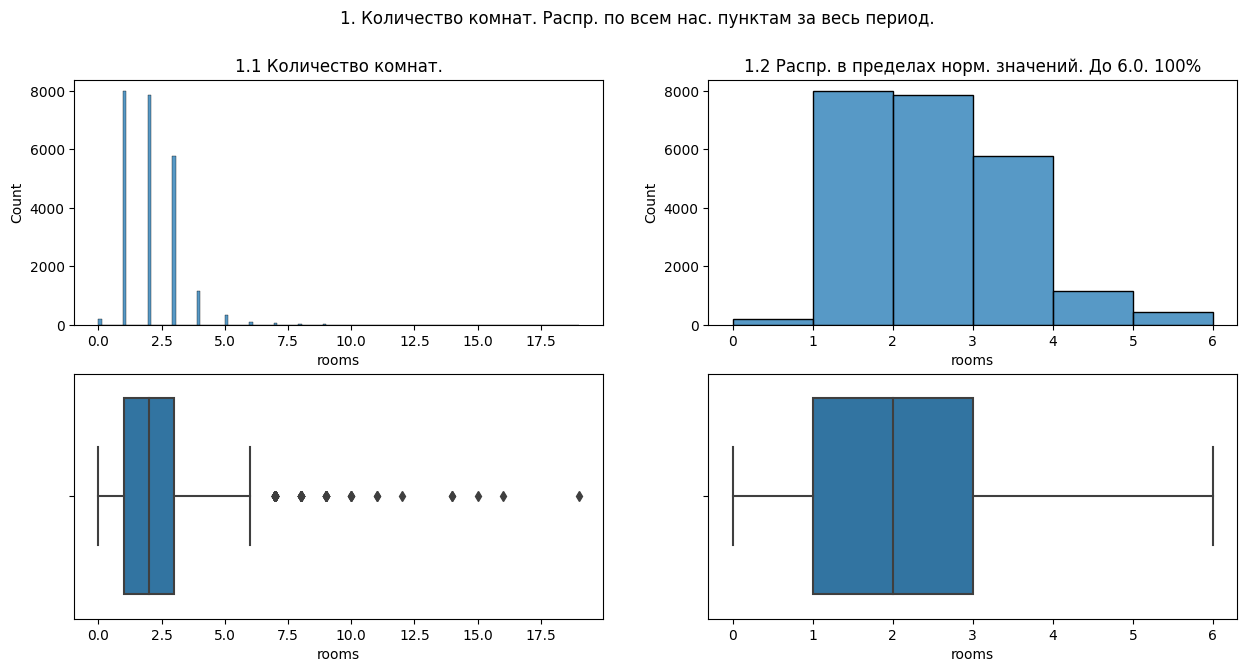

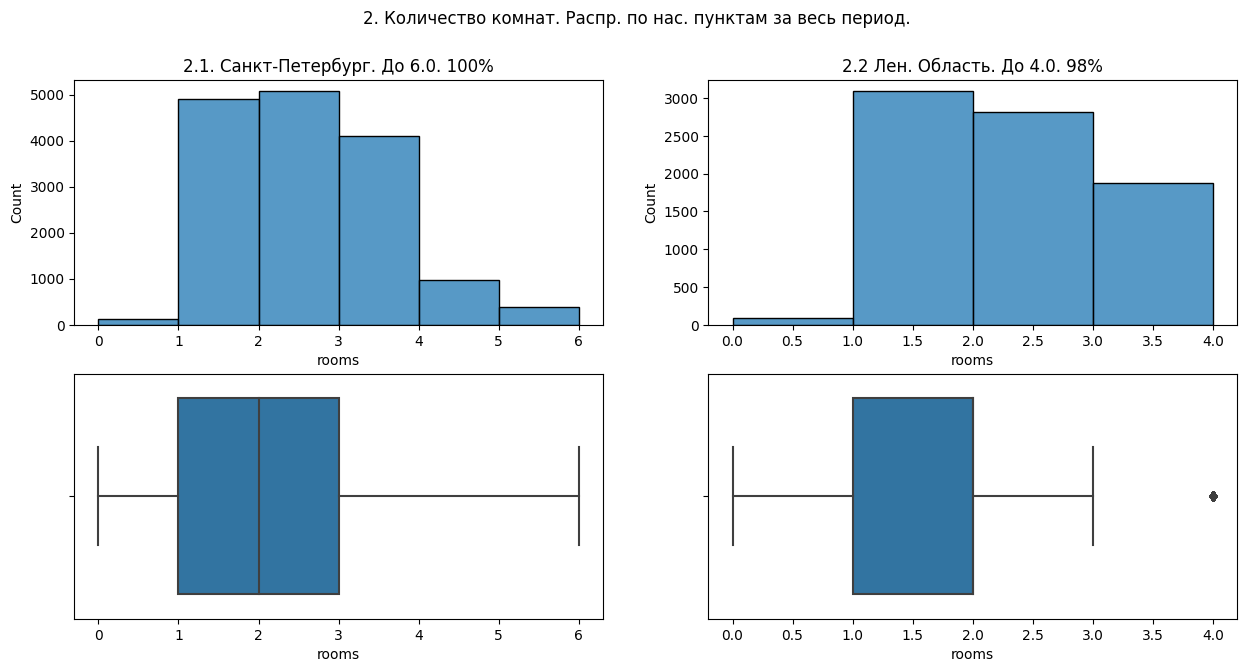

'Объектов с кол-вом комнат более 6: '

'87'

In [78]:
# Выведем графики и таблицу
get_stats(data['rooms'])

# Выведем 3 максималоьн
display('Объектов с кол-вом комнат более 6: ',
        f'{data.loc[data["rooms"] > 6, "rooms"].count()}')

###### Выводы.
- **1.1 Кол-во комнат по всем данным за весь период:**<br>
  - Диапазон кол-в комнат в данных - от 0 до 19;
  Объекты с 0 комнатами - студии, квартиры с открытой планировкой.<br><br>


- **1.2 Распределение в пределах нормальных значений.  До 6 комнат.**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных.)*
  - Графики демонстрируют, что объявления делятся на:
    - дорогие и элитные квартиры с кол-вом комнат более 6 (90 объектов в выборке);
    - квартиры с кол-вом комнат до 6, из которых представлены наиболее широко объекты с кол-вом комнат от 1 до 4.<br><br>  
    
- **2.1 Распределение в пределах нормальных значений.  Санкт-Петербург. До 6 комнат:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных для Санкт-Петербурга.)*
  - Разброс нормальных значений соответствует общей выборке (0-6 комнат). Квартиры с кол-вом комнат более 6 единичны.;
  - Среднее кол-во комнат - 2.<br><br>
  
- **2.2 Распределение в пределах нормальных значений.  Лен. область. До 4 комнат:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных для Лен. области.)*
  - Разброс нормальных значений соответствует общей выборке (0-4 комнат). Квартир с кол-вом комнат более 4, - 2%;
  - Среднее кол-во комнат - 2.<br><br>

- **Кол-во комнат - выводы:**
  - Санкт-Петербург:
   - 90 объектов имеют кол-во комнат более 6;
   - подавляющее большинство (около 100%) объектов имеют кол-во комнат от 0 до 6;
   - средняя квартира  - двухкомнатная;
 - Лен. область:
   - большинство (98%) объектов имеют не более 4 комнат;
   - средняя квартира  - двухкомнатная.

##### Высота потолков.

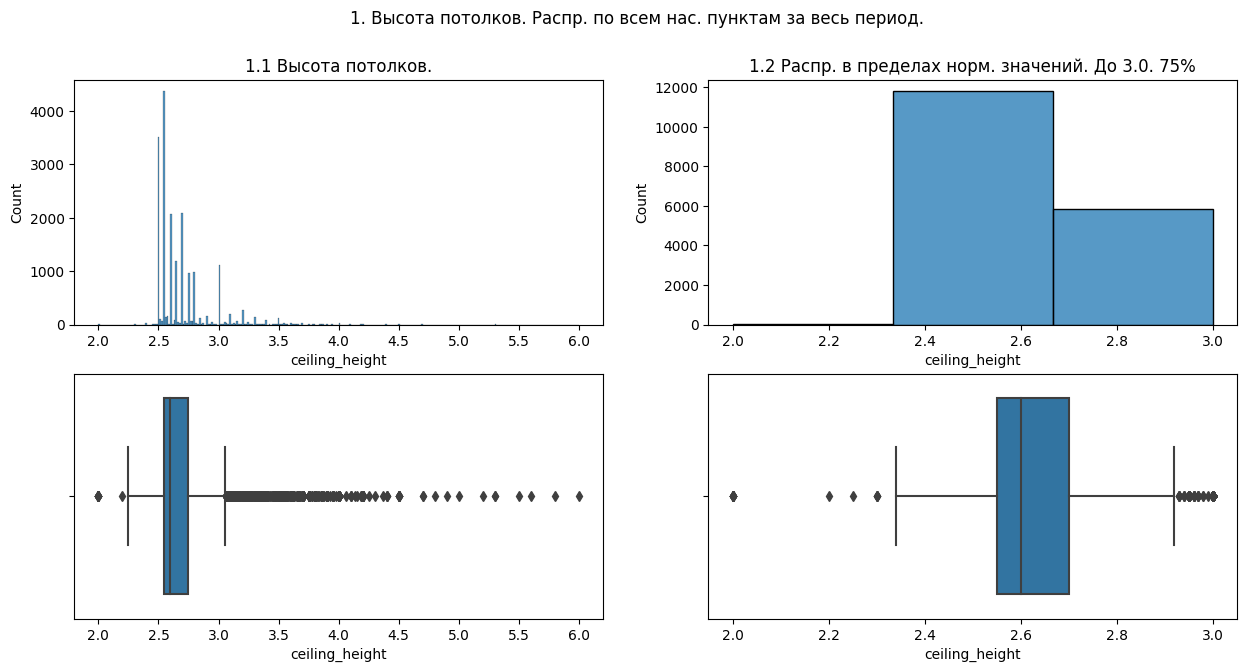

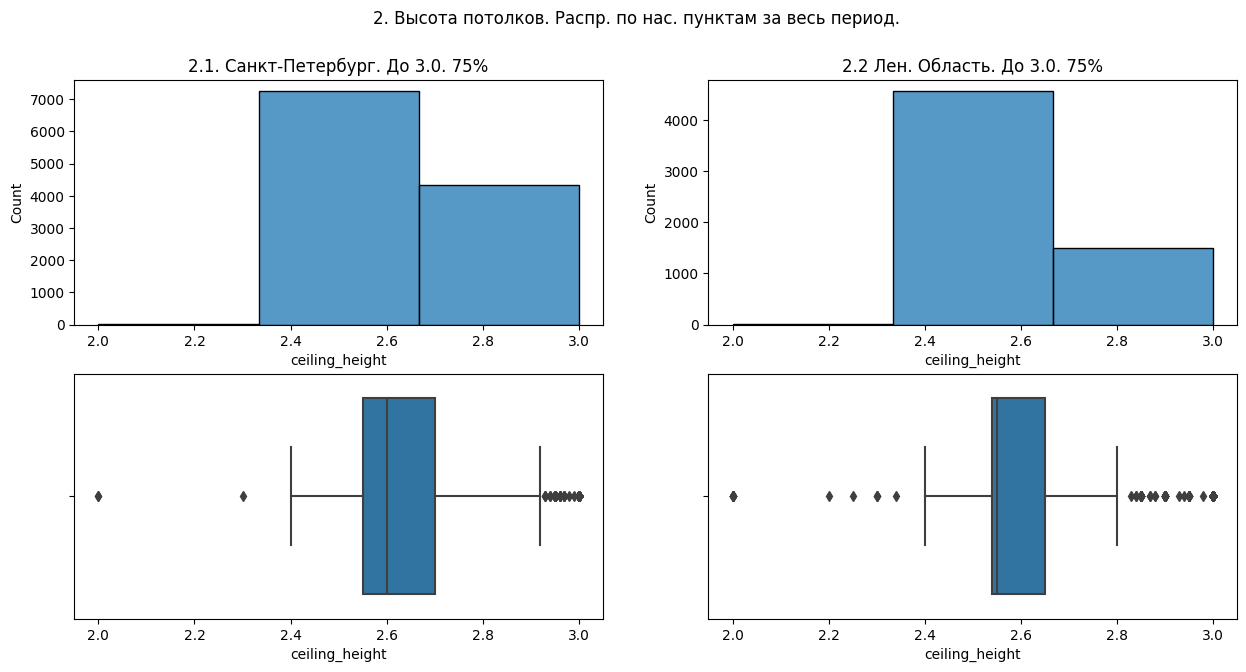

In [79]:
# Выведем графики и таблицу
get_stats(data['ceiling_height'])

###### Выводы.
- **1.1 - 2.2 Высота потолков:**<br>
  - Диапазон квысот потолков в данных - от 0 до 6; потолки высотой в 2м., скорее всего, натяжные или измененной конструкции;
  - Диапазон высот в нормальных распределениях аналогичный, как и мин. макс. величины;
  - 25% значений более 3.5, скорее всего, приходятся на дома "сталинского" типа и нестандартные планировки;
  - В средней квартире в Санкт-Петербурге и Лен. Области, потолки 2.6 и 2.55 м. соответственно, что обусловлено большим кол-вом типовых домов.

##### Этаж квартиры.

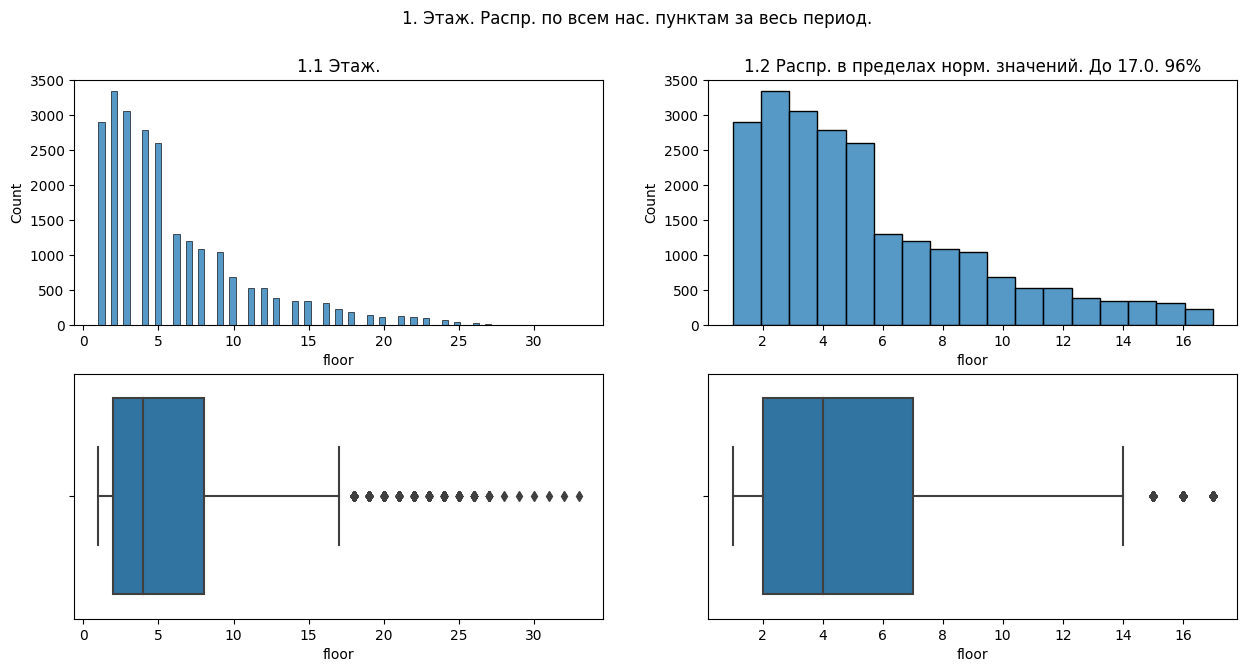

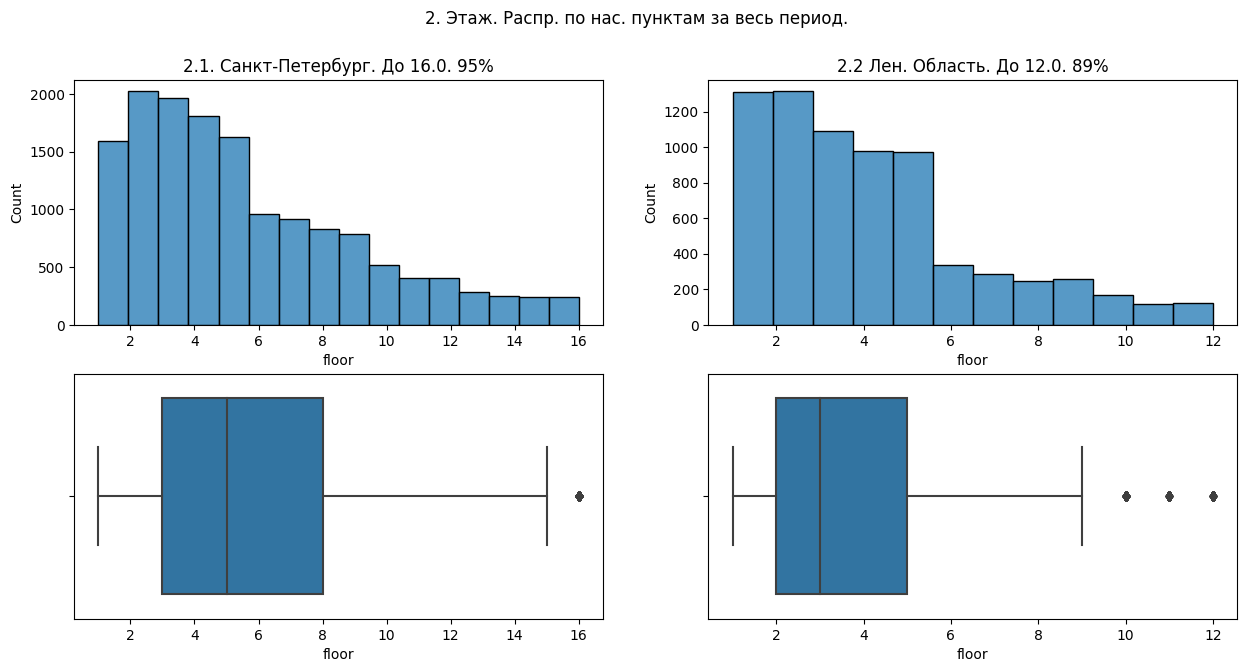

In [80]:
get_stats(data['floor'])

###### Выводы.
- **1.1 - 1.2 Этаж. За весь период по всем данным и в пределах норм. значений :**<br>
  - Диапазон этажей в данных - от 1 до 33;
  - Наличие объектов на этажах выше 17-го (4%);<br>
  *Квартира на 33 этаже находится в самом высоком жилом доме Санкт-Петербурга - ЖК "Александр Невский"*.
  - График демонстрирует большое кол-во квартир до 5 этажа, что подтверждает предположение о большом кол-ве типовых домов, и косвенно указывает на то, что продавцы и рынок стремятся расстаться с "5-этажками".<br><br>
    
- **2.1 Распределение в пределах нормальных значений.  Санкт-Петербург. До 16 этажа:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных для Санкт-Петербурга.)*
  - Диапазон этажей в данных 1 - 16. 5% квартир находятся на этажах выше в нескольких высотных домах Санкт-Петербурга;
  - Средняя квартира расположена на 5 этаже.<br><br>
  
- **2.2 Распределение в пределах нормальных значений.  Лен. область. До 12 этажей:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных для Лен. области.)*
  - Диапазон этажей в данных 1 - 12. 11% квартир находятся на этажах выше;
  - Средняя квартира расположена на 3 этаже.<br><br>

- **Кол-во комнат - выводы:**
  - Санкт-Петербург:
   - средняя квартира на 5-ом этаже;
 - Лен. область:
   - средняя квартира на 3 этаже.

##### Тип этажа квартиры.

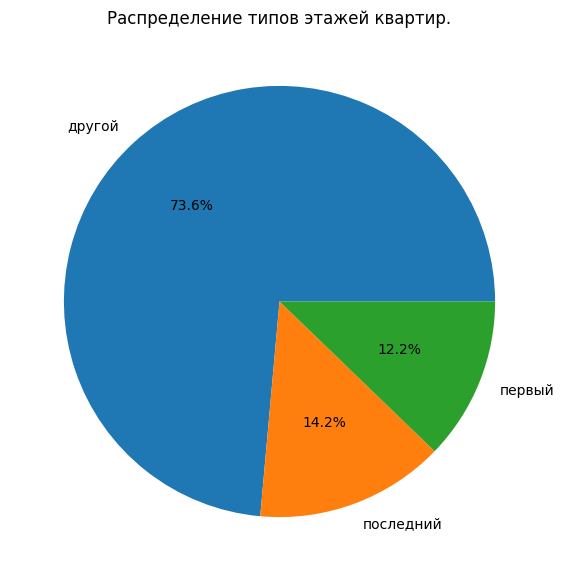

In [81]:
# Построим график распределения типов этажей квартир
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
floor_type_pie = data['floor_type'].value_counts()
ax.pie(floor_type_pie,  labels=floor_type_pie.index, autopct='%1.1f%%',)
plt.title('Распределение типов этажей квартир.')
plt.show();

###### Выводы:
"Первых" и "последних" этажей вместе в три раза меньше, чем "других", что логично, так как мы сравнивавем две конкретных группы, с распределением.

##### Общее количество этажей в доме.

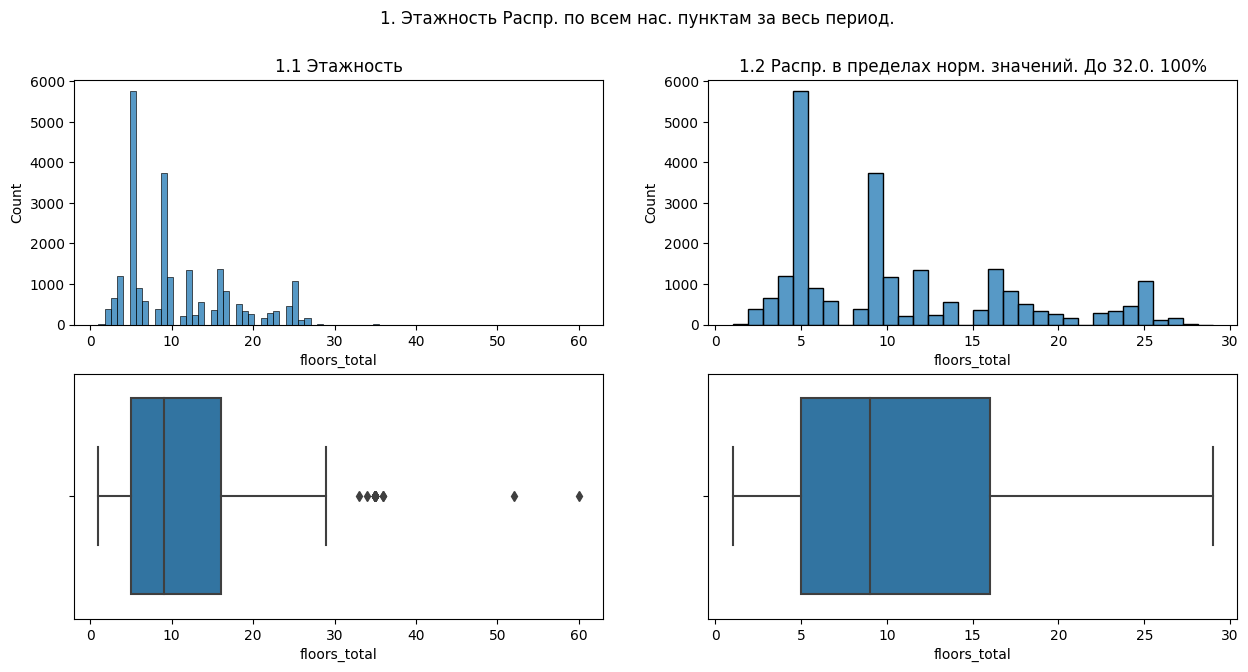

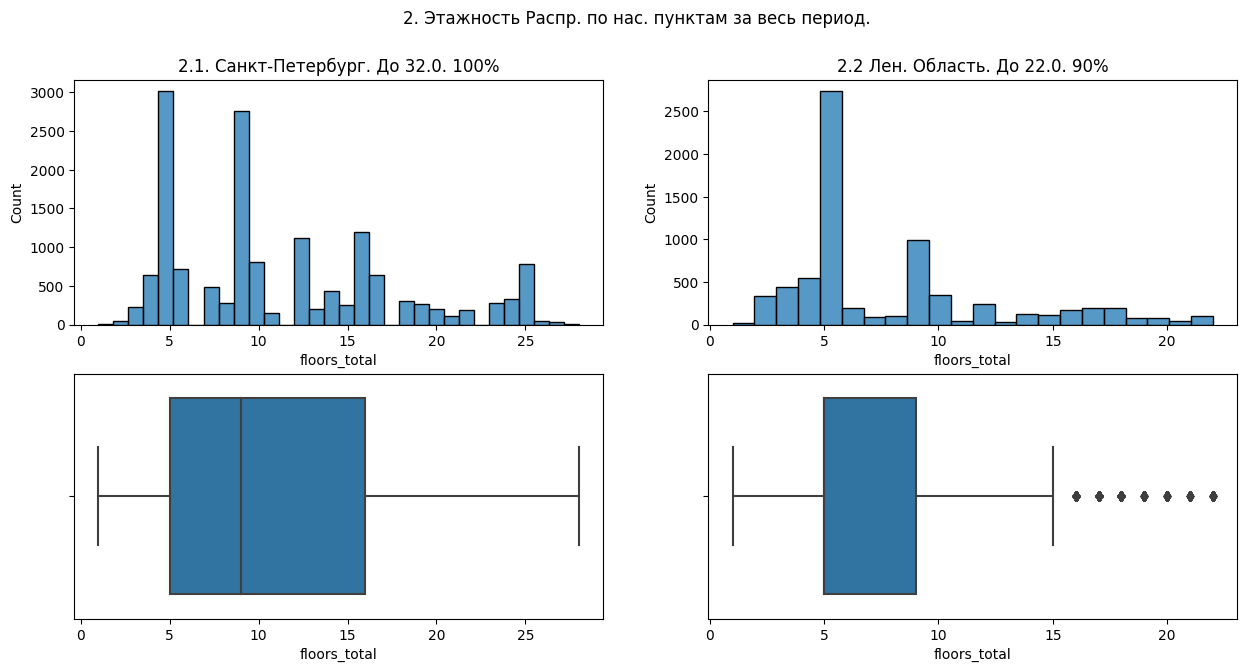

total_images  last_price  total_area first_day_exposition  rooms  \
2251             12     3800000        45.5           2018-06-28      2   
16701             9     3978000        40.0           2018-09-24      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
2251             2.88            60         27.4      4         False   False   
16701            2.65            52         10.5     18         False   False   

       open_plan  kitchen_area  balcony    locality_name  airport_nearest  \
2251       False           7.4        0        Кронштадт            67763   
16701      False          14.0        0  Санкт-Петербург            20728   

       city_center_nearest  parks_around_3000  parks_nearest  \
2251                 49488                  2            342   
16701                12978                  1            793   

       ponds_around_3000  ponds_nearest  days_exposition  meter_price  \
2251                   3            614              166      83516.0   
16701                  0           <NA>               45      99450.0   

       week_day_exposition  month_exposition  year_exposition floor_type  \
2251                     3                 6             2018     другой   
16701                    0                 9             2018     другой   

       city_center_nearest_km    locality_type  last_price_mil  
2251                       49     Лен. Область           3.800  
16701                      12  Санкт-Петербург           3.978

In [82]:
get_stats(data['floors_total'])
display(data.query('floors_total > 42'))

###### Выводы.
- **1.1 - 1.2 Этаж. По всем данным за весь период:**<br>
  - Диапазон этажностей в данных - от 1 до 60;
  - Этажей выше 32-го меньше 1%;<br><br>
    
- **2.1 Распределение в пределах нормальных значений. Санкт-Петербург. До 16 этажа:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных для Санкт-Петербурга.)*
  - Диапазон этажностей в данных 1 - 28. Менее 1% квартир находятся в домах с этажностью выше;
  - Пики на 5, 9, 12 и 16 этажах отражают типовые дома массовой застройки;
  - Средняя этажность - 9.<br><br>
  
- **2.2 Распределение в пределах нормальных значений. Лен. область. До 12 этажей:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных для Лен. области.)*
  - Диапазон этажей в данных 1 - 22. 10% квартир находятся в домах с большей этажностью;
  - Пики на 5 и 9 этажах отражают отличную от города застройку домами с меньшей этажностью;
  - Средняя квартира расположена на 5 этаже.<br><br>

- **Этажность - выводы:**<br>
  - Санкт-Петербург:
   - средняя этажность домов - 9;
 - Лен. область:
   - средняя этажность домов - 5.
   
>Примечание: *Шестьюдесятью этажами в Санкт-Петербурге может похвастаться только самое высокое здание России и Европы на данный момент, - "Лахта-Центр". Апартаменты, теоретически, продаваться там могут, но цена за метр, как минимум, подозрительна. Удалять записи не стоит, т.к. они практически не влияют на распределение и, если легитимны, отражают широкий спектр объектов на площадке, но обратить внимание на подозрительные объявления считаю шнеобходимым.*

##### Расстояние до центра города в метрах.

In [83]:
# Изменим функцию вывода графиков, удалив кол-во корзин для каждого
def get_stats2(column):
    column_name = column.name
    
    # Запишем усы графиков в переменные
    lim_top_all = get_whiskers(data[column_name])[1]
    lim_top_piter = get_whiskers(data.query('locality_type == "Санкт-Петербург"')[column_name])[1]
    lim_top_oblast = get_whiskers(data.query('locality_type == "Лен. Область"')[column_name])[1]

    # Процент оставшихся значений от общего кол-ва
    values_left_all = '{:.0%}'.format(round(len(data.query('@column <= @lim_top_all')[column.name]) /
                                            len(data[column.name]), 4))
    values_left_piter = '{:.0%}'.format(round(len(data.query('@column <= @lim_top_piter')[column.name]) / 
                                            len(data[column.name]), 4))
    values_left_oblast = '{:.0%}'.format(round(len(data.query('@column <= @lim_top_oblast')[column.name]) / 
                                            len(data[column.name]), 4)) 
    
    # Графики по всей базе
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'1. {names_rus[column.name]} Распределение за весь период.')
    
    sns.histplot(x=column.name, data=data, ax=axes[0])
    axes[0].set_title(f'1.1 {names_rus[column.name]}')
    sns.histplot(x=column.name, data=data.query('@column <= @lim_top_all'), ax=axes[1])
    axes[1].set_title(f'1.2 Распр. в пределах норм. значений. До {lim_top_all}. {values_left_all}.')
    
    # Графики по нас. пунктам
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'2. {names_rus[column.name]}Распр. в пределах норм. значений по нас. пунктам за весь период.')
    
    sns.histplot(x=column.name, 
                 data=data.query('locality_type == "Санкт-Петербург" and @column <= @lim_top_piter'), ax=axes[0])
    axes[0].set_title(f'2.1. Нормальное распределение. Санкт-Петербург. До {lim_top_piter}.{values_left_piter}')
    
    sns.histplot(x=column.name, 
                 data=data.query('locality_type == "Лен. Область" and @column <= @lim_top_oblast'), ax=axes[1])
    axes[1].set_title(f'2.2 Нормальное распределение. Лен. Область. До {lim_top_oblast}. {values_left_oblast}')
    
    plt.show()
    
    # Таблица распределений в цифрах
    display(pd.DataFrame
            (data = 
             {f'1.1 Без ограничений.' : 
              (data[column.name].describe()), 
              f'1.2 До {lim_top_all}.' : 
              data.query('@column <= @lim_top_all')[column.name].describe(),
              f'2.1 Санкт-Петербург. До {lim_top_piter}': 
              data.query('locality_type == "Санкт-Петербург" and @column <= @lim_top_piter')[column.name].describe(),
              f'2.2 Лен. Область. До {lim_top_oblast}': 
              data.query('locality_type == "Лен. Область" and @column <= @lim_top_oblast')[column.name].describe()})
            .style.set_caption(f'{names_rus[column.name]} Распределение за весь период в цифрах.')
            .set_table_styles(styles)
           )

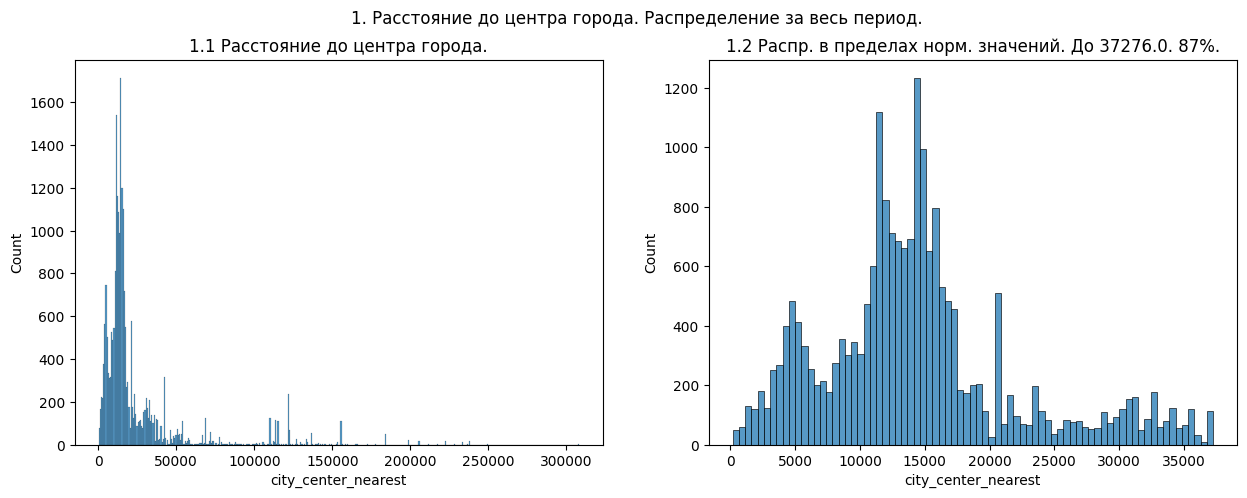

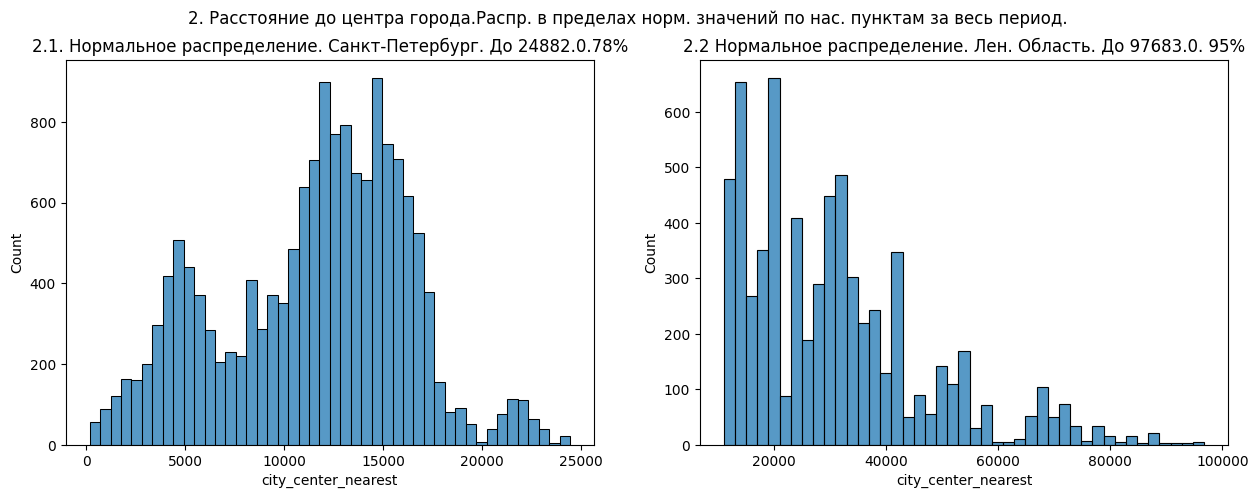

In [84]:
# Выведем графики и таблицу
get_stats2(data['city_center_nearest'])

###### Выводы.
- **1.1 - 1.2 Расстояние до центра города. За весь период по всем данным и в пределах норм. значений :**<br>
  - Диапазон расстояний до центра в данных - от 181 м. до 308 км.;<br>
  (*городской посёлок Вознесенье действительно находится в Лен. Области и удален от Санкт-Петербурга на 308 км.*);<br>
  - Пределы нормальных значений от 181 до ~37 км. Дальше этой дистанции расположены всего 13% всех объектов;
  - Основная масса объектов удалена от центра на расстояния от 0 до 22.5 км., а *приблизительное среднее расстояние от центра города до КАД - 16 км.*, что позволяет утверждать, что бóльшая часть объектов приходится на город и ближайшую область;<br><br>
    
- **2.1 Распределение в пределах нормальных значений. Санкт-Петербург. До 24 км.:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных для Санкт-Петербурга.)*
  - Диапазон расстояний в данных 181 м. - 24 км.. 22% квартир удалены от центра города на большие расстояния;
  - Средняя квартира удалена от центра города на медианное расстояние - 12 км.;<br><br>
  
- **2.2 Распределение в пределах нормальных значений. Лен. область. До 97 км.:**<br>
  *(График построен в пределах нормальных значений (усов диаграммы размаха) общих данных для Лен. области.)*
  - Диапазон расстояний в данных 11 км. - 96 км. 5% квартир удалены от центра города на большие расстояния;
  - Средняя квартира удалена от центра города на медианное расстояние - 29 км.;<br><br>

- **Расстояние до центра - выводы:**
  - Санкт-Петербург:
   - Средняя квартира удалена от центра города на медианное расстояние - 12 км.;
 - Лен. область:
   - Средняя квартира удалена от центра города на медианное расстояние - 29 км.;

##### Расстояние до ближайшего парка.

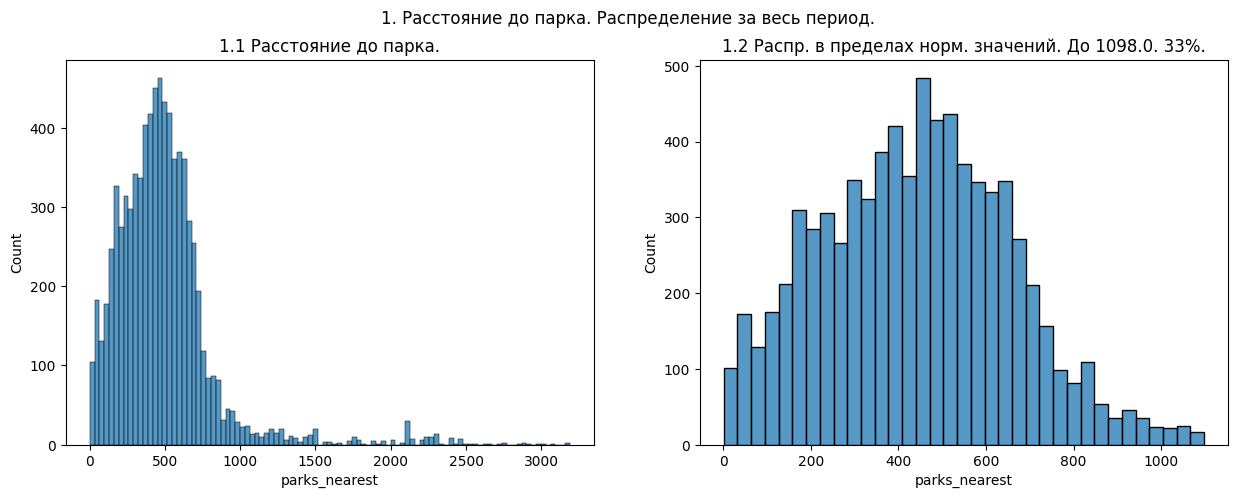

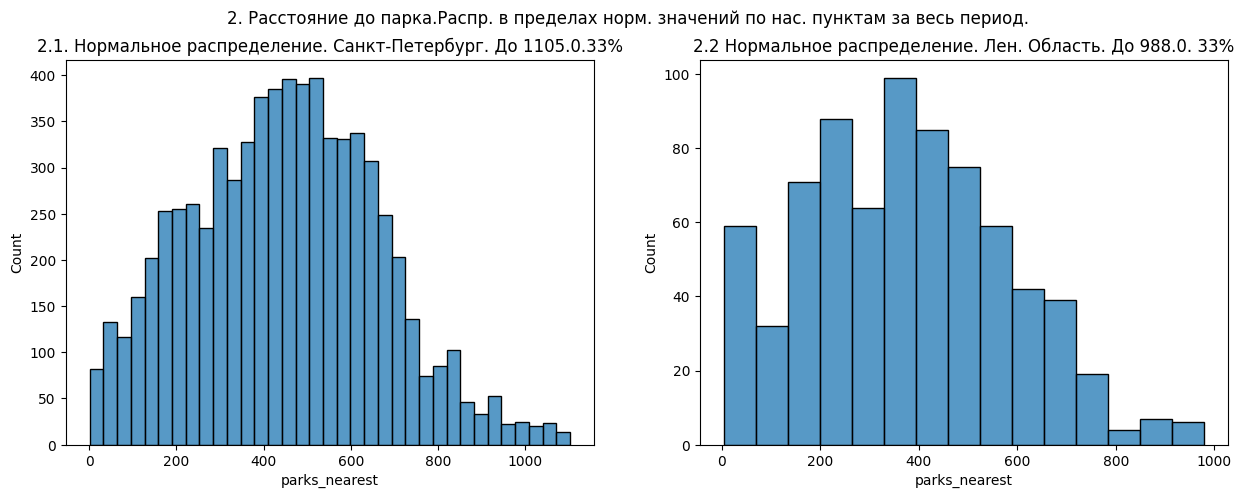

'Процент пропусков по "Паркам":65.86%'

In [85]:
# Выведем графики и таблицу
get_stats2(data['parks_nearest'])

display('Процент пропусков по "Паркам":'
        f'{round(data["parks_nearest"].isna().sum() / len(data["parks_nearest"]), 4):.2%}')

###### Выводы:
- 65.9% квартир удалены от ближайших парков (автоматический подсчет системы) на дистанцию более чем 3.2 км.;
- Оставшиеся 34.1% квартир находится в пределах ~1 км. от парка;
  - Доля квартир Санкт-Петербурга от общего числа объектов в городе удаленных на ~1 км. - 33%;
  - В Лен. области 32% от общего кол-ва объектов области.
- Средняя квартира, расположенная неподалёку от парка, удалена от него на мединное расстояние 
  - в 450 м. в Санкт-Петербурге;
  - в 367 м. в Лен. области.

##### День и месяц публикации объявления.

In [86]:
data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
0            2.70            16         51.0      8         False   False   
1             NaN            11         18.6      1         False   False   
2            2.55             5         34.3      4         False   False   
3             NaN            14          NaN      9         False   False   
4            3.03            14         32.0     13         False   False   

   open_plan  kitchen_area  balcony    locality_name  airport_nearest  \
0      False          25.0        0  Санкт-Петербург            18863   
1      False          11.0        2   посёлок Шушары            12817   
2      False           8.3        0  Санкт-Петербург            21741   
3      False           NaN        0  Санкт-Петербург            28098   
4      False          41.0        0  Санкт-Петербург            31856   

   city_center_nearest  parks_around_3000  parks_nearest  ponds_around_3000  \
0                16028                  1            482                  2   
1                18603                  0           <NA>                  0   
2                13933                  1             90                  2   
3                 6800                  2             84                  3   
4                 8098                  2            112                  1   

   ponds_nearest  days_exposition  meter_price  week_day_exposition  \
0            755             <NA>     120370.0                    3   
1           <NA>               81      82921.0                    1   
2            574              558      92786.0                    3   
3            234              424     408176.0                    4   
4             48              121     100000.0                    1   

   month_exposition  year_exposition floor_type  city_center_nearest_km  \
0                 3             2019     другой                      16   
1                12             2018     первый                      18   
2                 8             2015     другой                      13   
3                 7             2015     другой                       6   
4                 6             2018     другой                       8   

     locality_type  last_price_mil  
0  Санкт-Петербург          13.000  
1     Лен. Область           3.350  
2  Санкт-Петербург           5.196  
3  Санкт-Петербург          64.900  
4  Санкт-Петербург          10.000

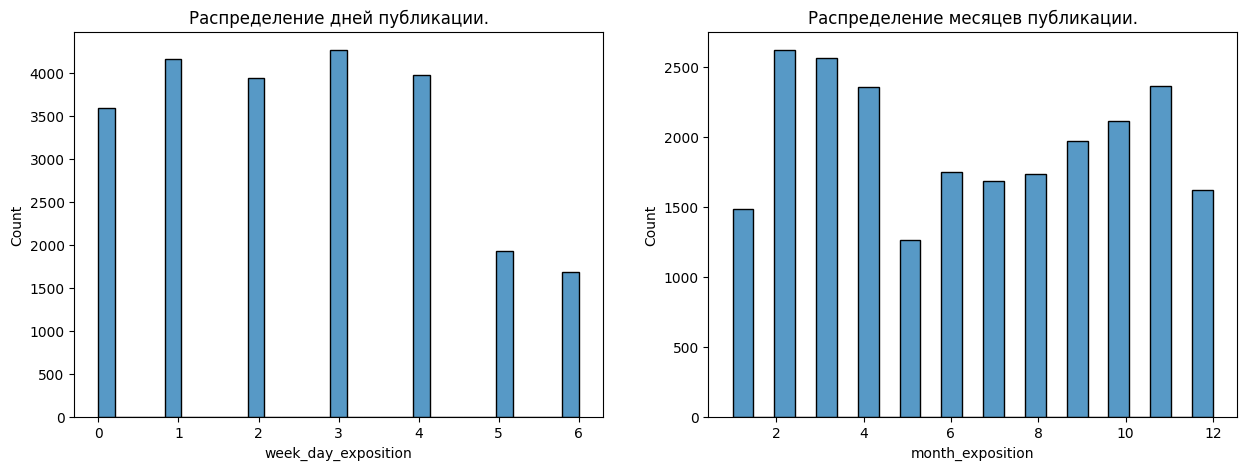

In [87]:
# Построим графики распределений объявлений по дням недели и месяцам
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=data, x='week_day_exposition', ax=axes[0])
axes[0].set_title('Распределение дней публикации.')
sns.histplot(data=data, x='month_exposition', ax=axes[1])
axes[1].set_title('Распределение месяцев публикации.')
plt.show();


###### Выводы:
-  В выходные публикуется в два раза меньше объявлений, чем в будние.
-  В январе и декабре (после и накануне нового года) объявления размещают реже. 
-  Активность возростает в Феврале и сентябре (после каникул и отпусков).
-  Самые активные сезоны - зима и осень, пассивный - лето.

#### Изучение времени продажи квартир.

In [88]:
# Скорректируем функцию для вывода гистограмм, графиков размаха, графика изменений по годам
# и статистики в цифрах для столбца, изменив лимиты, количества корзин и подписи
def get_stats3(column):
    column_name = column.name
    
    # Графики по всей базе
    fig1, axes = plt.subplots(2, 2, figsize=(15, 7))
    fig1.suptitle(f'1. {names_rus[column.name]} Распр. по всем нас. пунктам.')
    
    sns.histplot(x=column.name, data=data.query('@column not in [30, 45, 60, 90]'), ax=axes[0, 0])
    axes[0, 0].set_title(f'1.1 {names_rus[column.name]}. Без аномалий.')
    sns.histplot(x=column.name, data=data.query('@column <= 365 and @column not in [30, 45, 60, 90]'), 
                 bins=200, ax=axes[0, 1])
    axes[0, 1].set_title(f'1.2 Распределение за год. Без аномалий.')
    
    sns.boxplot(x=column.name, data=data, ax=axes[1, 0])
    sns.boxplot(x=column.name, data=data.query('@column not in [30, 45, 60, 90]'), 
                ax=axes[1, 1])
    
    # Графики по нас. пунктам
    fig2, axes = plt.subplots(2, 2, figsize=(15, 7))
    fig2.suptitle(f'2. {names_rus[column.name]} Распределение по нас. пунктам. Без аномалий.')
    
    sns.histplot(x=column.name, 
                 data=data.query('locality_type == "Санкт-Петербург" and @column <= 500 and @column not in [30, 45, 60, 90]'),
                 bins=100, ax=axes[0,0])
    axes[0,0].set_title(
        f'2.1. Санкт-Петербург.')
    
    sns.histplot(x=column.name, 
                 data=data.query('locality_type == "Лен. Область" and @column <= 100 and @column not in [30, 45, 60, 90]'), 
                 bins=100, ax=axes[0,1])
    axes[0,1].set_title(
        f'2.2 Лен. Область.')
    
    sns.boxplot(x=column.name, 
                data=data.query('locality_type == "Санкт-Петербург" and @column <= 500 and @column not in [30, 45, 60, 90]'), 
                ax=axes[1, 0])
    sns.boxplot(x=column.name, 
                data=data.query('locality_type == "Лен. Область"  and @column <= 100 and @column not in [30, 45, 60, 90]'), 
                ax=axes[1, 1])

    plt.show()
    
    # Таблица распределений в цифрах
    display(pd.DataFrame
            (data = 
             {f'1.1 Без ограничений.' : 
              (data[column.name].describe()), 
              f'1.2 Без аномалий.' : 
              data.query('@column not in [30, 45, 60, 90]')[column.name].describe(),
              f'2.1 Санкт-Петербург. Без аномалий.': 
              data.query('locality_type == "Санкт-Петербург" and @column not in [30, 45, 60, 90]')[column.name].describe(),
              f'2.2 Лен. Область. Без аномалий.': 
              data.query('locality_type == "Лен. Область" and @column not in [30, 45, 60, 90]')[column.name].describe()})
            .style.set_caption(f'{names_rus[column.name]} Распределение в цифрах.')
            .set_table_styles(styles)
           )
    
# Функция вывода графика изменения параметра на платформе по городам во времени
def get_graph_time(column):
    year_locality = data.pivot_table(index=['locality_type', 'year_exposition'], 
                                     values=column.name, aggfunc='mean')
    year_locality.columns = ['column_mean']
    year_locality = year_locality.reset_index()

    sns.relplot(data=year_locality, kind='line', x='year_exposition', 
                y='column_mean', hue='locality_type',
    height=4, facet_kws={'sharey': False, 'sharex': True})
    plt.title(f'3. {names_rus[column.name]} Изменение среднего по годам.')
    plt.xlabel('Годы')
    plt.ylabel(names_rus[column.name]);
    
    plt.show()

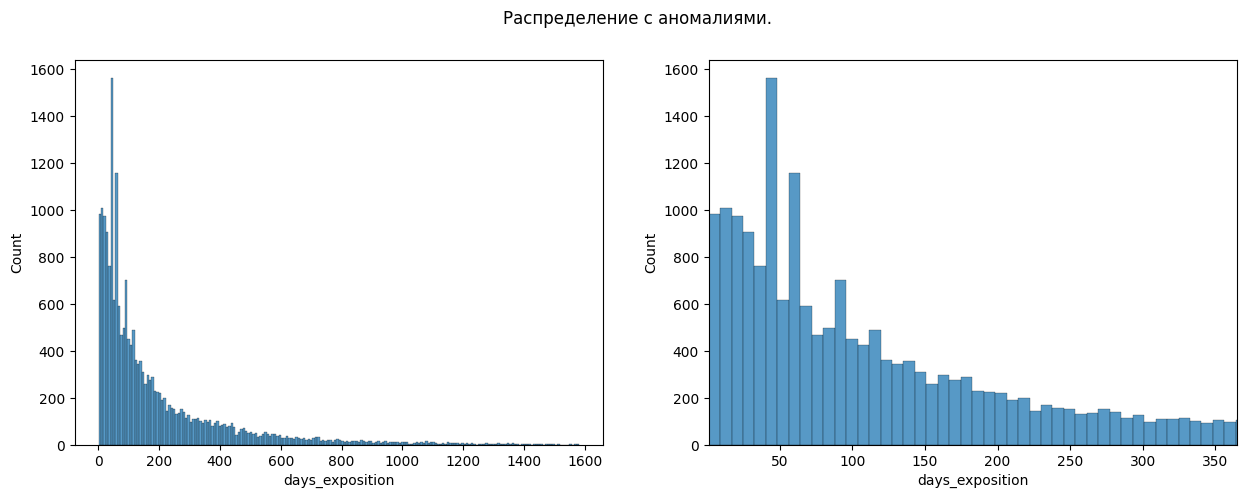

'Наиболее распространенные значения: '

45    879
60    534
7     233
30    208
90    202
Name: days_exposition, dtype: Int64

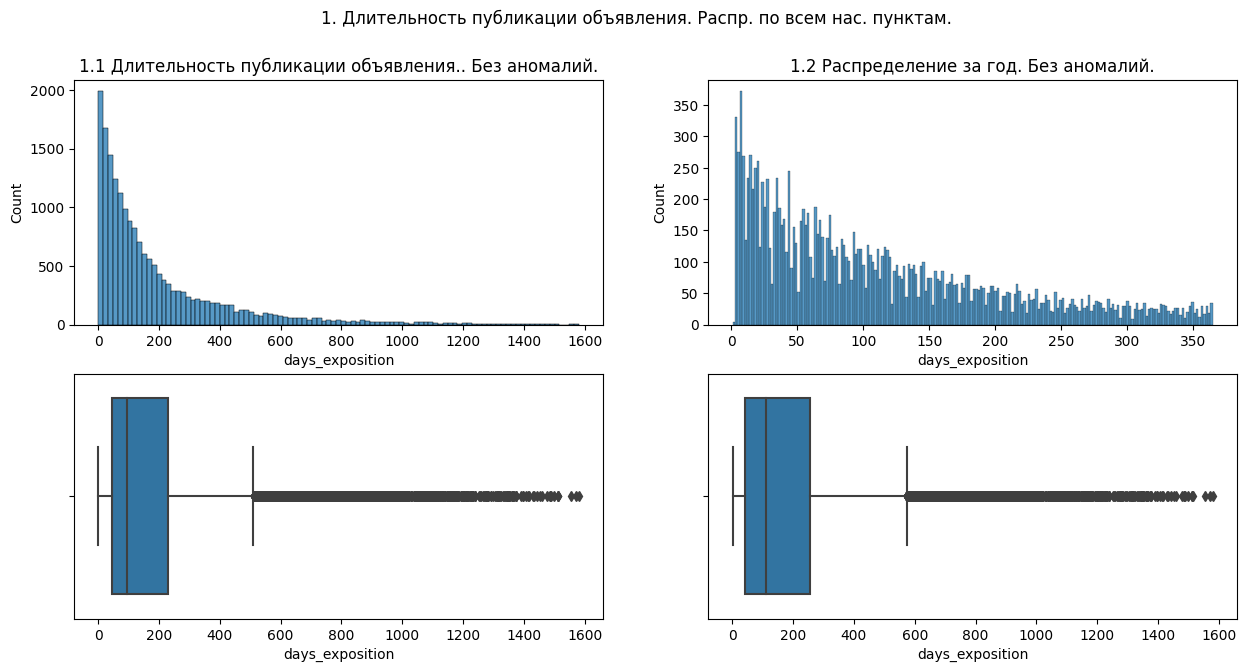

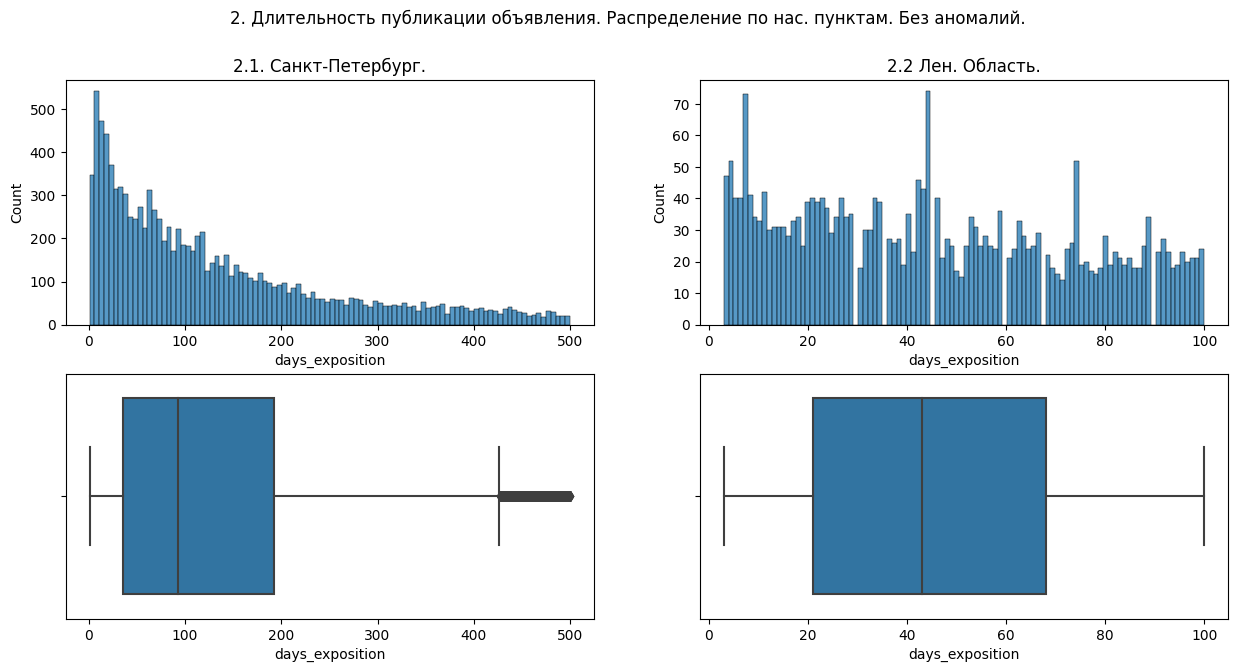

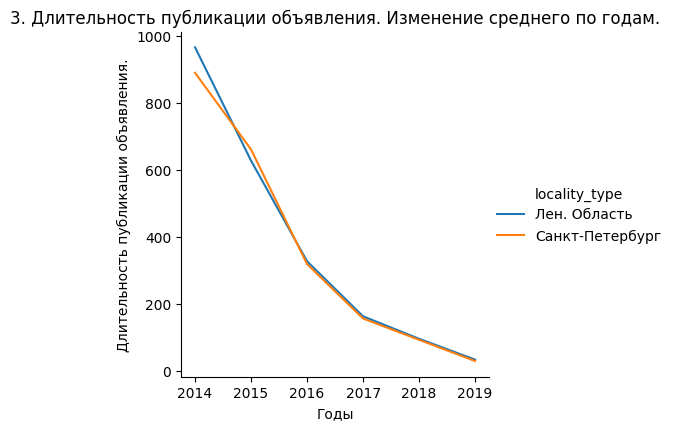

'Пределы нормальных значений без аномалий: '

[1.0, 573.0]

In [89]:
#Выведем гистограммы распределений, общего и за 365 дней
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Распределение с аномалиями.')
sns.histplot(data['days_exposition'], bins=200, ax=axes[0])
sns.histplot(data['days_exposition'], bins=200, ax=axes[1])
plt.xlim(1, 365)
plt.show()

# Выведем наиболее распространенные длительности размещения
display('Наиболее распространенные значения: ',
        data['days_exposition'].value_counts().head(5))

# Построим графики и таблицу без учета выбросов
get_stats3(data['days_exposition'])
get_graph_time(data['days_exposition'])

# Получим пределы нормальных значений
display('Пределы нормальных значений без аномалий: ',
        get_whiskers(data.query('days_exposition not in [30, 45, 60, 90]')['days_exposition']))

###### Анализ.

- Рассмотрим все объявления снятые с публикации в разумные сроки (от 1 дня до 1 года), как проданные объекты, т.к. другого критерия оценки состоявшейся продажи нет.<br> 
- Укрупнив график до 365 отображаемых дней публикации для всех нас. пунктов видим, что для всех нас. пунктов по всем годам присутствуют пики. Рассмотрим их подробнее.<br>
  - 7 дней:<br>может означать удачные объекты, расторопную работу риелторов или причины обусловленные площадкой (модерацию);<br>
  - 45, 60, 90 дней:<br>резко выделяющиеся пики, связаны, скорее вссего с устаревшими условиями размещения объявлений;
>*Сейчас 45, 60, 90 дней - сроки бесплатного размещения объявлений для квартир разных стоимостей в регионах кроме Московского и Санкт-Петербуржского. Возможно, такие сроки были для всех регионов в прошлом.*
   Помимо этого, 30, 60 и 90 дней, - даты продления платных объявлений в современных правилах размещения. Возможно, они добавляют кол-в снятых объявлений.
   
###### Выводы.
- Исключим эти 3 неизвестных фактора (30, 60, 90 дней) и проверим измененные данные:
 - _диапазон продаж_, - пределы нормальных значений без аномалий, - от 1 до 573 дней;
 - _средняя продажа_, - медианные значения без аномалий, т.е.:
   - до 110 дней для Санкт-Петербурга
   - 116 для Лен. области
 - быстрой продажей будут все значения до первого квартиля ~40 дней
 - медленной, после 3-го квартиля, ~250 дней<br><br>

- **Длительность публикации объявлений. Изменение среднего по годам.**

    Падение среднего времени публикации объявлений с 2014 г., начала работы Яндекс.Недвижимости в Санкт-Петерьурге и Лен. Области как самостоятельной площадки объявлений, скорее всего, связано с менявшимися условиями размещения, которое в начале работы площадки было бесплатным и неограниченным, а на данный момент ограничено для Санкт-Петербурга и Лен. области 1-им объявлением в год при бесплатной публикации и продливается каждые 30 дней при платной.

#### Факторы влияющие на общую (полную) стоимость объекта больше всего.

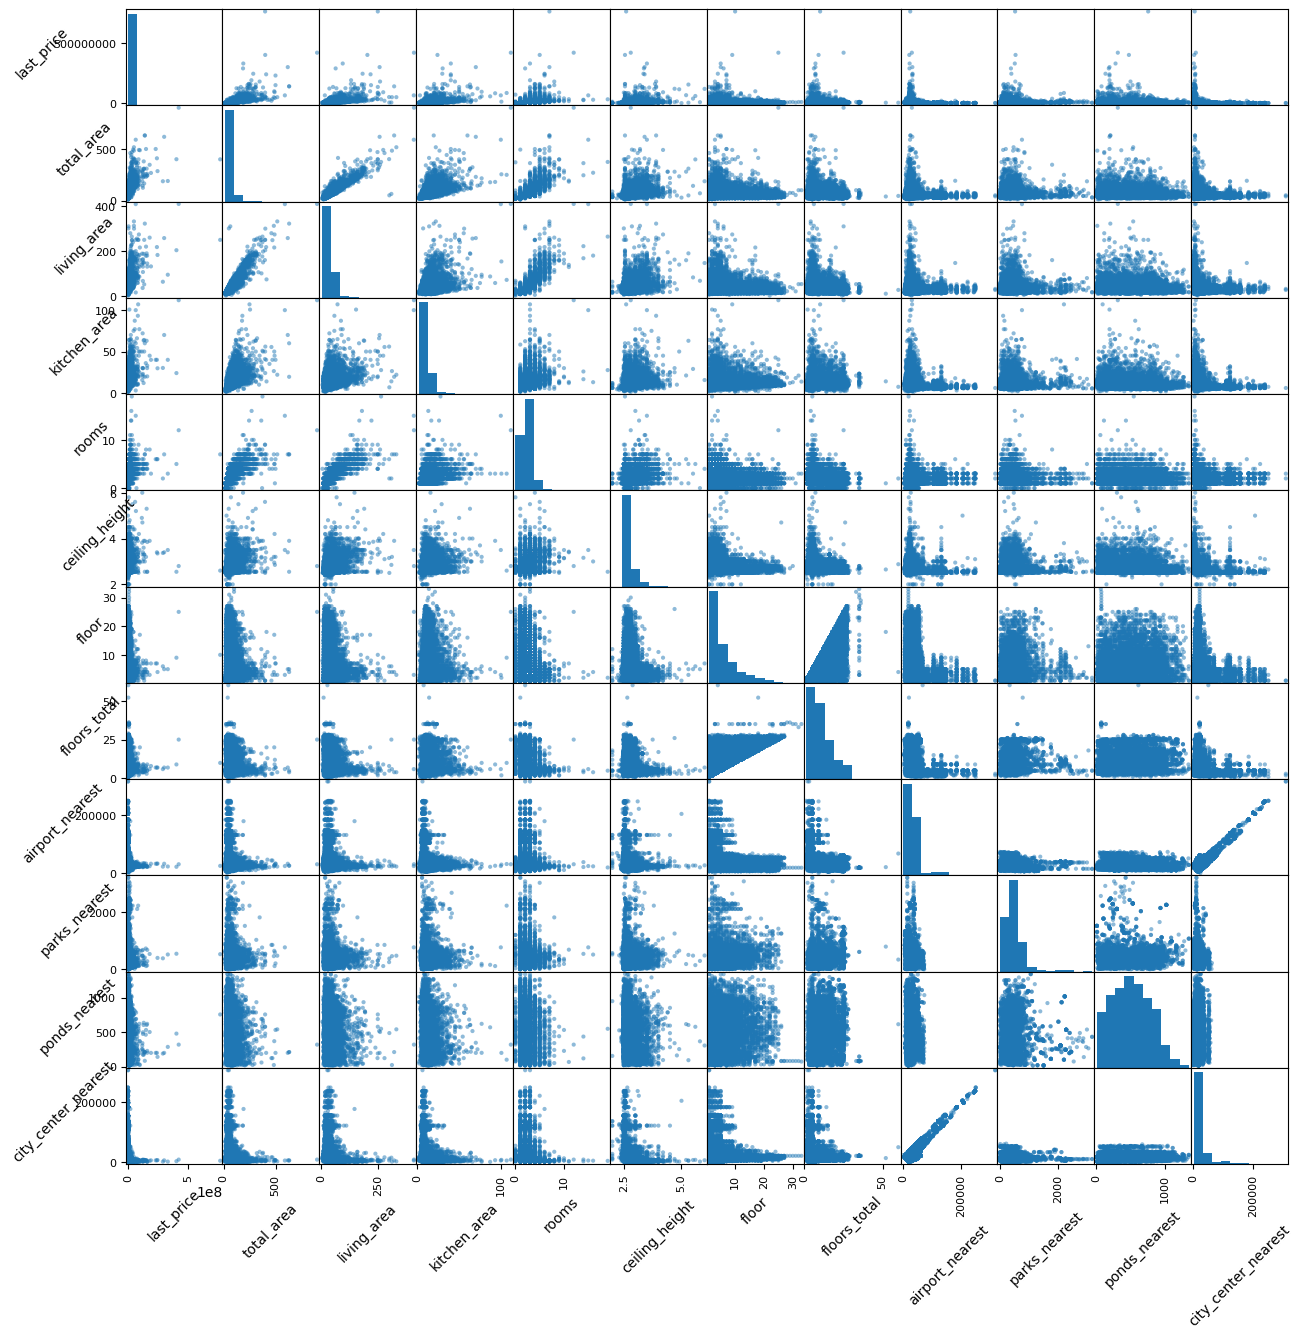

In [90]:
# Столюцы для изучения
columns_to_matrix_full = ['last_price', 'total_area', 'living_area', 
                          'kitchen_area',
                          'rooms', 'ceiling_height', 
                          'floor', 'floors_total', 'airport_nearest', 
                          'parks_nearest', 'ponds_nearest', 'city_center_nearest']

# Построим матрицу корреляции
axes = pd.plotting.scatter_matrix(data[columns_to_matrix_full], figsize=(15, 15), diagonal='hist')
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(45)
plt.show()

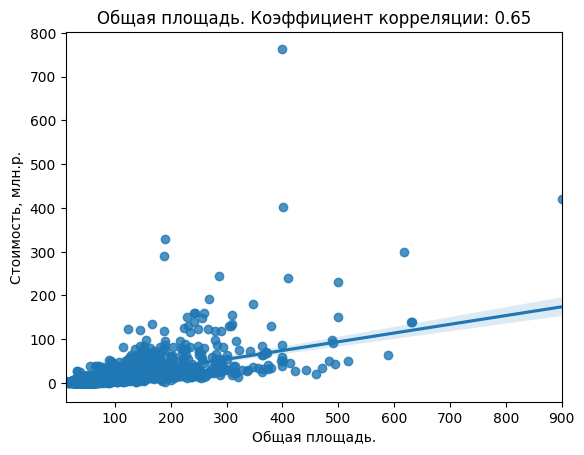

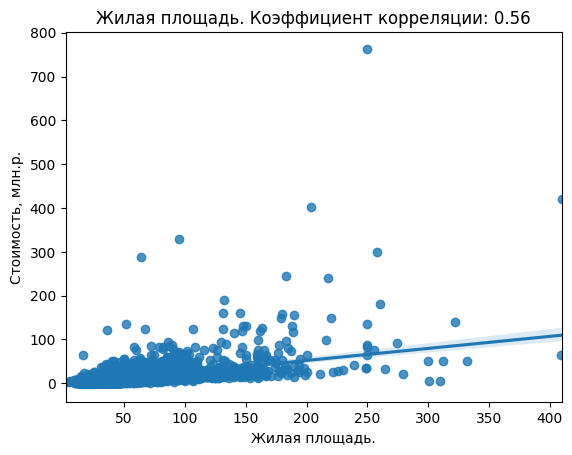

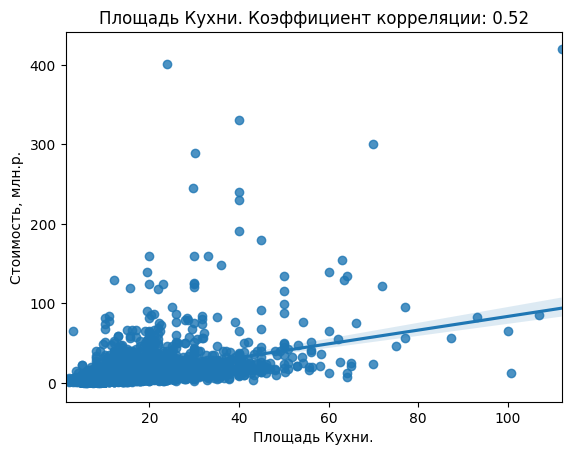

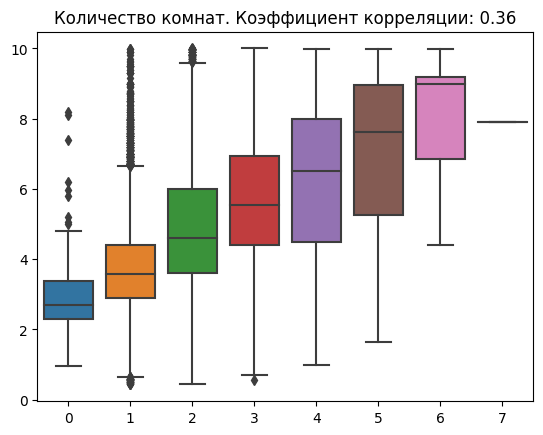

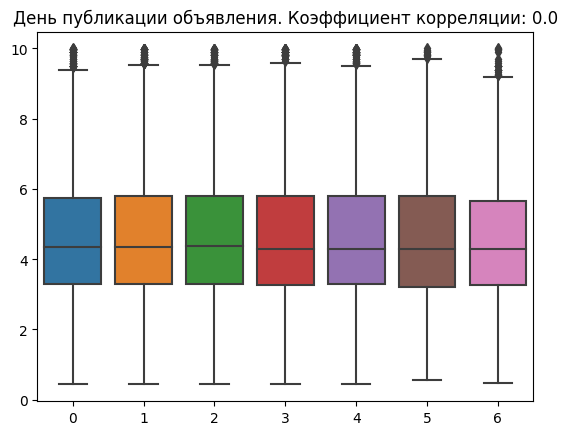

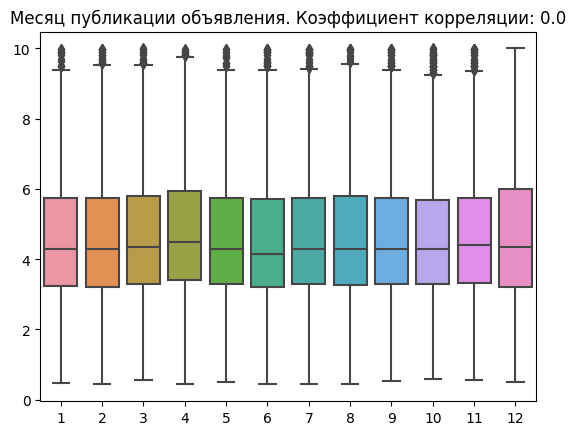

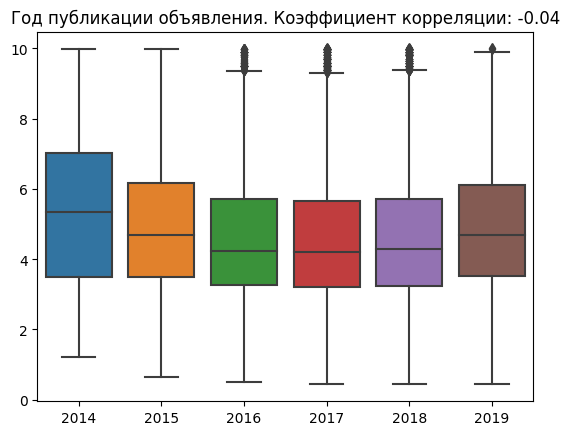

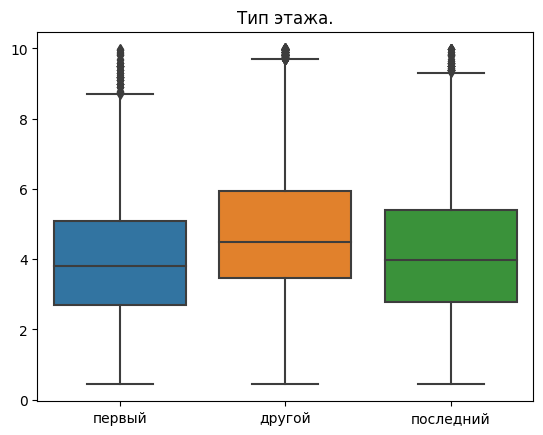

In [91]:
# Разделим столбцы для анализа по типу графика
columns_to_boxplot = ['rooms', 'week_day_exposition', 
                      'month_exposition', 'year_exposition']
columns_to_regplot = ['total_area', 'living_area', 'kitchen_area']

# Выведем зависимости и коэфф.корр для площадей и дат
for column in columns_to_regplot:
    sns.regplot(x=column, y='last_price_mil', data=data)
    plt.title(f"{names_rus[column]} Коэффициент корреляции: {round(data[column].corr(data['last_price_mil']), 2)}")
    plt.xlabel(f'{names_rus[column]}')
    plt.ylabel(f'Стоимость, млн.р.')
    plt.show();
    
for column in columns_to_boxplot:
    sns.boxplot(x=column, y="last_price_mil", data=data.query('last_price_mil < 10'))
    plt.title(f"{names_rus[column]} Коэффициент корреляции: {round(data[column].corr(data['last_price_mil']), 2)}")
    plt.xlabel('')
    plt.ylabel('')
    plt.show();   
    
# Выведем зависимость от типа этажа
sns.boxplot(x='floor_type', y="last_price_mil", data=data.query('last_price_mil < 10'))
plt.title('Тип этажа.')
plt.xlabel('')
plt.ylabel('')
plt.show();

##### Вывод:
- Влияние параметров объекта на стоимость в порядке убывания:
 1. Общая площадь;
 2. Жилая площадь;
 3. Площадь кухни;
 4. Кол-во комнат.
- Предпочтительный тип этажа - "другой".
- В декабре по статистике публикуются объявления с чуть более высокой ценой объектов.
- С 2014г. верхняя планка цены снизилась.

####  Cредняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [92]:
# Цена кв.метра в 10 нас. пунктах с самым большим числом объявлений
top_ten_ads = list(data['locality_name'].value_counts().head(10).index)
top_ten_ads_prices = []
for locality in top_ten_ads:
    top_ten_ads_prices.append(data.query('locality_name in @locality')['meter_price'].mean())
    
display(pd.DataFrame(data={'Нас. пункт' : top_ten_ads,
                           'Средняя цена кв. м.' : top_ten_ads_prices}))

# Макс. и мин. цена по нас. пунктам
display(data.groupby('locality_name').mean().sort_values('meter_price',ascending=False).head(1))
display(data.groupby('locality_name').mean().sort_values('meter_price').head(1))

Нас. пункт  Средняя цена кв. м.
0    Санкт-Петербург        114624.513799
1     посёлок Мурино         85656.211191
2     посёлок Шушары         78677.379545
3         Всеволожск         68654.474874
4             Пушкин        103070.375000
5            Колпино         75424.571006
6  посёлок Парголово         90175.886850
7            Гатчина         68757.643791
8    деревня Кудрово         92473.588629
9             Выборг         58141.919831

total_images  last_price  total_area     rooms  ceiling_height  \
locality_name                                                                   
Зеленогорск            9.75   6288337.5     54.4875  1.833333            2.65   

               floors_total  living_area     floor  is_apartment  studio  \
locality_name                                                              
Зеленогорск            4.25    30.804167  2.291667      0.083333     0.0   

               open_plan  kitchen_area   balcony  airport_nearest  \
locality_name                                                       
Зеленогорск          0.0      9.856522  0.416667         73300.25   

               city_center_nearest  parks_around_3000  parks_nearest  \
locality_name                                                          
Зеленогорск           54617.583333           1.916667        210.625   

               ponds_around_3000  ponds_nearest  days_exposition  meter_price  \
locality_name                                                                   
Зеленогорск                0.875     485.888889       174.428571    115122.75   

               week_day_exposition  month_exposition  year_exposition  \
locality_name                                                           
Зеленогорск                  2.375          6.208333      2017.291667   

               city_center_nearest_km  last_price_mil  
locality_name                                          
Зеленогорск                    54.125        6.288337

total_images  last_price  total_area     rooms  \
locality_name                                                        
деревня Старополье     10.333333    460000.0   41.133333  1.333333   

                    ceiling_height  floors_total  living_area     floor  \
locality_name                                                             
деревня Старополье            2.55           5.0         30.3  2.333333   

                    is_apartment  studio  open_plan  kitchen_area  balcony  \
locality_name                                                                
деревня Старополье           0.0     0.0        0.0           5.5      0.0   

                    airport_nearest  city_center_nearest  parks_around_3000  \
locality_name                                                                 
деревня Старополье         127342.0             139628.0                0.0   

                    parks_nearest  ponds_around_3000  ponds_nearest  \
locality_name                                                         
деревня Старополье           <NA>                0.0           <NA>   

                    days_exposition   meter_price  week_day_exposition  \
locality_name                                                            
деревня Старополье        61.333333  11206.333333             1.666667   

                    month_exposition  year_exposition  city_center_nearest_km  \
locality_name                                                                   
деревня Старополье               9.0      2017.666667                   139.0   

                    last_price_mil  
locality_name                       
деревня Старополье            0.46

#### Анализ зависимости стоимости объектов от расстояния до центра города.

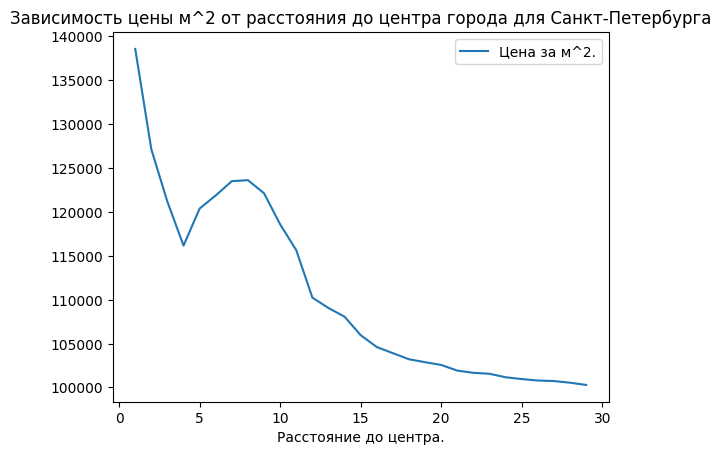

In [93]:
# Найдем макс. расстояние до центра в данных
spb_center_km = data.query('locality_name == "Санкт-Петербург"')['city_center_nearest_km'].max()

# Создадим датафрейм, в который запишем значения
price_by_km = pd.DataFrame(columns=['Расстояние до центра.', 'Цена за м^2.'])

# Вычислим среднюю цену за метр в пределах ранее найденной дистанции
i = 0
for km in range(spb_center_km):
    price_by_km.loc[i] = [i+1, data.query('city_center_nearest_km <= @km')['meter_price'].median()]
    i += 1

# Построим график зависимости
price_by_km.plot(x='Расстояние до центра.', y='Цена за м^2.')
plt.title('Зависимость цены м^2 от расстояния до центра города для Санкт-Петербурга')
plt.show();

##### Вывод:
Стоимость метра падает с удалением от центра, за исключением объектов с ценой, завышенной по иным причинам.

### Общий вывод
На площадке Яндекс.Недвижимость представлен широкий спектр объектов от "микроквартир", набирающих популярность в последние годы, до штучных элитных объектов. И тех и других небольшое кол-во, но их присутствие позволяет говорить о хорошей репрезентативности данных.<br>

1. **Портрет объявления.**

   1.1 Медианное объявление на площадке в период 2014-2019 гг. имеет следующие характеристики:
     - цена объекта - 4.62 млн.р.;
     - общая площадь 52 м<sup>2</sup>;
     - жилая площадь 30 м<sup>2</sup>;
     - площадь кухни 9.1 м<sup>2</sup>;
     - медианное время публикации объявления - 110 дней;
     - быстрые продажи - менее 40 дней;
     - медленные - более 250 дней.
     
   1.2 Объявления активно подавались в будние дни и в осенне-зимний сезон, с падением в декабре-январе. Самый пассивный период - летний сезон. В декабре по статистике публикуются объявления с чуть более высокой ценой объектов. 

   1.3 Рекомендации по оптимизации системы:
     - сделать обязательным выбор типа недвижимости (жилая, апартаменты и пр.), так как это выжный параметр для потенциального покупателя, который к тому же упрощает классификацию объявлений;
     - ввести дополнительные проверки при вводе для
       - высоты потолка (на случайные и ошибочные значения менее 2, более 5 м);
       - полей для ввода площадей, для минимизации ошибок, связанных с перепутанными полями;
       - объявлений с этажём или этажностью объекта более 33 этажа, т.к. жилых зданий выше в Санкт-Петербурге нет.

2. **Портрет объекта.**

   2.1 Санкт-Петербург:
     - Медианный объект на площадке в период 2014-2019 гг. имеет следующие характеристики:
       - общая площадь - 53 м<sup>2</sup>;
       - жилую площадь - 31 м<sup>2</sup>;
       - площадь кухни - 9.3 м<sup>2</sup>;
       - находится на 5-ом этаже в 9-ти этажном доме;
       - удалена от центра города на 12 км.;
       - среднее время продажи - 110 дней;
       - быстрая продажа - до 41-го дня;
       - медленная продажа - более 252-ух дней;
       - цена за метр растет при приближении объекта к центру города.
       
   2.2 Ленинградская область:
     - Медианный объект на площадке в период 2014-2019 гг. имеет следующие характеристики:
       - общая площадь - 46 м<sup>2</sup>;
       - жилую площадь - 28 м<sup>2</sup>;
       - площадь кухни - 8.7 м<sup>2</sup>;
       - находится на 3-ем этаже в 5-ти этажном доме;
       - удалена от центра города на 29 км.;
       - среднее время продажи - 116 дней;
       - быстрая продажа - до 46-го дня;
       - медленная продажа - более 259-ух дней.
       <br><br>
       
3. **На стоимость объекта влияли больше всего в порядке убывания:**
     - Общая площадь;
     - Жилая площадь;
     - Площадь кухни;
     - Кол-во комнат;
     - Тип этажа - не первый, не последний (незначительно).